# 0. Import libraries and modules

In [160]:
import numpy as np
import pandas as pd
import urllib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
%matplotlib inline
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import urllib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from sklearn.neighbors import KNeighborsClassifier as KNN
import plotly.plotly as py 
from sklearn.decomposition import PCA

import itertools
import sys
import csv

from iso3166 import countries

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression as Lin_Reg
import statsmodels.api as sm
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LassoCV
import time

# 1. Data loading and cleaning

## 1.1 Loading disease data
### 1.1.1 Cancer, cardiovascular diseases and diabetes

Datasets on mortality of three types of non-communicable diseases were downloaded from the World Health Organization website (http://apps.who.int/gho/data/node.main.A859?lang=en). They are then loaded here. First we load the disease mortality data of cancer, diabetes and cardiovascluar diseases. The available years of global data are 2000 and 2012. Below we load the data and rename the columns to make them easier to use.

In [98]:
### Load disease data

## Read cancer data
df_cancer = pd.read_csv('data/WHS2_131 Cancer.csv', delimiter=',')
# Convert column names to lowercase
df_cancer.columns = map(str.lower, df_cancer.columns)
# Rename columns
df_cancer = df_cancer.rename(columns = {' both sexes':'cancer_all'})
df_cancer = df_cancer.rename(columns = {' female':'cancer_female'})
df_cancer = df_cancer.rename(columns = {' male':'cancer_male'})

## Read cardiovascular data
df_cardio = pd.read_csv('data/WHS2_131 Cardiovascular.csv', delimiter=',')
# Convert column names to lowercase
df_cardio.columns = map(str.lower, df_cardio.columns)
# Rename columns
df_cardio = df_cardio.rename(columns = {' both sexes':'cardio_all'})
df_cardio = df_cardio.rename(columns = {' female':'cardio_female'})
df_cardio = df_cardio.rename(columns = {' male':'cardio_male'})

## Read diabetes data
df_diabetes = pd.read_csv('data/WHS2_131 Diabetes.csv', delimiter=',')
# Convert column names to lowercase
df_diabetes.columns = map(str.lower, df_diabetes.columns)
# Rename columns
df_diabetes = df_diabetes.rename(columns = {' both sexes':'diabetes_all'})
df_diabetes = df_diabetes.rename(columns = {' female':'diabetes_female'})
df_diabetes = df_diabetes.rename(columns = {' male':'diabetes_male'})

We merge the different disease datasets into one dataframe for ease of reference. We merge using the iso code for each country.

In [99]:
# Merge three datasets  
data_diseases = pd.merge(df_cancer, df_cardio, on=['iso', 'year'])
data_diseases.drop('country_y', axis = 1, inplace = True)
data_diseases = pd.merge(data_diseases, df_diabetes, on=['iso', 'year'])
data_diseases.drop('country', axis = 1, inplace = True)
data_diseases = data_diseases.rename(columns = {'country_x':'country'})

### 1.1.2 Obesity data
From the literature, we took away that it is difficult to find clear-cut associations of food consumption and the above diseases, given the existence of confounding factors, such as genetics. We hypothesized that food consumption could have a more direct effect on obesity prevalence. Therefore, we included obesity prevalence data in our dataset, to be used as one of the response variables. 
The latest year available is 2014; the data was obtained from http://apps.who.int/gho/data/node.main.A900A?lang=en. 
We load the data and follow the same naming conventions for the columns.

In [100]:
# Load obesity data
df_obesity_raw = pd.read_csv('data/WHO Obesity.csv', delimiter=',', skiprows=3)
# Convert column names to lowercase
df_obesity_raw.columns = map(str.lower, df_obesity_raw.columns)
# Rename columns
df_obesity_raw = df_obesity_raw.rename(columns = {' both sexes':'cancer_all'})
df_obesity_raw = df_obesity_raw.rename(columns = {' female':'obesity_female'})
df_obesity_raw = df_obesity_raw.rename(columns = {' male':'obesity_male'})

Because obesity prevalence is defined as the percentage of people with a BMI above 30,the current version of the data has the percentage and an interval in brackets.
We extract the actual percentage below.

In [101]:
def extract(string):
    l_extract = string.split("[")
    return l_extract[0].strip()

vector_extr = np.vectorize(extract)
data_extr_obesity= vector_extr(df_obesity_raw[[1, 4]])

df_obesity = pd.DataFrame(index = df_obesity_raw['country'], 
                       columns = ['obesity_all_2014', 'obesity_all_2010'])
df_obesity['obesity_all_2014'] = pd.to_numeric(data_extr_obesity[:, 0], errors='coerce')
df_obesity['obesity_all_2010'] = pd.to_numeric(data_extr_obesity[:, 1], errors='coerce')
df_obesity['country'] = df_obesity.index.values

### 1.3 Creating a Cross-Sectional Consolidated Dataframe with Predictors

Up to this moment, we have panel data from 1962. Given that panel dataset techniques were not covered in CS109a, we transform the dataset into cross-sectional, generating a new predictor from each disease incidence per year - e.g. obesity_1980, etc. This makes modeling easier. The result is a dataset of country observations and explanatory variables for each year as separate predictors.

In [102]:
# For 2000 data 
data_diseases_2000 = data_diseases[data_diseases['year'] == 2000]
columns = data_diseases_2000.columns[3:] 
for c in columns: 
    data_diseases_2000 = data_diseases_2000.rename(columns = {c : c+'_2000'})

# For 2012 data 
data_diseases_2012 = data_diseases[data_diseases['year'] == 2012]
columns = data_diseases_2012.columns[3:] 
for c in columns: 
    data_diseases_2012 = data_diseases_2012.rename(columns = {c : c+'_2012'})

# Merge 200 and 2012 data 
data_diseases = pd.merge(data_diseases_2000, data_diseases_2012[3:], on=['iso','country'])
data_diseases.drop('year_x', axis = 1, inplace = True)
data_diseases.drop('year_y', axis = 1, inplace = True)

#Merge obesity with data_diseases
data_diseases = pd.merge(data_diseases, df_obesity, on=['country'])

## 1.2 Food Data

Datasets on food supply were downloaded from the Food and Agriculture Organization of the United Nations website (http://faostat3.fao.org/home/E). Food supply here means domestic food consumptions by different food items. There are two main food datasources from FAOSTAT - crop and animal sources. We load and create consolidated dataframes following the established convention above.

### 1.2.1 Crop Data
Below we change the column names to follow naming conventions and for ease of manipulation.

In [7]:
## Load food data
df_food = pd.read_csv('data/FoodSupply_Crops_E_All_Data.csv', delimiter=',')
## Change column names to lower case
df_food.columns = map(str.lower, df_food.columns)
## Keep only necessary columns 
a = range(1,113,2)
df_food = df_food[a]
## Drop y in year column names 
df_food = df_food.rename(columns=lambda x: x.replace('y', ''))
df_food = df_food.rename(columns = {'countr':'country'})

**Create a consolidated dataframe for all years consumption**

We filter the main elements of individual food items that we will use (calories, grams, protein, fat). We also create a cross-sectional dataframe (All Years x Item columns) following the setup of the response variables (disease dataframe) we created in 1.1. We create a predictor per year (or transposition) for each food element making up each food item (e.g. fat in banana for every year 1962, protein in banana for 2012, etc). At the end, we merge all four element dataframes into one: data_food.

In [8]:
# Pick elements that we will use 
kcal = df_food[df_food['element'] == "Food supply (kcal/capita/day)"]
total = df_food[df_food['element'] == "Food supply quantity (g/capita/day)"] 
protein = df_food[df_food['element'] == "Protein supply quantity (g/capita/day)"]
fat = df_food[df_food['element'] == "Fat supply quantity (g/capita/day)"]

In [9]:
### Create Year x Item columns for each element 
# kcal data 
years = df_food.columns[3:]
item = df_food['item'].unique()
item = np.delete(item,18)
df_kcal = kcal[kcal['item'] == item[0]]

for y in years:
    df_kcal= df_kcal.rename(columns = {y : "kcal_" + item[0]+'_' + y})
df_kcal.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = kcal[kcal['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"kcal_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_kcal = pd.merge(df_kcal, item_i, how = 'left', on = ['country', 'element'])

df_kcal.drop('element', axis = 1, inplace = True)

In [10]:
# Total food consumption data 
item = df_food['item'].unique()
item = np.delete(item,18)
df_total = total[total['item'] == item[0]]

for y in years:
    df_total= df_total.rename(columns = {y : "total_" + item[0]+ '_' + y})
df_total.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = total[total['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"total_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_total = pd.merge(df_total, item_i, how = 'left', on = ['country', 'element'])

df_total.drop('element', axis = 1, inplace = True)


In [11]:
# Protein consumption
item = df_food['item'].unique()
item = np.delete(item,18)
df_protein = protein[protein['item'] == item[0]]

for y in years:
    df_protein= df_protein.rename(columns = {y : "protein_" + item[0]+ '_' + y})
df_protein.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = protein[protein['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"protein_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_protein = pd.merge(df_protein, item_i, how = 'left', on = ['country', 'element'])

df_protein.drop('element', axis = 1, inplace = True)

In [12]:
# Fat consumption 
item = df_food['item'].unique()
item = np.delete(item,18)
df_fat = fat[fat['item'] == item[0]]

for y in years:
    df_fat= df_fat.rename(columns = {y : "fat_" + item[0]+ '_' + y})
df_fat.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = fat[fat['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"fat_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_fat = pd.merge(df_fat, item_i, how = 'left', on = ['country', 'element'])

df_fat.drop('element', axis = 1, inplace = True)

In [13]:
# Merge four datasets created above 
data_food = pd.merge(df_kcal, df_total, how = 'left', on = ['country'])
data_food = pd.merge(data_food, df_protein, how = 'left', on = ['country'])
data_food = pd.merge(data_food, df_fat, how = 'left', on = ['country'])

### 1.2.2 Livestock and Fish Data
We load the livestock and fish data from FAOSTAT in order to have a full picture of the food consumption data. Below we clean up some of the item codes and variable names.

In [189]:
## Load food data
df_food_meat = pd.read_csv('data/FoodSupply_LivestockFish_E_All_Data.csv', delimiter=',')
## Change column names to lower case
df_food_meat.columns = map(str.lower, df_food_meat.columns)

### Change some item names 
df_food_meat['item'].loc[df_food_meat['item'] == "Grand Total"] = "Grand Total meat" 
df_food_meat['item'].loc[df_food_meat['item code'] == 2744] = "Egg_ind" 
df_food_meat['item'].loc[df_food_meat['item code'] == 2848] = "Milk-Excluding Better_ind" 

## Keep only necessary columns 
a = range(1,113,2)
df_food_meat = df_food_meat[a]

## Drop y in year column names 
df_food_meat = df_food_meat.rename(columns=lambda x: x.replace('y', ''))
df_food_meat = df_food_meat.rename(columns = {'countr':'country'})

Again, we pick the main food elements we will use and do the predictor creation/ transposition of the data by food item, element and year, following the convention established above.

In [15]:
# Pick elements that we will use 
kcal = df_food_meat[df_food_meat['element'] == "Food supply (kcal/capita/day)"]
total = df_food_meat[df_food_meat['element'] == "Food supply quantity (g/capita/day)"] 
protein = df_food_meat[df_food_meat['element'] == "Protein supply quantity (g/capita/day)"]
fat = df_food_meat[df_food_meat['element'] == "Fat supply quantity (g/capita/day)"]

### Create Year x Item columns for each element 
# kcal data 
years = df_food_meat.columns[3:]
item = df_food_meat['item'].unique()
df_kcal = kcal[kcal['item'] == item[0]]

for y in years:
    df_kcal= df_kcal.rename(columns = {y : "kcal_" + item[0]+'_' + y})
df_kcal.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = kcal[kcal['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"kcal_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_kcal = pd.merge(df_kcal, item_i, how = 'left', on = ['country', 'element'])

df_kcal.drop('element', axis = 1, inplace = True)

df_kcal = df_kcal.drop_duplicates()

# Total food consumption data 
item = df_food['item'].unique()
item = np.delete(item,18)
df_total = total[total['item'] == item[0]]

for y in years:
    df_total= df_total.rename(columns = {y : "total_" + item[0]+ '_' + y})
df_total.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = total[total['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"total_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_total = pd.merge(df_total, item_i, how = 'left', on = ['country', 'element'])

df_total.drop('element', axis = 1, inplace = True)
df_total = df_total.drop_duplicates()

# Protein consumption
item = df_food_meat['item'].unique()
df_protein = protein[protein['item'] == item[0]]

for y in years:
    df_protein= df_protein.rename(columns = {y : "protein_" + item[0]+ '_' + y})
df_protein.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = protein[protein['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"protein_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_protein = pd.merge(df_protein, item_i, how = 'left', on = ['country', 'element'])

df_protein.drop('element', axis = 1, inplace = True)
df_protein = df_protein.drop_duplicates()

# Fat consumption 
item = df_food_meat['item'].unique()
df_fat = fat[fat['item'] == item[0]]

for y in years:
    df_fat= df_fat.rename(columns = {y : "fat_" + item[0]+ '_' + y})
df_fat.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = fat[fat['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"fat_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_fat = pd.merge(df_fat, item_i, how = 'left', on = ['country', 'element'])

df_fat.drop('element', axis = 1, inplace = True)
df_fat = df_fat.drop_duplicates()

# Merge four datasets created above 
data_food_meat = pd.merge(df_kcal, df_total, how = 'left', on = ['country'])
data_food_meat = pd.merge(data_food_meat, df_protein, how = 'left', on = ['country'])
data_food_meat = pd.merge(data_food_meat, df_fat, how = 'left', on = ['country'])

We are now ready to merge the food consumption dataframes from crops and livestock and fish into one. Below we merge on "country" since they are from the same source and follow the same country naming.

In [16]:
# Merge crop data with meat data 
data_food =pd.merge(data_food, data_food_meat, how = 'left', on = ['country'])

### 1.2.3 Decade average food data

**Create dataframe with average values of food consumption for each decade**

We will test the hypothesis of how many years it would take for changes in consumption patterns to affect health outcomes. Because we hypothesize that consumption is smooth over time, we create a separate dataframe with decade average food consumption. This reduces dimensionality of the data. The performance of the models we develop later will be assessed on both all years and all decades averages.

To get the decade average for each predictor, we transform the column heads to the decade they represent, by converting the column header type from string to int and dividing by 10. Then we average each country's food variable for that decade.

In [17]:
df_food_decade=df_food #create a duplicate dataframe
df_food_decade.columns = df_food_decade.columns.astype(int) #create to integer to allow for operations 
#create labels for columns with decades 
df_food_decade = df_food_decade.rename(columns=lambda x: (x//10)*10)

We create a new dataframe for each decade in order to make it easier to get the avarage for each observation, which will be all merged back to an average decade dataframe.

In [18]:
df_1960=pd.DataFrame(df_food_decade[[1960]].mean(axis=1), columns=["Average_1960"])
df_1970=pd.DataFrame(df_food_decade[[1970]].mean(axis=1), columns=["Average_1970"])
df_1980=pd.DataFrame(df_food_decade[[1980]].mean(axis=1), columns=["Average_1980"])
df_1990=pd.DataFrame(df_food_decade[[1990]].mean(axis=1), columns=["Average_1990"])
df_2000=pd.DataFrame(df_food_decade[[2000]].mean(axis=1), columns=["Average_2000"])
df_2010=pd.DataFrame(df_food_decade[[2010]].mean(axis=1), columns=["Average_2010"])

Reload df_food code field because the below will not be able to find the country/item/element columns due to confusion with df_food_decade.

In [19]:
## Load food data
df_food = pd.read_csv('data/FoodSupply_Crops_E_All_Data.csv', delimiter=',')
## Change column names to lower case
df_food.columns = map(str.lower, df_food.columns)
## Keep only necessary columns 
a = range(1,113,2)
df_food = df_food[a]
## Drop y in year column names 
df_food = df_food.rename(columns=lambda x: x.replace('y', ''))
df_food = df_food.rename(columns = {'countr':'country'})

In [20]:
decade_average_food=pd.concat([df_1960,df_1970, df_1980,df_1990,df_2000,df_2010],axis=1)
df_3 = df_food[["country", "item","element"]]
decade_average_food=pd.concat([df_3,decade_average_food], axis=1)

**Create a dataframe with element per item per decade **

We follow the same methodology from 1.2b for creating a predictor per decade and transposing the data.

In [21]:
#Select elements that we will use 
kcal_d = decade_average_food[decade_average_food['element'] == "Food supply (kcal/capita/day)"]
total_d = decade_average_food[decade_average_food['element'] == "Food supply quantity (g/capita/day)"] 
protein_d = decade_average_food[decade_average_food['element'] == "Protein supply quantity (g/capita/day)"]
fat_d = decade_average_food[decade_average_food['element'] == "Fat supply quantity (g/capita/day)"]

### Create Year x Item columns for each element 
# kcal data 
years = decade_average_food.columns[3:]
item = decade_average_food['item'].unique()
item = np.delete(item,18)
df_kcal1 = kcal_d[kcal_d['item'] == item[0]]

for y in years:
    df_kcal1= df_kcal1.rename(columns = {y : "kcal_" + item[0]+'_' + y})
df_kcal1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = kcal_d[kcal_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"kcal_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_kcal1 = pd.merge(df_kcal1, item_i, how = 'left', on = ['country', 'element'])

df_kcal1.drop('element', axis = 1, inplace = True)

# Total food consumption data 
item = decade_average_food['item'].unique()
item = np.delete(item,18)
df_total1 = total_d[total_d['item'] == item[0]]

for y in years:
    df_total1= df_total1.rename(columns = {y : "total_" + item[0]+ '_' + y})
df_total1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = total_d[total_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"total_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_total1 = pd.merge(df_total1, item_i, how = 'left', on = ['country', 'element'])

df_total1.drop('element', axis = 1, inplace = True)

# Protein consumption
item = decade_average_food['item'].unique()
item = np.delete(item,18)
df_protein1 = protein_d[protein_d['item'] == item[0]]

for y in years:
    df_protein1= df_protein1.rename(columns = {y : "protein_" + item[0]+ '_' + y})
df_protein1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = protein_d[protein_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"protein_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_protein1 = pd.merge(df_protein1, item_i, how = 'left', on = ['country', 'element'])

df_protein1.drop('element', axis = 1, inplace = True)

# Fat consumption 
item = decade_average_food['item'].unique()
item = np.delete(item,18)
df_fat1 = fat_d[fat_d['item'] == item[0]]

for y in years:
    df_fat1= df_fat1.rename(columns = {y : "fat_" + item[0]+ '_' + y})
df_fat1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = fat_d[fat_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"fat_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_fat1 = pd.merge(df_fat1, item_i, how = 'left', on = ['country', 'element'])

df_fat1.drop('element', axis = 1, inplace = True)

In [22]:
# Merge four decadees food datasets created above 
data_decade_food = pd.merge(df_kcal1, df_total1, how = 'left', on = ['country'])
data_decade_food = pd.merge(data_decade_food, df_protein1, how = 'left', on = ['country'])
data_decade_food = pd.merge(data_decade_food, df_fat1, how = 'left', on = ['country'])
data_decade_food.shape

(216, 2161)

We average the food consumption from livestock and fish sources over decades and follow the steps above.

In [23]:
### Livestock and Fish data 

df_food_decade_meat=df_food_meat #create a duplicate dataframe
df_food_decade_meat.columns = df_food_decade_meat.columns.astype(int) #create to integer to allow for operations 

#create labels for columns with decades 
df_food_decade_meat = df_food_decade_meat.rename(columns=lambda x: (x//10)*10)

In [24]:
df_1960=pd.DataFrame(df_food_decade_meat[[1960]].mean(axis=1), columns=["Average_1960"])
df_1970=pd.DataFrame(df_food_decade_meat[[1970]].mean(axis=1), columns=["Average_1970"])
df_1980=pd.DataFrame(df_food_decade_meat[[1980]].mean(axis=1), columns=["Average_1980"])
df_1990=pd.DataFrame(df_food_decade_meat[[1990]].mean(axis=1), columns=["Average_1990"])
df_2000=pd.DataFrame(df_food_decade_meat[[2000]].mean(axis=1), columns=["Average_2000"])
df_2010=pd.DataFrame(df_food_decade_meat[[2010]].mean(axis=1), columns=["Average_2010"])

In [25]:
## Load food data
df_food_meat = pd.read_csv('data/FoodSupply_LivestockFish_E_All_Data.csv', delimiter=',')
## Change column names to lower case
df_food_meat.columns = map(str.lower, df_food_meat.columns)

### Change some item names 
df_food_meat['item'].loc[df_food_meat['item'] == "Grand Total"] = "Grand Total meat" 
df_food_meat['item'].loc[df_food_meat['item code'] == 2744] = "Egg_ind" 
df_food_meat['item'].loc[df_food_meat['item code'] == 2848] = "Milk-Excluding Better_ind" 

## Keep only necessary columns 
a = range(1,113,2)
df_food_meat = df_food_meat[a]
## Drop y in year column names 
df_food_meat = df_food_meat.rename(columns=lambda x: x.replace('y', ''))
df_food_meat = df_food_meat.rename(columns = {'countr':'country'})

In [26]:
decade_average_food_meat=pd.concat([df_1960,df_1970, df_1980,df_1990,df_2000,df_2010],axis=1)
df_3_meat = df_food_meat[["country", "item","element"]]
decade_average_food_meat=pd.concat([df_3_meat,decade_average_food_meat], axis=1)

In [27]:
# Change item name "Grand total" to avoid confusion wiht "Grand total" in crop data 
decade_average_food_meat['item'].loc[decade_average_food_meat['item'] == "Grand Total"] = "Grand Total meat" 

In [28]:
#Select elements that we will use 
kcal_d = decade_average_food_meat[decade_average_food_meat['element'] == "Food supply (kcal/capita/day)"]
total_d = decade_average_food_meat[decade_average_food_meat['element'] == "Food supply quantity (g/capita/day)"] 
protein_d = decade_average_food_meat[decade_average_food_meat['element'] == "Protein supply quantity (g/capita/day)"]
fat_d = decade_average_food_meat[decade_average_food_meat['element'] == "Fat supply quantity (g/capita/day)"]

### Create Year x Item columns for each element 
# kcal data 
years = decade_average_food_meat.columns[3:]
item = decade_average_food_meat['item'].unique()
df_kcal1 = kcal_d[kcal_d['item'] == item[0]]

for y in years:
    df_kcal1= df_kcal1.rename(columns = {y : "kcal_" + item[0]+'_' + y})
df_kcal1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = kcal_d[kcal_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"kcal_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_kcal1 = pd.merge(df_kcal1, item_i, how = 'left', on = ['country', 'element'])

df_kcal1.drop('element', axis = 1, inplace = True)
df_kcal1 = df_kcal1.drop_duplicates()

# Total food consumption data 
item = decade_average_food_meat['item'].unique()
df_total1 = total_d[total_d['item'] == item[0]]

for y in years:
    df_total1= df_total1.rename(columns = {y : "total_" + item[0]+ '_' + y})
df_total1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = total_d[total_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"total_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_total1 = pd.merge(df_total1, item_i, how = 'left', on = ['country', 'element'])

df_total1.drop('element', axis = 1, inplace = True)
df_total1 = df_total1.drop_duplicates(['country'])

# Protein consumption
item = decade_average_food_meat['item'].unique()
df_protein1 = protein_d[protein_d['item'] == item[0]]

for y in years:
    df_protein1= df_protein1.rename(columns = {y : "protein_" + item[0]+ '_' + y})
df_protein1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = protein_d[protein_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"protein_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_protein1 = pd.merge(df_protein1, item_i, how = 'left', on = ['country', 'element'])

df_protein1.drop('element', axis = 1, inplace = True)
df_protein1 = df_protein1.drop_duplicates()

# Fat consumption 
item = decade_average_food_meat['item'].unique()
df_fat1 = fat_d[fat_d['item'] == item[0]]

for y in years:
    df_fat1= df_fat1.rename(columns = {y : "fat_" + item[0]+ '_' + y})
df_fat1.drop('item', axis = 1, inplace = True)

item=item[1:]

for i in item: 
    item_i = fat_d[fat_d['item'] == i]
    for y in years:
        item_i= item_i.rename(columns = {y:"fat_"+ i +'_'+ y})
    item_i.drop('item', axis = 1, inplace = True)
    df_fat1 = pd.merge(df_fat1, item_i, how = 'left', on = ['country', 'element'])

df_fat1.drop('element', axis = 1, inplace = True)
df_fat1 = df_fat1.drop_duplicates()

In [29]:
# Merge four decadees food datasets created above 
data_decade_food_meat = pd.merge(df_kcal1, df_total1, how = 'left', on = ['country'])
data_decade_food_meat = pd.merge(data_decade_food_meat, df_protein1, how = 'left', on = ['country'])
data_decade_food_meat = pd.merge(data_decade_food_meat, df_fat1, how = 'left', on = ['country'])
data_decade_food_meat.shape

(216, 913)

We merge the decade average food consumption data from crop and animal sources below.

In [30]:
# Merge crop data with meat data 
data_decade_food =pd.merge(data_decade_food, data_decade_food_meat, how = 'left', on = ['country'])
data_decade_food.shape

(216, 3073)

### 1.2.4 Adding ISO code for Countries
In order to make facilitate future lookup and merging with other sources of data, we import ISO codes from a iso3166 library. This will standardize the cross-reference across datasets, which may use different names for countries.

In [31]:
# Get iso code 
import iso3166
df_iso=pd.DataFrame(iso3166.countries_by_alpha2, index= ["country", "iso2", "iso3", "num", "country2"])
df_iso = df_iso.transpose()
df_iso = df_iso[["country", "iso3"]]
df_iso = df_iso.rename(columns = {'iso3': 'iso'})

# Merge with datafood with iso code for all years dataset
data_food = pd.merge(df_iso,data_food, how = 'left', on=['country'])
# Merge with datafood with iso code for decade average dataset
data_decade_food = pd.merge(df_iso,data_decade_food, how = 'left', on=['country'])

C:\Users\Katia\Anaconda2\lib\site-packages\pandas\tools\merge.py:714: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



### 1.2.5 Dietary diversity index

Along with quantity consumed, we would also like to explore if the diversity of the diet of a country affects disease mortality and prevalence rates. 

Note: food diversity is defined as the number of food items that represent more than 0.05% of the total calorie consumption of the country, averaged for the previous ten years before the year of disease statistics. The variable is then normalized (with the maximum number of items equal to 1).

In [32]:
#Select portion of kcal dataframe for last ten years (between 2002 and 2011 for cancer, cardiovascular disease and diabetes;
# between 2004 and 2013 for obesity)
y1 = range(-3, -13, -1)
y2 = range(-1, -11, -1)
kcal_food = df_food[df_food['element'] == "Food supply (kcal/capita/day)"]
kcal_meat = df_food_meat[df_food_meat['element'] == "Food supply (kcal/capita/day)"]
kcal = pd.concat([kcal_food, kcal_meat], axis=0)
kcal_2002_2011 = pd.concat([kcal[[0,1]], kcal[y1]], axis=1)
kcal_2004_2013 = pd.concat([kcal[[0,1]], kcal[y2]], axis=1)

#Calculate share of total calories by item in ten years
totalcals_country_2002_2011 = kcal_2002_2011.groupby(['country']).sum()
totalcals_country_2004_2013 = kcal_2004_2013.groupby(['country']).sum()

In [33]:
country_list = kcal['country'].unique()
abs_diversity_2002_2011 = pd.DataFrame(columns = range(2002, 2012))
abs_diversity_2004_2013 = pd.DataFrame(columns = range(2004, 2014))

for country in country_list:
    numerator_2002_2011 = kcal_2002_2011[kcal_2002_2011['country'] == country].filter(regex = '20')
    denominator_2002_2011 = totalcals_country_2002_2011.loc[country]
    share_2002_2011_country = numerator_2002_2011.div(denominator_2002_2011)
    abs_diversity_2002_2011.loc[country] = share_2002_2011_country[share_2002_2011_country > 0.001].count(axis = 0).values
    mean_diversity_2002_2011 = abs_diversity_2002_2011.mean(axis = 1)
    numerator_2004_2013 = kcal_2004_2013[kcal_2004_2013['country'] == country].filter(regex = '20')
    denominator_2004_2013 = totalcals_country_2004_2013.loc[country]
    share_2004_2013_country = numerator_2004_2013.div(denominator_2004_2013)
    abs_diversity_2004_2013.loc[country] = share_2004_2013_country[share_2004_2013_country > 0.0001].count(axis = 0).values
    mean_diversity_2004_2013 = abs_diversity_2004_2013.mean(axis = 1)

In [34]:
# Create index
max_items_2002_2011 = mean_diversity_2002_2011.max(axis=0)
diversity_index_2002_2011 = pd.DataFrame(mean_diversity_2002_2011 / max_items_2002_2011, columns = ['diversity_2004_2013'])
max_items_2004_2013 = mean_diversity_2004_2013.max(axis=0)
diversity_index_2004_2013 = pd.DataFrame(mean_diversity_2004_2013 / max_items_2004_2013, columns = ['diversity_2002_2011'])
diversity_index = pd.concat([diversity_index_2002_2011, diversity_index_2004_2013], axis=1)
diversity_index['country'] = diversity_index.index.values


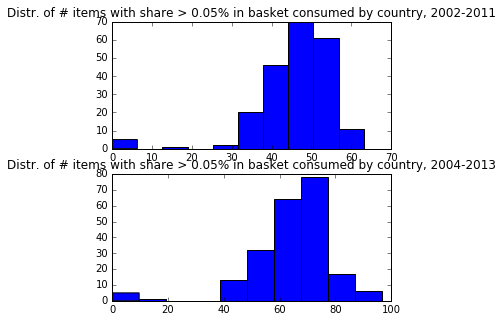

In [35]:
#Distribution of number of items
fig, axes = plt.subplots(2, 1, figsize = (5,5))
axes[0].hist(mean_diversity_2002_2011)
axes[1].hist(mean_diversity_2004_2013)
axes[0].set_title('Distr. of # items with share > 0.05% in basket consumed by country, 2002-2011')
axes[1].set_title('Distr. of # items with share > 0.05% in basket consumed by country, 2004-2013')
plt.show()

In [36]:
#Merge diversity index with datasets
data_food_final = pd.merge(data_food, diversity_index, how='left', on=['country'])

## 1.3 Socio-economic data 
### 1.3.1 Transform World Development Indicators (WDI) into cross-sectional data

We want to explore the association of disease statistics and consumption patterns with the socio-economic characteristics of countries. With that in mind, we import four additional variables from the World Development indicators, published by the World Bank. These are: GDP per capita, health expenditure, population (which we will use for weighing in our models) and overall mortality rate.

In [37]:
# GDP per capita data including healthcare expenditure, mortality rate and population from WDI data
df_econ = pd.read_csv('data/wdi_extended.csv', delimiter=',')
df_econ.columns = map(str.lower, df_econ.columns)
df_econ = df_econ.rename(columns = {'countryname':'country'})

df_econ = df_econ.rename(columns = {'ny_gdp_pcap_pp_kd':'gdppc'})
df_econ = df_econ.rename(columns = {'sh_xpd_totl_zs':'health expenditure'})
df_econ = df_econ.rename(columns = {'sp_pop_totl':'population'})

# Drop unnecessary variables 
df_econ.drop('sh_dyn_mort', axis = 1, inplace = True) #there will be endogeneity


# Create a consolidated dataframe
years = df_econ['year'].unique()
item = ['gdppc', 'mortality', 'health expenditure', 'population']

data_econ = df_econ[df_econ['year']==years[0]]
for i in item: 
    data_econ= data_econ.rename(columns = {i: i + '_' + str(years[0])})

data_econ.drop('year', axis = 1, inplace = True)
data_econ.head()


years = years[1:]
for y in years:
    year_y = df_econ[df_econ['year']==y]
    for i in item: 
        year_y = year_y.rename(columns = {i: i+'_' + str(y)})
    year_y.drop('year', axis = 1, inplace = True)
    data_econ = pd.merge(data_econ, year_y, how = 'left', on = ['country', 'iso'])

### 1.3.2 Income levels (World Bank classification)

We use the World Bank country classification by income level for 2012 to classify countries into four categories: low income (L - 2), lower middle income (LM - 3), upper middle income (UM - 4) and higher income (H - 5).

In [38]:
from sklearn import preprocessing

# Load data of country classification by income
df_income_level = pd.read_csv('data/WB_country class by income_1987-2015.csv', delimiter=';', skiprows=10)

# Encode all labels
level_code_2012 = df_income_level[[25]].values.ravel()
level_code = preprocessing.LabelEncoder().fit_transform(level_code_2012)
income_level_2012 = pd.DataFrame(columns = ['iso', 'income level code'])
income_level_2012['iso'] =  df_income_level[[0]]
income_level_2012['income level code'] = level_code

C:\Users\Katia\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning:

numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.



In [39]:
# Dictionary to order income levels from low to high
new_codes_income = {2: '5', 3: '2', 4: '3', 5: '4'}
# Dictionary to assign labels to income level codes
dict_income_level = {2: 'Low', 3: 'Lower middle', 4: 'Upper middle', 5: 'High'}

def get_key(dictionary, data):
    coded_data = dictionary.get(data)
    return coded_data

vrecode = np.vectorize(get_key)
income_new_codes = vrecode(new_codes_income, income_level_2012['income level code'])
income_new_codes = pd.to_numeric(income_new_codes, errors='coerce')
income_level_2012['income level code'] = income_new_codes

#Add income levels in 2012 for countries to the dataframe
# Merge data_econ with income level data
data_econ = pd.merge(data_econ, income_level_2012, how = 'left', on = ['iso'])

#Set labels to updated income levels
income_level_names = vrecode(dict_income_level, income_level_2012['income level code'])

## 1.4 Merging the datasets  (Disease + Food + Socio-Economic datasets)

### 1.4.1 Merge disease + *** all*** years food + socio-economic datasets

First we will merge all three sources of data by ISO for all years.

In [40]:
data = pd.merge(data_diseases, data_food_final, how = 'left', on=['iso'])
data = pd.merge(data, data_econ, how = 'left', on=['iso'])
data.drop('country_y', axis = 1, inplace = True)
data.drop('country', axis = 1, inplace = True)
data = data.rename(columns = {'country_x':'country'})

# Drop countries for which there is not ISO code in the using datasets
data = data[(data['country'] != "Lao People's Democratic Republic") & (data['country'] != \
                                            "Congo") & (data['country'] != "South Sudan")]
data.index = range(0, len(data), 1)

# Consolidated dataset shape
print "# Number of countries:", len(data.index)
print "# Number of variables:", len(data.columns)

# Number of countries: 165
# Number of variables: 30127


### 1.4.2 Merge disease + **decades average** food + socio-economic datasets
Here we merge the decades averaged food consumption with the other two sources of data, matching again on ISO codes.

In [41]:
data_decade = pd.merge(data_diseases, data_decade_food, how = 'left', on=['iso'])
data_decade = pd.merge(data_decade, data_econ, how = 'left', on=['iso'])
data_decade.drop('country_y', axis = 1, inplace = True)
data_decade.drop('country', axis = 1, inplace = True)
data_decade = data_decade.rename(columns = {'country_x':'country'})

# Drop countries for which there is not ISO code in the using datasets
data_decade = data_decade[(data_decade['country'] != "Lao People's Democratic Republic") & (data_decade['country'] != \
                                            "Congo") & (data_decade['country'] != "South Sudan")]
data_decade.index = range(0, len(data), 1)

# Consolidated dataset shape
print "# Number of countries:", len(data_decade.index)
print "# Number of variables:", len(data_decade.columns)

# Number of countries: 165
# Number of variables: 3305


These will be the two main dataframes we will work with: please note the reduced number of variables in the averaged decades dataframe vs. all years - 3,305 vs. 30,127. We are interested in seeing whether using all years will be advantageous in terms of model performance and will test this in the next section.

*In our detailed analysis we found out that the below countries didn't have income level data for some reason and we are adding them one by one below.

In [42]:
#adding the income level for the two countries that are missing it before imputing
data['income level code'][data['iso'] == 'COD'].set_value = 3
data['income level code'][data['iso'] == 'TLS'].set_value = 4

## 1.5 Missing values imputation

The FAOstat and WDI datasets are not all complete for all years and countries. First we start by exploring the magnitude of the missing values - below we identify the variables with more than 10 and 30% of missing values and we keep the variables that have missing values less than 30%. Then, we explore two types of imputation - mean imputation and knn.

### 1.5.1 Missing values imputation in all years dataframe
**Detecting missing values**

In [43]:
# List variables with no-missing data
nonmiss_cols = [column for column in data.columns if len(data[column][data[column].isnull()]) \
                 == 0]
# List variables with missing data
miss_cols = list(data.columns.difference(nonmiss_cols))

# Set of variables for which the number of missing values is not greater than 30%
miss_cols_th = [column for column in data.columns if \
                len(data[column][data[column].isnull()])*len(data)**-1 \
                 <= 0.30]

# Dataset for imputation
data_v = data[miss_cols_th]

miss_cols_th10 = [column for column in data_v.columns if \
                len(data_v[column][data_v[column].isnull()])*len(data_v)**-1 \
                 <= 0.10]

print "Number of variables with less than 10% of missing values", len(miss_cols_th10)
print "Number of variables with less than 30% of missing values", len(miss_cols_th)

print "# Final number of countries:", len(data_v.index)
print "# Final number of variables:", len(data_v.columns)

Number of variables with less than 10% of missing values 117
Number of variables with less than 30% of missing values 6520
# Final number of countries: 165
# Final number of variables: 6520


** Mean Imputation for all years dataframe **

In [44]:
## ALTERNATIVE 1: Impute variables using mean imputation ##

# Exclude non-missing variables from 10% or less set
miss_10 = list(data_v[miss_cols_th10].columns.difference(nonmiss_cols))
# Exclude less than 10% from less than 30%
miss_30 = list(data_v[miss_cols_th].columns.difference(miss_cols_th10))
# Imputation by mean value: variables with less than 10% of missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_v[miss_10])
data_v_10imp = pd.DataFrame(imp.transform(data_v[miss_10]), columns = [miss_10])
# Imputation by mean value: variables with more than 10% of missing values
imp.fit(data_v[miss_30])
data_v_30imp = pd.DataFrame(imp.transform(data_v[miss_30]), columns = [miss_30])

## Final dataset

data_imp = pd.concat([data_v_10imp, data_v_30imp], axis=1)
data_final = pd.concat([data[nonmiss_cols], data_imp], axis=1)
data_final.shape

(165, 6520)

**KNN Imputation for all years dataframe **

In [45]:
## ALTERNATIVE 2:Impute variables using KNN; not missing variables as inputs ##

# Define x vars for imputation
diseases = list(['cancer_all_2000', 'cancer_all_2012', 'cancer_female_2000', \
                'cancer_female_2012', 'cancer_male_2000', 'cancer_male_2012', \
                'cardio_all_2000', 'cardio_all_2012', 'cardio_female_2000', \
                'cardio_female_2012', 'cardio_male_2000', 'cardio_male_2012', \
                'diabetes_all_2000', 'diabetes_all_2012', 'diabetes_female_2000', \
                'diabetes_female_2012', 'diabetes_male_2000', 'diabetes_male_2012', \
                'obesity_all_2010', 'obesity_all_2014'])
ids = list(['iso', 'country', 'region', 'regioncode', 'income level code']) 
x_vars_ni = list(set(nonmiss_cols) - set(diseases) - set(ids))
x_vars = list(data_v_10imp.columns | x_vars_ni)
x_ni = data_v[x_vars_ni]
x = pd.DataFrame(np.column_stack([data_v_10imp.values, x_ni.values]))



# y variable with missing values and x variables with no missing values

imputed = pd.DataFrame(columns = miss_30)

for v in miss_30:
    df = pd.DataFrame(np.column_stack([data_v[v], x]))
    df = df.replace('NaN', np.nan)
    
    #Separate the rows with missing information
    df_missing = df[df[0].isnull()]
    df_filled = df[~df[0].isnull()]
    df_filled = df_filled.astype('int')
    #test_ind = int(0.3 * len(df_filled.index))
    
    #KNN-imputation 
    knn = KNN(n_neighbors=3)
    knn.fit(df_filled.ix[:, df_filled.columns != 0], \
            np.ravel(df_filled.ix[:, df_filled.columns == 0]))
    df_predict = df_missing.copy() 
    df_predict.ix[:, df_predict.columns == 0] = \
    (knn.predict(df_missing.ix[:, df_missing.columns != 0])).reshape(len(df_missing), 1)
    df_all = pd.concat([df_filled, df_predict])
    imputed[v] = np.ravel(df_all.ix[:, df_all.columns == 0]) 
    
# Final dataset after imputation for all years
data_imp_knn = pd.concat([data_v_10imp, imputed], axis=1)
data_final_knn_ally = pd.concat([data[nonmiss_cols], data_imp_knn], axis=1)

data_final_knn_ally.columns.unique()

array(['iso', 'country', 'cancer_all_2000', ..., 'total_Wine_2009_x',
       'total_Wine_2010_x', 'total_Wine_2011_x'], dtype=object)

### 1.5.2 Missing values in decade average dataframe
**Detecting missing values in decades average dataframe **

In [46]:
# List variables with no-missing data
nonmiss_cols = [column for column in data_decade.columns if len(data_decade[column][data_decade[column].isnull()]) \
                 == 0]
# List variables with missing data
miss_cols = list(data_decade.columns.difference(nonmiss_cols))

# Set of variables for which the number of missing values is not greater than 30%
miss_cols_th = [column for column in data_decade.columns if \
                len(data_decade[column][data_decade[column].isnull()])*len(data_decade)**-1 \
                 <= 0.30]

# Dataset for imputation
data_v = data_decade[miss_cols_th]

miss_cols_th10 = [column for column in data_v.columns if \
                len(data_v[column][data_v[column].isnull()])*len(data_v)**-1 \
                 <= 0.10]

print "Number of variables with less than 10% of missing values", len(miss_cols_th10)
print "Number of variables with less than 30% of missing values", len(miss_cols_th)


print "# Final number of countries:", len(data_v.index)
print "# Final number of variables:", len(data_v.columns)


Number of variables with less than 10% of missing values 117
Number of variables with less than 30% of missing values 1145
# Final number of countries: 165
# Final number of variables: 1145


**Mean Imputation in decades average dataframe **

In [47]:
## ALTERNATIVE 1: Impute variables using mean imputation ##

# Exclude non-missing variables from 10% or less set
miss_10 = list(data_v[miss_cols_th10].columns.difference(nonmiss_cols))
# Exclude less than 10% from less than 30%
miss_30 = list(data_v[miss_cols_th].columns.difference(miss_cols_th10))
# Imputation by mean value: variables with less than 10% of missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_v[miss_10])
data_v_10imp = pd.DataFrame(imp.transform(data_v[miss_10]), columns = [miss_10])
# Imputation by mean value: variables with more than 10% of missing values
imp.fit(data_v[miss_30])
data_v_30imp = pd.DataFrame(imp.transform(data_v[miss_30]), columns = [miss_30])

## Final dataset

data_imp = pd.concat([data_v_10imp, data_v_30imp], axis=1)
data_final_decades = pd.concat([data_decade[nonmiss_cols], data_imp], axis=1)
data_final_decades.shape

(165, 1145)

 data_final is the decades data imputed using averages for decades

**KNN Imputation in decades average dataframe **

In [48]:
## ALTERNATIVE 2:Impute variables using KNN; not missing variables as inputs ##

# Define x vars for imputation
diseases = list(['cancer_all_2000', 'cancer_all_2012', 'cancer_female_2000', \
                'cancer_female_2012', 'cancer_male_2000', 'cancer_male_2012', \
                'cardio_all_2000', 'cardio_all_2012', 'cardio_female_2000', \
                'cardio_female_2012', 'cardio_male_2000', 'cardio_male_2012', \
                'diabetes_all_2000', 'diabetes_all_2012', 'diabetes_female_2000', \
                'diabetes_female_2012', 'diabetes_male_2000', 'diabetes_male_2012'])
ids = list(['iso', 'country', 'region', 'regioncode']) 
x_vars_ni = list(set(nonmiss_cols) - set(diseases) - set(ids))
x_vars = list(data_v_10imp.columns | x_vars_ni)
x_ni = data_v[x_vars_ni]
x = pd.DataFrame(np.column_stack([data_v_10imp.values, x_ni.values]))

In [49]:
# y variable with missing values and x variables with no missing values

imputed = pd.DataFrame(columns = miss_30)

for v in miss_30:
    df = pd.DataFrame(np.column_stack([data_v[v], x]))
    df = df.replace('NaN', np.nan)
    
    #Separate the rows with missing information
    df_missing = df[df[0].isnull()]
    df_filled = df[~df[0].isnull()]
    df_filled = df_filled.astype('int')
    #test_ind = int(0.3 * len(df_filled.index))
    
    #KNN-imputation 
    knn = KNN(n_neighbors=3)
    knn.fit(df_filled.ix[:, df_filled.columns != 0], \
            np.ravel(df_filled.ix[:, df_filled.columns == 0]))
    df_predict = df_missing.copy() 
    df_predict.ix[:, df_predict.columns == 0] = \
    (knn.predict(df_missing.ix[:, df_missing.columns != 0])).reshape(len(df_missing), 1)
    df_all = pd.concat([df_filled, df_predict])
    imputed[v] = np.ravel(df_all.ix[:, df_all.columns == 0]) 

## Final dataset

In [50]:
data_imp_knn = pd.concat([data_v_10imp, imputed], axis=1)
data_final_knn_decades = pd.concat([data_decade[nonmiss_cols], data_imp], axis=1)
data_final_knn_decades.shape

(165, 1145)

We tested whether using mean imputed vs knn imputed models perform differently and discovered that there was no change in the r square of the models explored. This analysis is not included in this notebook to keep it simple and to the point. However, if we change our performance metric from R squared to something else, we will return to this issue and test whether mean vs knn no difference still holds.

We also tested whether using decades average vs. last 10 years of yearly consumption changes performance of our models for milestone 3 and decided that the optimal use of data would be to use 10 years of yearly data for response variable of diseases in 2012.

## 1.6 Final dataframes for models 
### 1.6.1 Separation of individual food items vs. food groups for 2000-2012 yearly data

In this section, we will work with 2 dataframes - 1) all food items  2) all food groups with 2000 and 2012 yearly data. 

We will also have the latest year of disease statistics for the four types of diseases -  2012 and 2014 (in the case of obesity). We will address the problem of overfitting by using leave one out cross validation, as we deem this to be the most appropriate of the CV methods because each observation in our datasets is a country. 

** Individual food item data for the last decade**

First we remove the group items for both crop and animal and fish. We will do this by importing the column names of the datasets _by_group that we downloaded from FAOSTAT (they essentially contain only the group level data that is already contained in the aggregate dataframe that we created). Then we will exclude them from the data_final dataframe. Finally, we will drop the years that are earlier than 2000 - from our analysis we determined that earlier years after applying lasso regression do not affect disease prevalence. We also want to reduce dimensions in the predictors and this will help us to do that. 

In [51]:
food_group=pd.read_csv('data/Foodsupply_by_group.csv', usecols=[7])
food_group_names=food_group["ItemName"].unique()
food_groups=list(food_group_names)
#create a list with column names 
sugars = data_final.filter(regex='Sugar & Sweeteners')
cereals=data_final.filter(regex='Cereals - Excluding Beer')
starchy_roots=data_final.filter(regex='Starchy Roots')
pulses=data_final.filter(regex='Pulses')
treenuts=data_final.filter(regex='Treenuts')
oilcrops=data_final.filter(regex='Oilcrops')
veg_oils=data_final.filter(regex='Vegetable Oils')
vegs=data_final.filter(regex='Vegetables')
fruits=data_final.filter(regex='Fruits - Excluding Wine')
stimulants=data_final.filter(regex='Stimulants')
spices=data_final.filter(regex='Spices')
alcohol=data_final.filter(regex='Alcoholic Beverages')
misc=data_final.filter(regex='Miscellaneous')
grand_total=data_final.filter(regex='Grand Total')
veg_prod=data_final.filter(regex='Vegetal Products')
sug_cro=data_final.filter(regex='Sugar Crops')


In [52]:
animal_food_group=pd.read_csv('data/FoodSupply_LivestockFish_by_group.csv', usecols=[7])
animal_food_group_names=animal_food_group["Item"].unique()
animal_food_groups=list(animal_food_group_names)
animal_food_groups

animal_fats = data_final.filter(regex='Animal fats')
eggs=data_final.filter(regex='Eggs')
fish=data_final.filter(regex='Fish, Seafood')
meat=data_final.filter(regex='Meat')
milk=data_final.filter(regex='Milk - Excluding Butter')
offals=data_final.filter(regex='Offals')
animal_prod=data_final.filter(regex='Animal Products')
aquatic=data_final.filter(regex='Aquatic Products, Other')

groups=list(sugars.columns) + list(cereals.columns) + list(starchy_roots.columns) + list(pulses.columns)+ list(treenuts.columns)+ list(oilcrops.columns)+ list(veg_oils.columns)+ list(vegs.columns)+list(fruits.columns)+ list(stimulants.columns)+ list(spices.columns)+list(alcohol.columns)+ list(misc.columns)+ list(grand_total.columns)+list(veg_prod.columns)+ list(sug_cro.columns) +list(animal_fats.columns)+list(eggs.columns)+list(fish.columns)+list(meat.columns)+list(milk.columns)+list(offals.columns)+list(animal_prod.columns)+list(aquatic.columns)

Now that we have the group column names, we just take them out from the dataframe along with data dating earlier than 2000. This leaves us with the individual food items data.

In [53]:
data_groups = data_final[groups]
all_cols=data_final.columns
old_data=data_final.filter(regex='19')
remaining_cols = list(set(all_cols) - set(data_groups)-set(old_data))
data_food_items = data_final[remaining_cols]

We add a column with 2012 population weights for each country to be used in the modeling part.
We export for team use.

In [54]:
tot_pop=data_food_items['population_2012'].sum()
data_food_items['pop_weight_2012'] = data_food_items['population_2012'].apply(lambda x: x / tot_pop)
data_food_items.to_csv("food_items_2000s.csv")

C:\Users\Katia\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



**Food groups data for years of the last decade**

In [55]:
data_food_groups = data_final[groups]
all_cols2=data_food_groups.columns

food_group_df=data_final[all_cols2]


gdppc = data_final.filter(regex='gdppc')
gdp=list(gdppc.columns)

gdp_df=data_final[gdp] #dgp df

health_exp=data_final.filter(regex='health')
health_expenditure=list(health_exp.columns)

health_df=data_final[health_expenditure]

population=data_final.filter(regex="population")
pop=list(population.columns)

pop_df=data_final[pop]

diseases = list(['cancer_all_2000', 'cancer_all_2012', 'cancer_female_2000', \
                'cancer_female_2012', 'cancer_male_2000', 'cancer_male_2012', \
                'cardio_all_2000', 'cardio_all_2012', 'cardio_female_2000', \
                'cardio_female_2012', 'cardio_male_2000', 'cardio_male_2012', \
                'diabetes_all_2000', 'diabetes_all_2012', 'diabetes_female_2000', \
                'diabetes_female_2012', 'diabetes_male_2000', 'diabetes_male_2012', \
                'obesity_all_2010', 'obesity_all_2014'])

ids = list(['iso', 'country', 'income level code'])

dis_df=data_final[diseases]
id_df=data_final[ids]

#merge food groups with others

data_food_groups=pd.concat([id_df, dis_df, gdp_df, health_df, pop_df, food_group_df], axis=1)

In [56]:
all_cols3=data_food_groups.columns
old_data2=data_food_groups.filter(regex='19')
old_years2=list(old_data2.columns)

#remove old years
remaining_cols3 = list(set(all_cols3)- set(old_years2))
data_food_groups = data_food_groups[remaining_cols3]


In [57]:
tot_pop=data_food_groups['population_2012'].sum()
data_food_groups['pop_weight_2012'] = data_food_groups['population_2012'].apply(lambda x: x / tot_pop)
data_food_groups.to_csv("food_groups_2000s.csv")

### 1.6.2 Cleaning up decade average data and breaking it down by food item and food group

**By food item for decades mean imputed data from 80s to 2010s**

In [58]:
#create a list with column names 
sugars = data_final_decades.filter(regex='Sugar & Sweeteners')
cereals=data_final_decades.filter(regex='Cereals - Excluding Beer')
starchy_roots=data_final_decades.filter(regex='Starchy Roots')
pulses=data_final_decades.filter(regex='Pulses')
treenuts=data_final_decades.filter(regex='Treenuts')
oilcrops=data_final_decades.filter(regex='Oilcrops')
veg_oils=data_final_decades.filter(regex='Vegetable Oils')
vegs=data_final_decades.filter(regex='Vegetables')
fruits=data_final_decades.filter(regex='Fruits - Excluding Wine')
stimulants=data_final_decades.filter(regex='Stimulants')
spices=data_final_decades.filter(regex='Spices')
alcohol=data_final_decades.filter(regex='Alcoholic Beverages')
misc=data_final_decades.filter(regex='Miscellaneous')
grand_total=data_final_decades.filter(regex='Grand Total')
veg_prod=data_final_decades.filter(regex='Vegetal Products')
sug_cro=data_final_decades.filter(regex='Sugar Crops')

animal_fats = data_final_decades.filter(regex='Animal fats')
eggs=data_final_decades.filter(regex='Eggs')
fish=data_final_decades.filter(regex='Fish, Seafood')
meat=data_final_decades.filter(regex='Meat')
milk=data_final_decades.filter(regex='Milk - Excluding Butter')
offals=data_final_decades.filter(regex='Offals')
animal_prod=data_final_decades.filter(regex='Animal Products')
aquatic=data_final_decades.filter(regex='Aquatic Products, Other')

groups=list(sugars.columns) + list(cereals.columns) + list(starchy_roots.columns) + list(pulses.columns)+ list(treenuts.columns)+ list(oilcrops.columns)+ list(veg_oils.columns)+ list(vegs.columns)+list(fruits.columns)+ list(stimulants.columns)+ list(spices.columns)+list(alcohol.columns)+ list(misc.columns)+ list(grand_total.columns)+list(veg_prod.columns)+ list(sug_cro.columns) +list(animal_fats.columns)+list(eggs.columns)+list(fish.columns)+list(meat.columns)+list(milk.columns)+list(offals.columns)+list(animal_prod.columns)+list(aquatic.columns)

In [59]:
data_decades_groups = data_final_decades[groups]
all_cols_dec=data_final_decades.columns
old_data_dec6=data_final.filter(regex='196')
old_data_dec7=data_final.filter(regex='197')
remaining_cols_dec = list(set(all_cols_dec) - set(data_groups)-set(old_data_dec6)-set(old_data_dec7))
data_food_items_dec = data_final_decades[remaining_cols_dec]

In [60]:
tot_pop=data_food_items_dec['population_2012'].sum()
data_food_items_dec['pop_weight_2012'] = data_food_items_dec['population_2012'].apply(lambda x: x / tot_pop)
data_food_items_dec.to_csv("food_items_dec80sto2010.csv")

C:\Users\Katia\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



**By food groups for mean imputed data for decades 80s to 2010s**

In [61]:
data_food_groups_dec = data_final_decades[groups]
all_cols2_dec=data_food_groups_dec.columns

food_group_df=data_final_decades[all_cols2_dec]


gdppc = data_final_decades.filter(regex='gdppc')
gdp=list(gdppc.columns)

gdp_df=data_final_decades[gdp] #dgp df

health_exp=data_final_decades.filter(regex='health')
health_expenditure=list(health_exp.columns)

health_df=data_final_decades[health_expenditure]

population=data_final_decades.filter(regex="population")
pop=list(population.columns)

pop_df=data_final_decades[pop]

dis_df=data_final_decades[diseases]
id_df=data_final_decades[ids]

#merge food groups with others

data_food_groups_dec=pd.concat([id_df, dis_df, gdp_df, health_df, pop_df, food_group_df], axis=1)

In [62]:
tot_pop=data_food_groups_dec['population_2012'].sum()
data_food_groups_dec['pop_weight_2012'] = data_food_groups_dec['population_2012'].apply(lambda x: x / tot_pop)
data_food_groups_dec.to_csv("food_groups_dec80sto2010.csv")

# 2. Data exploration

## 2.1 Maps of disease statistics

We explore disease statistics (mortality and prevalence data) by mapping it using plotly. Since plotly requires a login every time, we have imported the images of the maps, which are shown below. The code is included for reference.

In [64]:
import plotly.plotly as py 

py.sign_in('Semiray', '86y7w4kfh1')
data = [ dict(
        type = 'choropleth',
        locations = data_food_items['iso'],
        z = data_food_items['obesity_all_2014'],
        text = data_food_items['country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Obesity Prevalence for 2014'),
      ) ]

layout = dict(
    title = '2014 Obesity Prevalence Rate Source: WHO',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Semiray/0 or inside your plot.ly account where it is named 'd3-world-map'


<img src="2012 Cancer All.png">

<img src="2012 Cardio All.png">

<img src="2012 Diabetes All.png">

<img src="Obesity mortality 2014.png">

## 2.2 Consumption Patterns

We also wanted to check whether:
   1. There are significance differences in consumption patterns **across income levels**.
   2. There are significance differences in consumption patterms **over time**.

In [65]:
### Food Consumption (gr)

data = pd.read_csv('consumption patterns.csv')
data.loc[(data['income level code'] > 3) & (data['income level code'] < 4)] = 3
sugars = data.filter(regex='total_Sugar & Sweeteners_Average')
veg_oils = data.filter(regex='total_Vegetable Oils_Average')
pulses = data.filter(regex='total_Pulses_Average')
vegetables = data.filter(regex='total_Vegetables_Average')
fruits = data.filter(regex='total_Fruits - Excluding Wine_Average')
cereals = data.filter(regex='total_Cereals - Excluding Beer_Average')
oilcrops = data.filter(regex='total_Oilcrops_Average')
alcohol = data.filter(regex='total_Alcoholic Beverages_Average')

food_gr = pd.concat([data['income level code'], sugars, veg_oils, pulses, \
                    vegetables, fruits, cereals, oilcrops, alcohol], axis=1)


food_gr_mean = food_gr.groupby(['income level code']).mean()
food_gr_mean.index = [range(1,5,1)]
food_gr_mean['income level'] = range(2,6,1)
cols = food_gr_mean.columns.tolist()
cols = cols[-1:] + cols[:-1]
food_gr_mean = food_gr_mean[cols]
food_gr_mean


# Calculating average total consumption per food item, by income level

for i in range(2,6,1):
    locals()['food_gr_mean_{0}'.format(i)] = food_gr_mean[food_gr_mean['income level'] == i]
    locals()['sugars_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_{0}'.format(i)] = locals()['food_gr_mean_{0}'.format(i)].filter(regex='Alcoholic Beverages')

In [66]:
### Average Protein (gr)

sugars = data.filter(regex='protein_Sugar & Sweeteners_Average')
veg_oils = data.filter(regex='protein_Vegetable Oils_Average')
pulses = data.filter(regex='protein_Pulses_Average')
vegetables = data.filter(regex='protein_Vegetables_Average')
fruits = data.filter(regex='protein_Fruits - Excluding Wine_Average')
cereals = data.filter(regex='protein_Cereals - Excluding Beer_Average')
oilcrops = data.filter(regex='protein_Oilcrops_Average')
alcohol = data.filter(regex='protein_Alcoholic Beverages_Average')

protein = pd.concat([data['income level code'], sugars, veg_oils, pulses, \
                    vegetables, fruits, cereals, oilcrops, alcohol], axis=1)

pro_mean = protein.groupby(['income level code']).mean()
pro_mean.index = [range(1,5,1)]
pro_mean['income level'] = range(2,6,1)
cols = pro_mean.columns.tolist()
cols = cols[-1:] + cols[:-1]
pro_mean = pro_mean[cols]
pro_mean

# Calculating average protein per food item, by income level

for i in range(2,6,1):
    locals()['pro_mean_{0}'.format(i)] = pro_mean[pro_mean['income level'] == i]
    locals()['sugars_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_pro_{0}'.format(i)] = locals()['pro_mean_{0}'.format(i)].filter(regex='Alcoholic Beverages')

pro_mean['Total 1990'] = pro_mean.filter(regex='1990').sum(axis=1)
pro_mean['Total 2000'] = pro_mean.filter(regex='2000').sum(axis=1)
pro_mean['Total 2010'] = pro_mean.filter(regex='2010').sum(axis=1)

In [67]:
### Average Calories Intake (kcal)

#Note: Decades dataframe: data_final

sugars = data.filter(regex='kcal_Sugar & Sweeteners_Average')
veg_oils = data.filter(regex='kcal_Vegetable Oils_Average')
pulses = data.filter(regex='kcal_Pulses_Average')
vegetables = data.filter(regex='kcal_Vegetables_Average')
fruits = data.filter(regex='kcal_Fruits - Excluding Wine_Average')
cereals = data.filter(regex='kcal_Cereals - Excluding Beer_Average')
oilcrops = data.filter(regex='kcal_Oilcrops_Average')
alcohol = data.filter(regex='kcal_Alcoholic Beverages_Average')

kcal = pd.concat([data['income level code'], sugars, veg_oils, pulses, \
                    vegetables, fruits, cereals, oilcrops, alcohol], axis=1)

kcal_mean = food_gr.groupby(['income level code']).mean()
kcal_mean.index = [range(1,5,1)]
kcal_mean['income level'] = range(2,6,1)
cols = kcal_mean.columns.tolist()
cols = cols[-1:] + cols[:-1]
kcal_mean = kcal_mean[cols]
kcal_mean

# Calculating average calories intake per food item, by income level

for i in range(2,6,1):
    locals()['kcal_mean_{0}'.format(i)] = kcal_mean[kcal_mean['income level'] == i]
    locals()['sugars_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_kcal_{0}'.format(i)] = locals()['kcal_mean_{0}'.format(i)].filter(regex='Alcoholic Beverages')

kcal_mean['Total 1990'] = kcal_mean.filter(regex='1990').sum(axis=1)
kcal_mean['Total 2000'] = kcal_mean.filter(regex='2000').sum(axis=1)
kcal_mean['Total 2010'] = kcal_mean.filter(regex='2010').sum(axis=1)

In [68]:
### Average Fat (gr)

#Note: Decades dataframe: data_final

sugars = data.filter(regex='fat_Sugar & Sweeteners_Average')
veg_oils = data.filter(regex='fat_Vegetable Oils_Average')
pulses = data.filter(regex='fat_Pulses_Average')
vegetables = data.filter(regex='fat_Vegetables_Average')
fruits = data.filter(regex='fat_Fruits - Excluding Wine_Average')
cereals = data.filter(regex='fat_Cereals - Excluding Beer_Average')
oilcrops = data.filter(regex='fat_Oilcrops_Average')
alcohol = data.filter(regex='fat_Alcoholic Beverages_Average')

fat = pd.concat([data['income level code'], sugars, veg_oils, pulses, \
                    vegetables, fruits, cereals, oilcrops, alcohol], axis=1)

fat_mean = fat.groupby(['income level code']).mean()
fat_mean.index = [range(1,5,1)]
fat_mean['income level'] = range(2,6,1)
cols = fat_mean.columns.tolist()
cols = cols[-1:] + cols[:-1]
fat_mean = fat_mean[cols]
fat_mean

# Calculating average fat intake per food item, by income level

for i in range(2,6,1):
    locals()['fat_mean_{0}'.format(i)] = fat_mean[fat_mean['income level'] == i]
    locals()['sugars_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_fat_{0}'.format(i)] = locals()['fat_mean_{0}'.format(i)].filter(regex='Alcoholic Beverages')

fat_mean['Total 1990'] = fat_mean.filter(regex='1990').sum(axis=1)
fat_mean['Total 2000'] = fat_mean.filter(regex='2000').sum(axis=1)
fat_mean['Total 2010'] = fat_mean.filter(regex='2010').sum(axis=1)

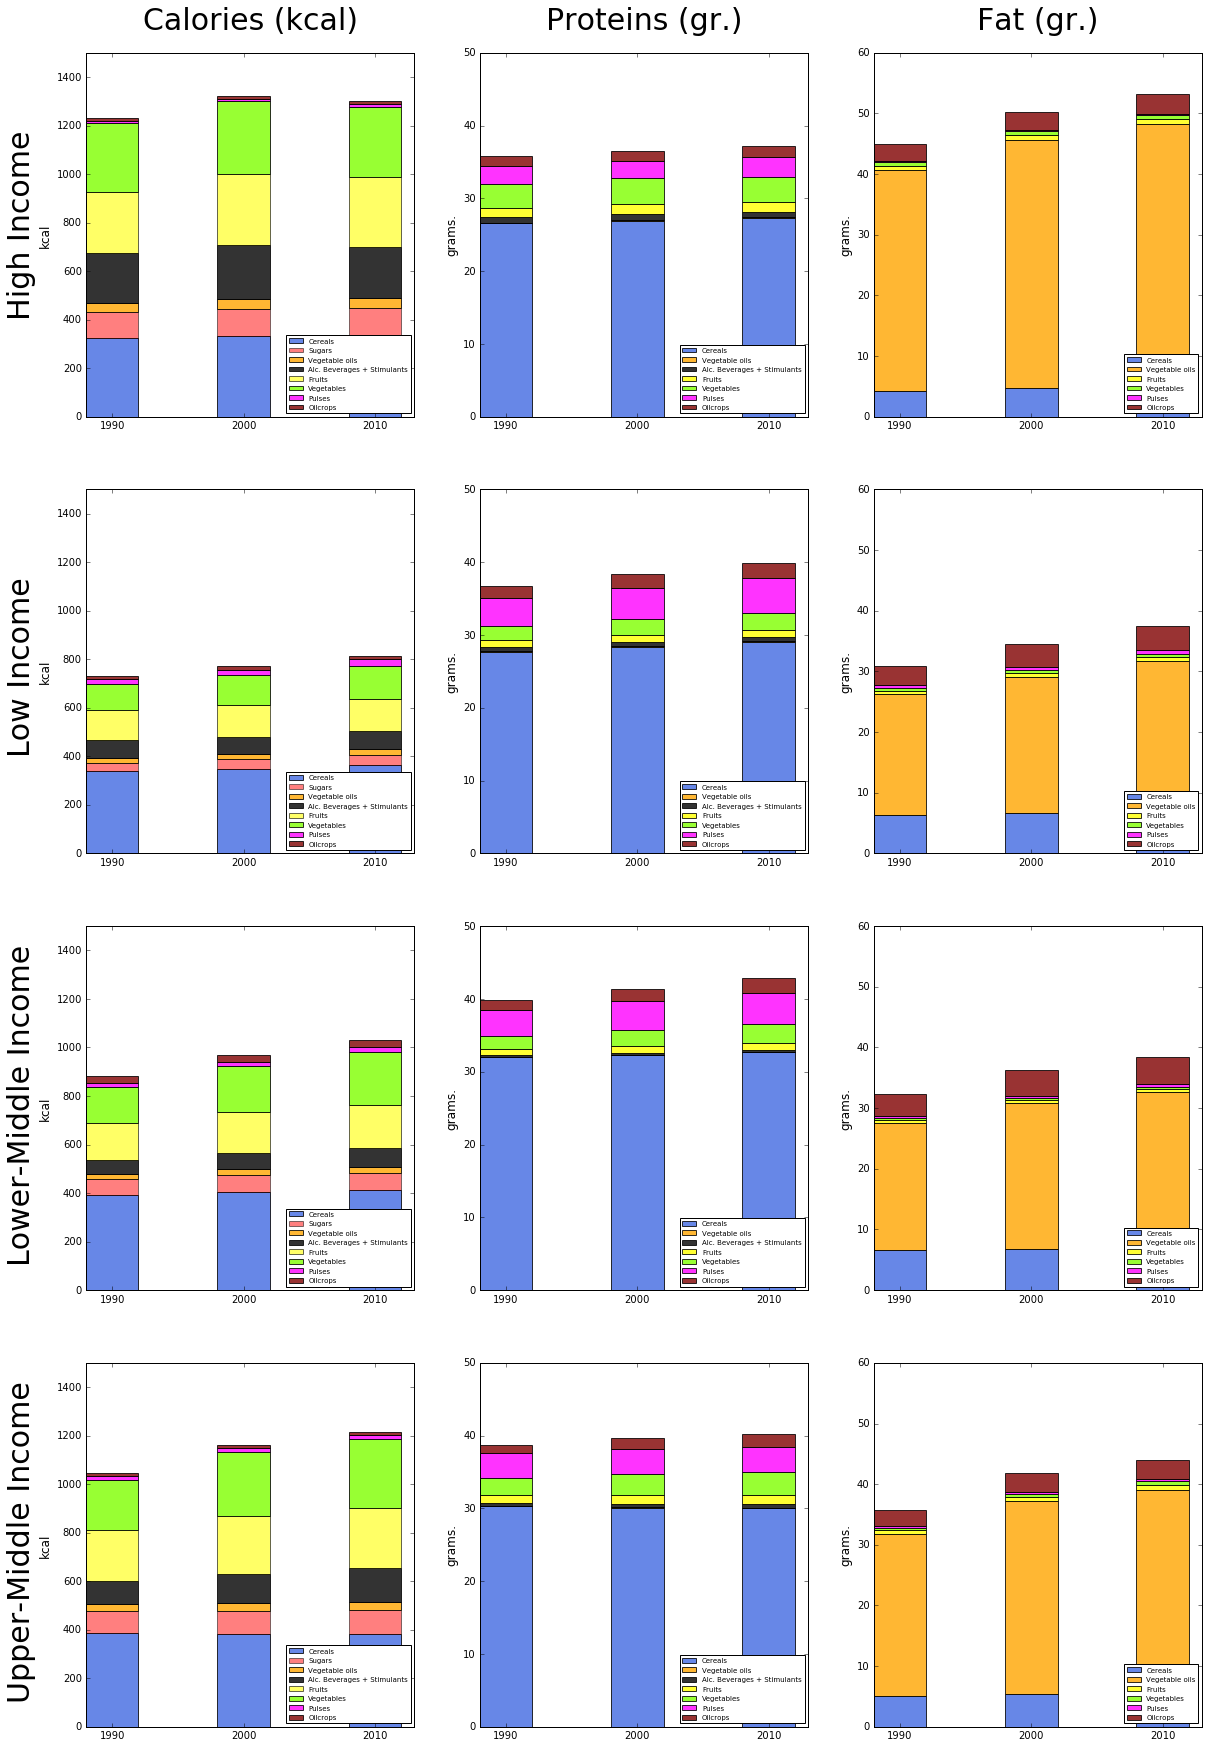

In [69]:
decade = 3
ind = np.arange(1, decade+1)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

cols = ['Column {}'.format(col) for col in ['Kcal', 'Protein', 'Fat']]
rows = ['Row {}'.format(row) for row in ['High Income', 'Lower Income', 'Lower-Middle Income', \
                                         'Upper Middle Income']]

##  Consumption Patterns

n_rows = 4
n_cols = 3
fig, ax = plt.subplots (nrows=n_rows, ncols=n_cols, figsize = (20, 30))

# Calories
for r in range(2, 6, 1):
    cereals = locals()['cereals_kcal_{0}'.format(r)].values.reshape(decade)
    sugars = locals()['sugars_kcal_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_kcal_{0}'.format(r)].values.reshape(decade)
    alcohol = locals()['alcohol_kcal_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_kcal_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_kcal_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_kcal_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_kcal_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),0].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),0].bar(ind, sugars, width, bottom=cereals, color='red', alpha=0.5)
    p3 = ax[int(r-2),0].bar(ind, veg_oils, width, \
             bottom=[i+j for i,j in zip(cereals,sugars)], \
             color='orange', alpha=0.8)
    p4 = ax[int(r-2),0].bar(ind, alcohol, width, color='black', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals,sugars, veg_oils)])
    p5 = ax[int(r-2),0].bar(ind, fruits, width, color='yellow', alpha=0.6, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals,sugars, veg_oils, alcohol)])
    p6 = ax[int(r-2),0].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits)])
    p7 = ax[int(r-2),0].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l+m+n for i,j,k,l,m,n in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits, vegetables)])
    p8 = ax[int(r-2),0].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m+n+p for i,j,k,l,m,n,p in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits, vegetables, pulses)])
    ax[int(r-2),0].legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Sugars', 'Vegetable oils', 'Alc. Beverages + Stimulants', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),0].set_xticks(ind + width/2.)
    ax[int(r-2),0].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),0].set_ylabel('kcal', size=(12))
    ax[int(r-2),0].set_ylabel
    ax[int(r-2),0].set_ylim([0,1500])

# Proteins
for r in range(2, 6, 1):
    cereals = locals()['cereals_pro_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_pro_{0}'.format(r)].values.reshape(decade)
    alcohol = locals()['alcohol_pro_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_pro_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_pro_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_pro_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_pro_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),1].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),1].bar(ind, veg_oils, width, bottom=cereals, color='orange', alpha=0.8)
    p4 = ax[int(r-2),1].bar(ind, alcohol, width, color='black', alpha=0.8, \
             bottom=[i+j for i,j in \
                     zip(cereals, veg_oils)])
    p5 = ax[int(r-2),1].bar(ind, fruits, width, color='yellow', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals, veg_oils, alcohol)])
    p6 = ax[int(r-2),1].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals, veg_oils, alcohol, fruits)])
    p7 = ax[int(r-2),1].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals, veg_oils, alcohol, fruits, vegetables)])
    p8 = ax[int(r-2),1].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m+n for i,j,k,l,m,n in \
                     zip(cereals, veg_oils, alcohol, fruits, vegetables, pulses)])
    ax[int(r-2),1].legend((p1[0], p2[0], p4[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Vegetable oils', 'Alc. Beverages + Stimulants', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),1].set_xticks(ind + width/2.)
    ax[int(r-2),1].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),1].set_ylabel('grams.', size=(12))
    ax[int(r-2),1].set_ylim([0,50])

# Fat
for r in range(2, 6, 1):
    cereals = locals()['cereals_fat_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_fat_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_fat_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_fat_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_fat_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_fat_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),2].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),2].bar(ind, veg_oils, width, bottom=cereals, color='orange', alpha=0.8)
    p5 = ax[int(r-2),2].bar(ind, fruits, width, color='yellow', alpha=0.8, \
             bottom=[i+j for i,j in \
                     zip(cereals, veg_oils)])
    p6 = ax[int(r-2),2].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals, veg_oils, fruits)])
    p7 = ax[int(r-2),2].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals, veg_oils, fruits, vegetables)])
    p8 = ax[int(r-2),2].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals, veg_oils, fruits, vegetables, pulses)])
    ax[int(r-2),2].legend((p1[0], p2[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Vegetable oils', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),2].set_xticks(ind + width/2.)
    ax[int(r-2),2].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),2].set_ylabel('grams.', size=(12))
    ax[int(r-2),2].set_ylim([0,60])

ax[0,0].set_title('Calories (kcal)', size=(30), y=1.05)
ax[0,1].set_title('Proteins (gr.)', size=(30), y=1.05)
ax[0,2].set_title('Fat (gr.)', size=(30), y=1.05)
#ax[0,1].set_ylim([0,50])
#ax[0,2].set_ylim([0,60])

ax[0][0].text(x = 0.4, y = 400, s = "High Income", rotation = 90, va = "bottom", size=(30))
ax[1][0].text(x = 0.4, y = 400, s = "Low Income", rotation = 90, va = "bottom", size=(30))
ax[2][0].text(x = 0.4, y = 100, s = "Lower-Middle Income", rotation = 90, va = "bottom", size=(30))
ax[3][0].text(x = 0.4, y = 100, s = "Upper-Middle Income", rotation = 90, va = "bottom", size=(30))

plt.savefig('Consumption Patterns.png')
plt.show()

In [70]:
## In case we want represent kcal intake as percentage of total.

kcal_mean_p = kcal_mean
pro_mean_p = pro_mean
fat_mean_p = fat_mean

# Kcal
kcal_mean_p[kcal_mean_p.filter(regex='1990').columns] = \
kcal_mean_p[kcal_mean_p.filter(regex='1990').columns].div(kcal_mean_p['Total 1990'], axis=0)

kcal_mean_p[kcal_mean_p.filter(regex='2000').columns] = \
kcal_mean_p[kcal_mean_p.filter(regex='2000').columns].div(kcal_mean_p['Total 2000'], axis=0)

kcal_mean_p[kcal_mean_p.filter(regex='2010').columns] = \
kcal_mean_p[kcal_mean_p.filter(regex='2010').columns].div(kcal_mean_p['Total 2010'], axis=0)

# Proteins
pro_mean_p[pro_mean_p.filter(regex='1990').columns] = \
pro_mean_p[pro_mean_p.filter(regex='1990').columns].div(pro_mean_p['Total 1990'], axis=0)

pro_mean_p[pro_mean_p.filter(regex='2000').columns] = \
pro_mean_p[pro_mean_p.filter(regex='2000').columns].div(pro_mean_p['Total 2000'], axis=0)

pro_mean_p[pro_mean_p.filter(regex='2010').columns] = \
pro_mean_p[pro_mean_p.filter(regex='2010').columns].div(pro_mean_p['Total 2010'], axis=0)

# Fat
fat_mean_p[fat_mean_p.filter(regex='1990').columns] = \
fat_mean_p[fat_mean_p.filter(regex='1990').columns].div(fat_mean_p['Total 1990'], axis=0)

fat_mean_p[fat_mean_p.filter(regex='2000').columns] = \
fat_mean_p[fat_mean_p.filter(regex='2000').columns].div(fat_mean_p['Total 2000'], axis=0)

fat_mean_p[fat_mean_p.filter(regex='2010').columns] = \
fat_mean_p[fat_mean_p.filter(regex='2010').columns].div(fat_mean_p['Total 2010'], axis=0)


# Kcal p by income group
for i in range(2,6,1):
    locals()['kcal_mean_p_{0}'.format(i)] = kcal_mean_p[kcal_mean_p['income level'] == i]
    locals()['sugars_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_kcal_p_{0}'.format(i)] = locals()['kcal_mean_p_{0}'.format(i)].filter(regex='Alcoholic Beverages')

# Proteins p by income group
for i in range(2,6,1):
    locals()['pro_mean_p_{0}'.format(i)] = pro_mean_p[pro_mean_p['income level'] == i]
    locals()['sugars_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_pro_p_{0}'.format(i)] = locals()['pro_mean_p_{0}'.format(i)].filter(regex='Alcoholic Beverages')

# Fat p by income group
for i in range(2,6,1):
    locals()['fat_mean_p_{0}'.format(i)] = fat_mean_p[fat_mean_p['income level'] == i]
    locals()['sugars_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Sugar')
    locals()['veg_oils_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Vegetable Oils')
    locals()['pulses_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Pulses')
    locals()['vegetables_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Vegetables')
    locals()['fruits_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Fruits')
    locals()['cereals_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Cereals')
    locals()['oilcrops_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Oilcrops')
    locals()['alcohol_fat_p_{0}'.format(i)] = locals()['fat_mean_p_{0}'.format(i)].filter(regex='Alcoholic Beverages')


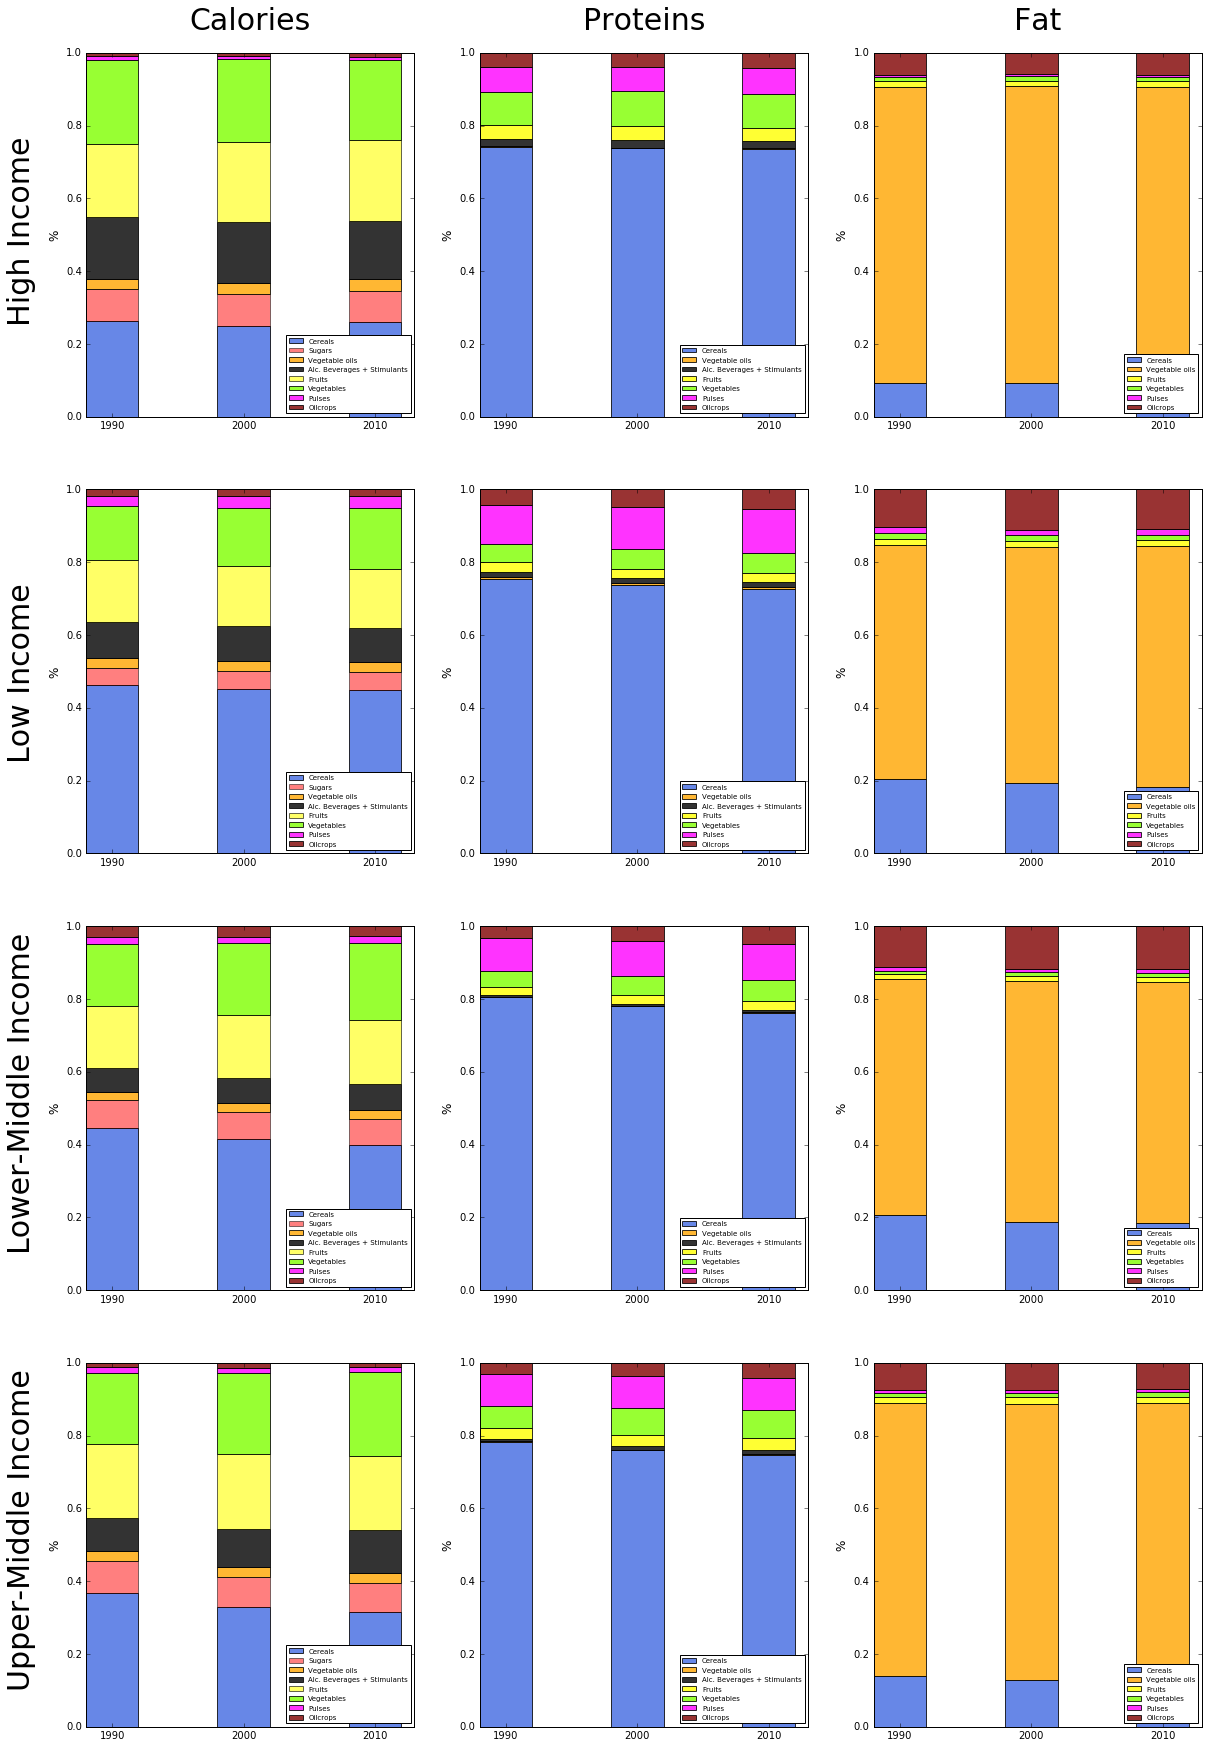

In [71]:
decade = 3
ind = np.arange(1, decade+1)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

cols = ['Column {}'.format(col) for col in ['Kcal', 'Protein', 'Fat']]
rows = ['Row {}'.format(row) for row in ['High Income', 'Lower Income', 'Lower-Middle Income', \
                                         'Upper Middle Income']]

##  Consumption patterns (%)

n_rows = 4
n_cols = 3
fig, ax = plt.subplots (nrows=n_rows, ncols=n_cols, figsize = (20, 30))

# Calories
for r in range(2, 6, 1):
    cereals = locals()['cereals_kcal_p_{0}'.format(r)].values.reshape(decade)
    sugars = locals()['sugars_kcal_p_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_kcal_p_{0}'.format(r)].values.reshape(decade)
    alcohol = locals()['alcohol_kcal_p_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_kcal_p_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_kcal_p_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_kcal_p_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_kcal_p_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),0].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),0].bar(ind, sugars, width, bottom=cereals, color='red', alpha=0.5)
    p3 = ax[int(r-2),0].bar(ind, veg_oils, width, \
             bottom=[i+j for i,j in zip(cereals,sugars)], \
             color='orange', alpha=0.8)
    p4 = ax[int(r-2),0].bar(ind, alcohol, width, color='black', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals,sugars, veg_oils)])
    p5 = ax[int(r-2),0].bar(ind, fruits, width, color='yellow', alpha=0.6, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals,sugars, veg_oils, alcohol)])
    p6 = ax[int(r-2),0].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits)])
    p7 = ax[int(r-2),0].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l+m+n for i,j,k,l,m,n in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits, vegetables)])
    p8 = ax[int(r-2),0].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m+n+p for i,j,k,l,m,n,p in \
                     zip(cereals,sugars, veg_oils, alcohol, fruits, vegetables, pulses)])
    ax[int(r-2),0].legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Sugars', 'Vegetable oils', 'Alc. Beverages + Stimulants', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),0].set_xticks(ind + width/2.)
    ax[int(r-2),0].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),0].set_ylabel('%', size=(12))

# Proteins
for r in range(2, 6, 1):
    cereals = locals()['cereals_pro_p_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_pro_p_{0}'.format(r)].values.reshape(decade)
    alcohol = locals()['alcohol_pro_p_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_pro_p_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_pro_p_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_pro_p_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_pro_p_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),1].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),1].bar(ind, veg_oils, width, bottom=cereals, color='orange', alpha=0.8)
    p4 = ax[int(r-2),1].bar(ind, alcohol, width, color='black', alpha=0.8, \
             bottom=[i+j for i,j in \
                     zip(cereals, veg_oils)])
    p5 = ax[int(r-2),1].bar(ind, fruits, width, color='yellow', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals, veg_oils, alcohol)])
    p6 = ax[int(r-2),1].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals, veg_oils, alcohol, fruits)])
    p7 = ax[int(r-2),1].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals, veg_oils, alcohol, fruits, vegetables)])
    p8 = ax[int(r-2),1].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m+n for i,j,k,l,m,n in \
                     zip(cereals, veg_oils, alcohol, fruits, vegetables, pulses)])
    ax[int(r-2),1].legend((p1[0], p2[0], p4[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Vegetable oils', 'Alc. Beverages + Stimulants', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),1].set_xticks(ind + width/2.)
    ax[int(r-2),1].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),1].set_ylabel('%', size=(12))

# Fat
for r in range(2, 6, 1):
    cereals = locals()['cereals_fat_p_{0}'.format(r)].values.reshape(decade)
    veg_oils = locals()['veg_oils_fat_p_{0}'.format(r)].values.reshape(decade)
    fruits = locals()['fruits_fat_p_{0}'.format(r)].values.reshape(decade)
    vegetables = locals()['vegetables_fat_p_{0}'.format(r)].values.reshape(decade)
    pulses = locals()['pulses_fat_p_{0}'.format(r)].values.reshape(decade)
    oilcrops = locals()['oilcrops_fat_p_{0}'.format(r)].values.reshape(decade)
    
    p1 = ax[int(r-2),2].bar(ind, cereals, width, color='royalblue', alpha=0.8)
    p2 = ax[int(r-2),2].bar(ind, veg_oils, width, bottom=cereals, color='orange', alpha=0.8)
    p5 = ax[int(r-2),2].bar(ind, fruits, width, color='yellow', alpha=0.8, \
             bottom=[i+j for i,j in \
                     zip(cereals, veg_oils)])
    p6 = ax[int(r-2),2].bar(ind, vegetables, width, color='chartreuse', alpha=0.8, \
             bottom=[i+j+k for i,j,k in \
                     zip(cereals, veg_oils, fruits)])
    p7 = ax[int(r-2),2].bar(ind, pulses, width, color='fuchsia', alpha=0.8, \
             bottom=[i+j+k+l for i,j,k,l in \
                     zip(cereals, veg_oils, fruits, vegetables)])
    p8 = ax[int(r-2),2].bar(ind, oilcrops, width, color='maroon', alpha=0.8, \
             bottom=[i+j+k+l+m for i,j,k,l,m in \
                     zip(cereals, veg_oils, fruits, vegetables, pulses)])
    ax[int(r-2),2].legend((p1[0], p2[0], p5[0], p6[0], p7[0], p8[0]), \
           ('Cereals', 'Vegetable oils', \
           'Fruits', 'Vegetables', 'Pulses', 'Oilcrops'), loc=4, prop={'size':7})
    ax[int(r-2),2].set_xticks(ind + width/2.)
    ax[int(r-2),2].set_xticklabels(('1990', '2000', '2010'), size=(10))
    ax[int(r-2),2].set_ylabel('%', size=(12))

ax[0,0].set_title('Calories', size=(30), y=1.05)
ax[0,1].set_title('Proteins', size=(30), y=1.05)
ax[0,2].set_title('Fat', size=(30), y=1.05)

ax[0,0].set_ylim([0,1])
ax[0,1].set_ylim([0,1])
ax[0,2].set_ylim([0,1])

ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
ax[1,2].set_ylim([0,1])

ax[2,0].set_ylim([0,1])
ax[2,1].set_ylim([0,1])
ax[2,2].set_ylim([0,1])

ax[3,0].set_ylim([0,1])
ax[3,1].set_ylim([0,1])
ax[3,2].set_ylim([0,1])

ax[0][0].text(x = 0.4, y = 0.25, s = "High Income", rotation = 90, va = "bottom", size=(30))
ax[1][0].text(x = 0.4, y = 0.25, s = "Low Income", rotation = 90, va = "bottom", size=(30))
ax[2][0].text(x = 0.4, y = 0.1, s = "Lower-Middle Income", rotation = 90, va = "bottom", size=(30))
ax[3][0].text(x = 0.4, y = 0.1, s = "Upper-Middle Income", rotation = 90, va = "bottom", size=(30))

plt.savefig('Consumption Patterns_Percentages.png')
plt.show()

## 2.3 Disease statistics and GDP

### 2.3.1 Linear fit
We explore the relationship between GDP per capita and disease mortality / prevalence rates.

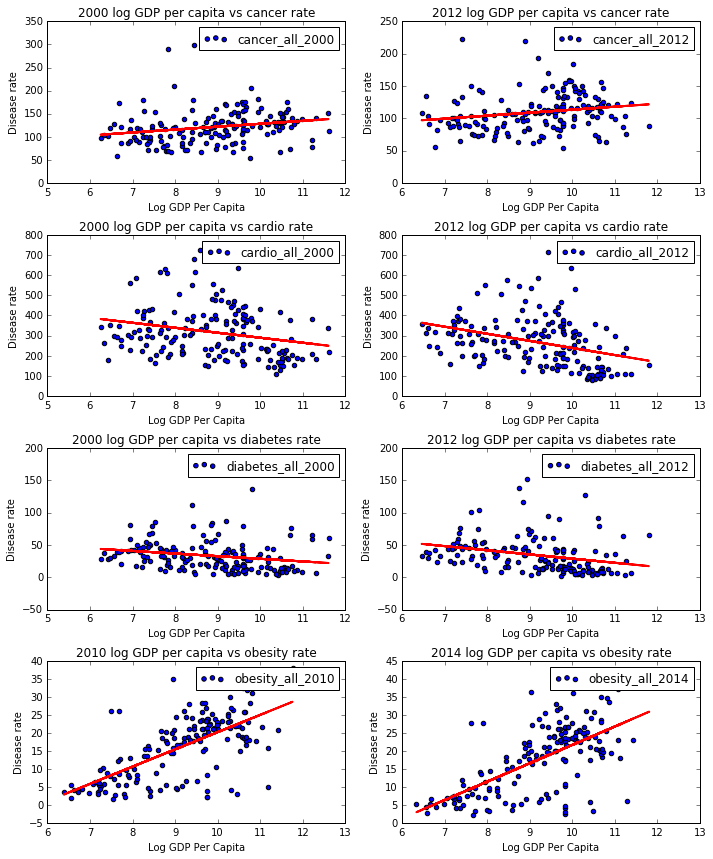

In [72]:
# Create plot for each disease prevalence and year and gdp per capita
fig, ax = plt.subplots(4, 2, figsize = (10, 12))
years_rest=[2000, 2012]
years_ob = [2010, 2014]
diseases = ['cancer', 'cardio', 'diabetes', 'obesity']
ind=0

for d in diseases:
    if d == 'obesity':
        years = years_ob
    else:
        years = years_rest
        
    for year in years:
        # Create x and y variables for every combination of disease and food category
        y = data_food_items[str(d)+"_"+"all_"+str(year)]
        x = np.log(data_food_items["gdppc_"+str(year)].values)
    
        # Create x and y variables for every combination of disease and food category
        y = data_food_items[str(d)+"_"+"all_"+str(year)]
        x = np.log(data_food_items["gdppc_"+str(year)].values)

        # Run and fit a linear regression
        reg = Lin_Reg()
        x=x.reshape(-1,1)
        reg.fit(x, y)
        # Predict values for y
        y_hat = reg.predict(x)
        
        # Create scatterplots
        ax[ind / 2, ind % 2].scatter(x, y, c='b')
        # Add regression line
        ax[ind / 2, ind % 2].plot(x, y_hat, c='r', linewidth=2.0)
        # Plot formatting
        ax[ind / 2, ind % 2].set_title(str(year)+" log GDP per capita vs "+str(d)+" rate")
        ax[ind / 2, ind % 2].set_xlabel('Log GDP Per Capita')
        ax[ind / 2, ind % 2].set_ylabel('Disease rate')
        ax[ind / 2, ind % 2].legend(loc='best')
        ind += 1
plt.tight_layout()
plt.show() 

Because we suspect that a polynomial regression fit may be better, we explore the different degrees and isolate the one with the highest R-squared.

### 2.3.2 Polynomial fit

In [73]:
#--------  polynomial_regression_fit
def polynomial_regression_fit(x_train, y_train, degree): 
    n = x_train.shape[0]
    x_expanded = np.zeros([n, degree])
    for d in range(1, degree + 1):
        x_expanded[:, d - 1] = np.power(x_train, d)
        
    reg = Lin_Reg()
    reg.fit(x_expanded, y_train)
    
    w = reg.coef_
    c = reg.intercept_
    return w, c

def polynomial_regression_predict(w, c, degree, x_test):
    n = x_test.shape[0]
    x_expanded = np.zeros([n, degree])
    for d in range(1, degree + 1):
        x_expanded[:, d - 1] = np.power(x_test, d)        
    y_pred = np.dot(x_expanded, w) + c        
    return y_pred

def polynomial_regression_score(y_pred, y_test):  
    sq_error = np.sum(np.square(y_test - y_pred))
    y_mean = np.mean(y_test)
    y_variance = np.sum(np.square(y_test - y_mean))
    r_squared = 1 - sq_error / y_variance
    return r_squared, sq_error

def fit_and_plot_polynomial(ax, x, y, degree, color):
    w, c = polynomial_regression_fit(x, y, degree)
    x_sorted = np.sort(x) 
    x_sorted=x_sorted # will not exclude outliers the last three highest countries that are outliers
    y_pred = polynomial_regression_predict(w, c, degree, x_sorted)
    legend_label = 'Degree = ' + str(degree)
    ax.plot(x_sorted, y_pred, label=legend_label, c=color, linewidth=4.0)   
    return ax   

In [74]:
def fit_degrees(x_train, y_train, n_degrees): 
    r_squared_train = np.zeros(n_degrees)     
    for degree in range(1, n_degrees+1):
        w, c = polynomial_regression_fit(x_train, y_train, degree)
        y_pred = polynomial_regression_predict(w, c, degree, x_train)
        r_squared_train[degree - 1], _ = polynomial_regression_score(y_pred, y_train)
    
    best_deg = np.argmax(r_squared_train) + 1
    r_sq_max = max(r_squared_train)
    
    return best_deg, r_sq_max

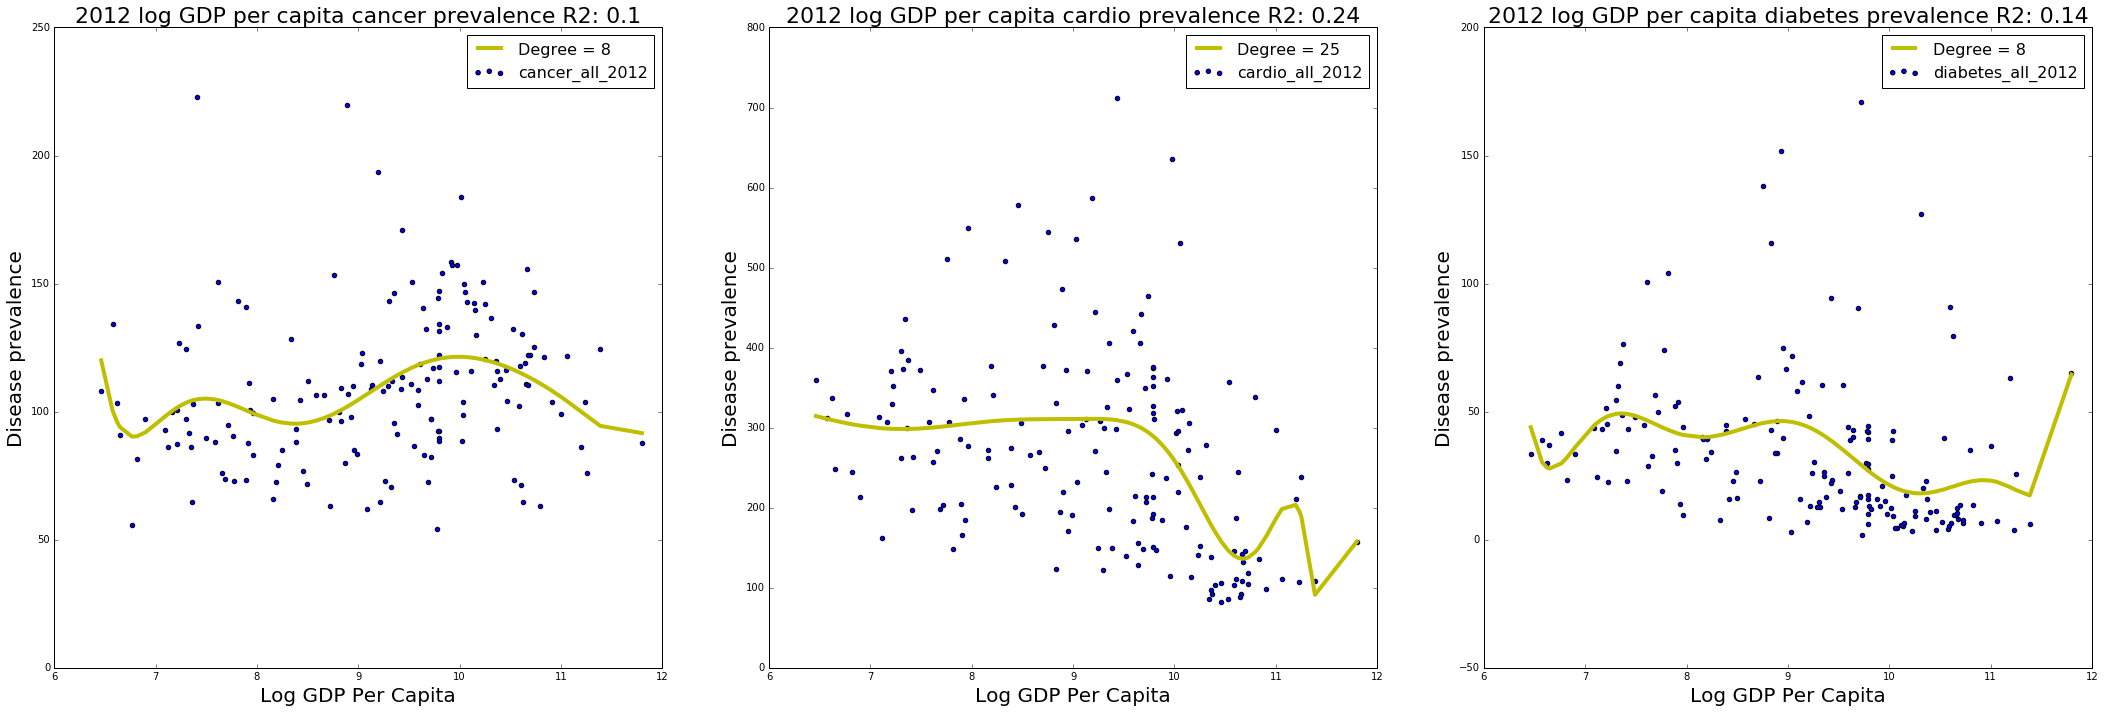

In [76]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
years=['2012']
diseases = ['cancer', 'cardio', 'diabetes']
ind=0
for d in diseases:
        
    for year in years:
        # Create x and y variables for every combination of disease and food category
        y = data_food_items[str(d)+"_"+"all_"+str(year)]
        x = np.log(data_food_items["gdppc_"+str(year)].values)
        
            
        best_deg, r_sq_max = fit_degrees(x, y, 30)
        ax[ind].scatter(x, y, c='b')
        ax[ind ]= fit_and_plot_polynomial(ax[ind], x, y, best_deg, 'y')
        
        ax[ind].set_title(str(year)+" log GDP per capita "+str(d)+" prevalence" + " R2: " + str(round(r_sq_max,2)), fontsize=22)
        ax[ind].set_xlabel('Log GDP Per Capita', fontsize=20)
        ax[ind].set_ylabel('Disease prevalence', fontsize=20)
        ax[ind].legend(loc='best', fontsize=16)
        ax[ind ].set_xlim([6, 12])
        ind += 1
        
plt.tight_layout()
plt.show() 

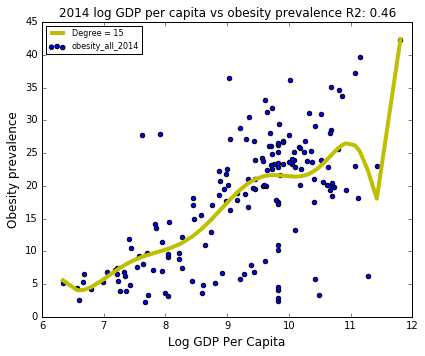

In [77]:
fig, ax = plt.subplots(1, figsize = (6, 5))
y = data_food_items["obesity_all_2014"]
x = np.log(data_food_items["gdppc_2014"].values)
            
best_deg, r_sq_max = fit_degrees(x, y, 30)
ax.scatter(x, y, c='b')
ax= fit_and_plot_polynomial(ax, x, y, best_deg, 'y')
        
ax.set_title("2014 log GDP per capita vs obesity prevalence" + " R2: " + str(round(r_sq_max,2)), fontsize=12)
ax.set_xlabel('Log GDP Per Capita', fontsize=12)
ax.set_ylabel('Obesity prevalence', fontsize=12)
ax.legend(loc='best', fontsize=8)
ax.set_xlim([6, 12])
        
plt.tight_layout()
plt.show()

For obesity prevalence we can clearly observe that there is an upward trend as GDP increases. For cardiovascluar diseases, we can see that there is a discontinuity and a drop in mortality after log GDP per capita of 11. For cancer, although we cannot make conclusions, we can say that middle-income countries have higher mortality rates.

## 2.4 Disease statistics and health expenditure

In [83]:
ind = {[0,0], [0,1],[1,0], [1,1]}
ind[diseases.index('cancer')]

TypeError: unhashable type: 'list'

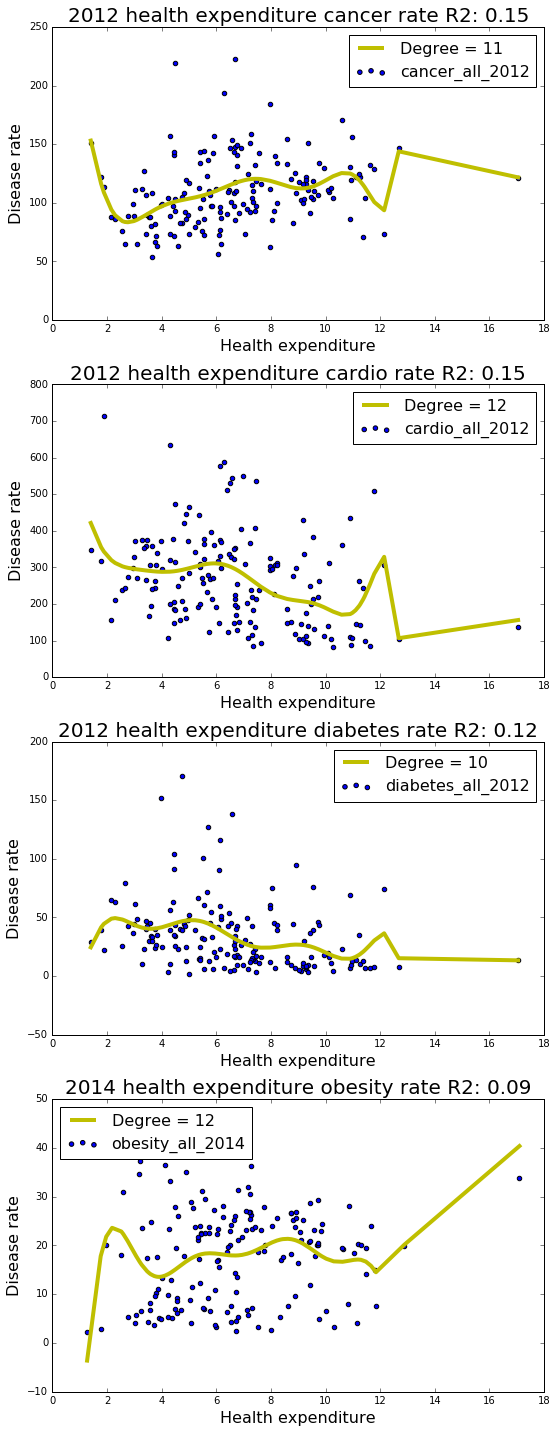

In [90]:
fig, ax = plt.subplots(4, 1, figsize = (8, 20))
years_ob = [2014]
years_rest = [2012]
diseases = ['cancer', 'cardio', 'diabetes', 'obesity']
ind = 0

for d in diseases:
    if d == 'obesity':
        years = years_ob
        year_h = 2013
    else:
        years = years_rest
        year_h = 2012
        
    for year in years:
        # Create x and y variables for every combination of disease and food category
        y = data_food_items[str(d)+"_"+"all_"+str(year)]
        x = data_food_items["health expenditure_"+str(year_h)]
                    
        best_deg, r_sq_max = fit_degrees(x, y, 30)
        ax[ind].scatter(x, y, c='b')
        ax[ind]= fit_and_plot_polynomial(ax[ind], x, y, best_deg, 'y')
        
        ax[ind].set_title(str(year)+" health expenditure "+str(d)+" rate" + " R2: " + str(round(r_sq_max,2)), fontsize=20)
        ax[ind].set_xlabel('Health expenditure', fontsize=16)
        ax[ind].set_ylabel('Disease rate', fontsize=16)
        ax[ind].legend(loc='best', fontsize=16)
    
    ind = ind + 1
        
                
plt.tight_layout()
plt.show() 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
years=[2012]
year_o = 2014
diseases = ['diabetes']
#, 'cardio', 'diabetes']
ind=0
for d in diseases:
    for year in years:
        # Create x and y variables for every combination of disease and food category
        y = data_food_items[str(d)+"_"+"all_"+str(year)]
        x = data_food_items["health expenditure_"+str(year)]
        
            
        best_deg, r_sq_max = fit_degrees(x, y, 30)
        ax.scatter(x, y, c='b')
        ax= fit_and_plot_polynomial(ax, x, y, best_deg, 'y')
        
        ax.set_title(str(year) +" health expenditure and "+str(d)+" prevalence, " + "R2: " + str(round(r_sq_max,2)), fontsize=22)
        ax.set_xlabel('Health expenditure (% of GDP)', fontsize=20)
        ax.set_ylabel('Disease mortality (per 100,000)', fontsize=20)
        ax.legend(loc='best', fontsize=16)
        #ax.set_xlim([6, 12])
        ind += 1
        
plt.tight_layout()
plt.show() 

## 2.4 Disease statistics and food diversity

In this subsection we explore the relation between disease statistics and food diversity, as a proxy for the dietary diversity of an average individual in a country. 
Note: food diversity is defined as the number of food items that represent more than 0.05% of the total calorie consumption of the country, averaged for the previous ten years before the year of disease statistics. The variable is then normalized (with the maximum number of items equal to 1).

In [ ]:
# Define function to create scatterplots
def plot_scatter(data, d, plot_title, x_label, y_label, groups):
    #set up color map (one color per group number)
    
    #split [0, 1] in to as many parts as there are groups
    group_numbers = np.linspace(0, 1, groups) 
    #get a color map
    c_map = plt.get_cmap('winter') 
    #get a range of colors from color map
    c_norm  = colors.Normalize(vmin=0, vmax=group_numbers[-1])
    #get a map that maps a group number to a color
    number_map = cmx.ScalarMappable(norm=c_norm, cmap=c_map)
    
    dict_income_level = {2: 'Low', 3: 'Lower middle', 4: 'Upper middle', 5: 'High'}
    
    #plot points colored by their group number
    for group in xrange(groups):
        code = group + 2
        #convert a group number into a color using our map
        color = number_map.to_rgba(group_numbers[group])
        # define x and y
        x = data[data['income level code'] == code][pairings[1, d]].values
        y = data[data['income level code'] == code][pairings[0, d]].values
        #make a scatter plot of a specific group colored by its group number color
        axes[d].scatter(x, y, label='%s income' %dict_income_level.get(code), color=color, alpha = 0.5, s = 60)
    
    x_all = data[pairings[1, d]].values
    y_all = data[pairings[0, d]].values
    # perform linear regression
    x_all = x_all.reshape(-1,1)
    reg = Lin_Reg()
    reg.fit(x_all, y_all)
    y_hat = reg.predict(x_all)
    # create regression line
    axes[d].plot(x_all, y_hat, c='y', linewidth=2.0)
        
    axes[d].legend(loc='best')
    axes[d].set_title(plot_title) 
    axes[d].set_xlabel(x_label)
    axes[d].set_ylabel(y_label)

In [ ]:
# Disease prevalence

disease_list = ['cancer_all_2012', 'cardio_all_2012', 'diabetes_all_2012', 'obesity_all_2014']
short_list = ['country', 'income level code'] + disease_list
diversity_list = ['diversity_2002_2011', 'diversity_2002_2011', 'diversity_2002_2011', 'diversity_2004_2013']
pairings = np.array([disease_list, diversity_list])

#Create plot
fig, axes = plt.subplots(4, 1, figsize = (8,24))

for disease in disease_list:
    axes[disease_list.index(disease)] = plot_scatter(data_food_items, disease_list.index(disease), 
                                                     '{} vs. food {}'.format(disease, str(pairings[1, 
                                                     disease_list.index(disease)])), str(pairings[1, disease_list.index(disease)]),
                                                     disease, len(disease_list))

plt.tight_layout()
plt.savefig("disease_diversity")
plt.show()

The above graphs show disease diversity has a clear negative relation with cardiovascular disease, as well as a clear positive relation with obesity. There is no relation with cancer or diabetes. These results are compatible with existing research, which is not conclusive with regards to the impacts of dietary diversity on human health (De Oliveira et al, 2015). Indeed, a more diverse diet need not necessarily imply a greater diet quality or better methabolic health.

# 3. Modeling

## 3.1. Baseline model: Linear Regression

### 1.1. Baseline model: Linear Regression with individual food items 

For baseline model, we use simple linear regression model with only individual food items.

The food item data we use have two key features:
- Food elements (fat, protein and total kcal)
- Individual food items (e.g., apple, banana) We want to use both features because we want to know i) what food items are associated with diseases (using total kcal for each food items) ii) which food items are better for fat consumption and protein consumption to reduce disease mortality and prevalence

Thus, our key variables for baseline model are
- Predictors: Food element in Individual food items (e.g., fat in banana, protein in banana, total kcal in banana) consumed for the past decade (decade average from 2001-2011) by country
- Responses: 
i) Disease mortality rate for cancerin 2012 by country 
ii) Disease mortality rate for cardiovascularin 2012 by country 
iii) Disease mortality rate for diabetes in 2012 by country 
iv) Disease prevalence rate for obesity in 2012 by country

In [104]:
## Data Preparation ##

# Load consolidated data #
data_items = pd.read_csv('food_items_dec2000s.csv')

# Define y (response variable) x_food (food related predictors) and x (all predictors)
diseases = ['cancer_all_2000', 'diabetes_all_2000', 'cardio_all_2000', 'obesity_all_2010', \
            'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014', \
            'cancer_male_2000', 'diabetes_male_2000', 'cardio_male_2000', \
            'cancer_male_2012', 'diabetes_male_2012', 'cardio_male_2012', \
            'cancer_female_2000', 'diabetes_female_2000', 'cardio_female_2000', \
            'cancer_female_2012', 'diabetes_female_2012', 'cardio_female_2012']

# Food predictors
x_food = data_items.drop(data_items[diseases], 1)
x_food = x_food.drop('country', 1) 
x_food = x_food.drop('iso', 1)
x_food = x_food.drop('income level code', 1)
x_food = x_food.drop(x_food.filter(regex='gdp'), 1)
x_food = x_food.drop(x_food.filter(regex='total_'), 1)
x_food = x_food.drop(x_food.filter(regex='weight'), 1)
x_food = x_food.drop(x_food.filter(regex='health'), 1)
x_food = x_food.drop(x_food.filter(regex='diversity'), 1)
x_food = x_food.drop(x_food.filter(regex='population'), 1)
x_food = x_food.drop(x_food[[0]], 1)

In [105]:
# Add constant 
x_food = sm.add_constant(x_food)

In [106]:
# For baseline model, we will use latest disease prevalence data for four different diseases
diseases_2012 = [ 'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', \
                 'obesity_all_2014']

for disease in diseases_2012:
    locals()["y_"+str(disease)] = data_items[disease]

With limited number of observations, we decided to use **Leave one out** for the cross validation. By doing so, we will be available to deal with small number of observations 

In [107]:
## Cross-Validation: Leave one out

#--------  loo_mse
# A function for leave one out cross validation with Weighted Linear Regression 
# and PCA regress.
# Input: 
#      disease (disease name)
# Return: 
#      MSE leave one out

def loo_mse(x_train, y_train, disease):
    mse_res = []
    for i in range(1, 165, 1):
        index = int(i-1)
        y_train = pd.DataFrame(y_train)
        # Define training and testing samples
        y_train_loo = y_train[y_train.index != index]
        y_test_loo = y_train[y_train.index == index]
        
        x_train_loo = x_train[x_train.index != index]
        x_test_loo = x_train[x_train.index == index]
        
        # Fit the model
        ols = sm.OLS(y_train_loo, x_train_loo).fit()
        
        # Calculate MSE
        yhat =  ols.predict(x_test_loo)
        mse_res_aux = (y_test_loo.values - yhat)**2
        mse_res.append(mse_res_aux)
        ols_mse_res_df = pd.DataFrame(round(np.array(mse_res).mean(), 4), columns = ['MSE'], \
                     index = [str(disease)])  
        
    return ols_mse_res_df

In [108]:
## Summary results - Cross Validation
diseases_1 = ['diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014']

summary_ols_items = loo_mse(x_food, y_cancer_all_2012, 'cancer_all_2012')

for disease in diseases_1:
    temp = loo_mse(x_food, data_items[disease], disease)
    summary_ols_items = pd.concat([summary_ols_items, temp])
summary_ols_items =summary_ols_items.rename(columns = {'MSE':'OLS_items_MSE'})
summary_ols_items

,OLS_items_MSE
cancer_all_2012,58614.1562
diabetes_all_2012,112994.5802
cardio_all_2012,615916.8554
obesity_all_2014,64258.3358


In [109]:
## Coefficients 
def coef_comparison(x, y, disease):
    # Fit the model
    model = sm.OLS(y, x).fit()
    coef = model.params
        
    predictors = [i for i, item in enumerate(coef)] 
    features = []
    for i in predictors:
        features.append(x.columns[i]) 
    coef_sel=[]
    for i in predictors:
        coef_sel.append(coef[i])
        
    # Store coefficients in matrix
    coefficients = pd.DataFrame(features, columns = ["Predictor name"])
    coefficients['Coefficient'] = [round(float(i), 6) for i in coef_sel]
    # How to separate protein, fat and kcal? 
    coefficients = coefficients.sort_values(by=["Coefficient"],ascending=1)
    coefficients_10 = coefficients[:10]
    return coefficients_10

In [110]:
for disease in diseases_2012: 
    coef_disease = coef_comparison(x_food, data_food_groups[disease], disease) 
    print "\n", "Coefficients for "+ disease 
    print coef_disease


Coefficients for cancer_all_2012
                             Predictor name  Coefficient
32          fat_Fish, Body Oil_Average_2000 -4028.778102
137             protein_Pepper_Average_2000 -3861.297713
142        fat_Freshwater Fish_Average_2000 -2017.219269
52                 fat_Bananas_Average_2000 -1098.897772
18   fat_Potatoes and products_Average_2000 -1040.987568
47           fat_Demersal Fish_Average_2000  -868.732473
65             fat_Crustaceans_Average_2000  -843.722684
40                protein_Beer_Average_2000  -825.259607
124         fat_Cereals, Other_Average_2000  -784.605822
126        protein_Cephalopods_Average_2000  -552.141900

Coefficients for diabetes_all_2012
                                        Predictor name  Coefficient
42                             fat_Onions_Average_2000 -1729.933056
90                        fat_Infant food_Average_2000 -1659.239178
43                fat_Apples and products_Average_2000 -1432.064885
137                        prot

For linear regression with all food items, the MSE seems to be very high probably because of high dimensionality issue. While so-called "healthy foods" seem to be negatively associated with disease mortality and prevalence, some of them are not statistically significant. Thus, it is requried to think about the way to drop those less significant predictors.

### 1.2 Baseline model: Linear Regression with food groups
For baseline model, we use **simple linear regression model** with food item groups (e.g., fruits, vegetables, meat)

Similar to the food item data, we use have two key features: 
1. Food elements (fat, protein and total kcal)
2. Food groups (e.g., fruits, vegetables)
We want to use both features because we want to know 

Thus, our key variables for baseline model are 
- **Predictors**: Food element in food groups (e.g., fat in fruits, protein in fruits, total kcal in fruits) consumed for the past decade (decade average from 2001-2011) by country 
- **Responses**: 
i) Disease mortality rate for cancerin 2012 by country 
i) Disease mortality rate for cardiovascularin 2012 by country 
i) Disease mortality rate for diabetes in 2012 by country 
i) Disease prevalence rate for obesity in 2012 by country 

In [111]:
### Data Preparation ###

## Load consolidated data 
data_groups = pd.read_csv('food_groups_dec2000s.csv')

## Define predictors
diseases = ['cancer_all_2000', 'diabetes_all_2000', 'cardio_all_2000', 'obesity_all_2010', \
            'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014', \
            'cancer_male_2000', 'diabetes_male_2000', 'cardio_male_2000', \
            'cancer_male_2012', 'diabetes_male_2012', 'cardio_male_2012', \
            'cancer_female_2000', 'diabetes_female_2000', 'cardio_female_2000', \
            'cancer_female_2012', 'diabetes_female_2012', 'cardio_female_2012']
       
x_food_groups = data_groups.drop(data_groups[diseases], 1)
x_food_groups = x_food_groups.drop('country', 1)
x_food_groups = x_food_groups.drop('iso', 1)
x_food_groups = x_food_groups.drop('income level code', 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='weight'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='population'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='gdp'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='weight'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='health'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='diversity'), 1)
x_food_groups = x_food_groups.drop(x_food_groups.filter(regex='total_'), 1)
x_food_groups = x_food_groups.drop(x_food_groups[[0]], 1)

In [112]:
# For baseline model, we will use latest disease prevalence data for four different diseases
diseases_2012 = [ 'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', \
                 'obesity_all_2014']

for disease in diseases_2012:
    locals()["y_"+str(disease)] = data_groups[disease]
    
# Add constant 
x_food_groups = sm.add_constant(x_food_groups)

In [113]:
## Summary results - Cross Validation
summary_ols_groups = loo_mse(x_food_groups, y_cancer_all_2012, 'cancer_all_2012')

for disease in diseases_1:
    temp = loo_mse(x_food_groups, data_groups[disease], disease)
    summary_ols_groups = pd.concat([summary_ols_groups, temp])
summary_ols_groups =summary_ols_groups.rename(columns = {'MSE':'OLS_groups_MSE'})
summary_ols_groups

,OLS_groups_MSE
cancer_all_2012,3247.1262
diabetes_all_2012,3496.9941
cardio_all_2012,26767.3354
obesity_all_2014,201.3190


In [114]:
summary_ols = pd.concat([summary_ols_items, summary_ols_groups], axis = 1)
summary_ols

,OLS_items_MSE,OLS_groups_MSE
cancer_all_2012,58614.1562,3247.1262
diabetes_all_2012,112994.5802,3496.9941
cardio_all_2012,615916.8554,26767.3354
obesity_all_2014,64258.3358,201.3190


When uisng food groups data (instead of individual food items), MSE is smaller. This makes sense because food group data has fewer predictors than individual food item data.

In [115]:
for disease in diseases_2012: 
    coef_disease = coef_comparison(x_food_groups, data_groups[disease], disease) 
    print "\n", "Coefficients for "+ disease 
    print coef_disease


Coefficients for cancer_all_2012
                                  Predictor name  Coefficient
7       fat_Aquatic Products, Other_Average_2000 -2142.870246
28              protein_Animal fats_Average_2000  -704.347102
5                      protein_Meat_Average_2000  -695.209013
90            protein_Fish, Seafood_Average_2000  -660.905861
80  protein_Milk - Excluding Butter_Average_2000  -651.377338
9                      protein_Eggs_Average_2000  -536.690575
25           protein_Offals, Edible_Average_2000  -331.633678
35                   protein_Offals_Average_2000  -331.633678
32              fat_Animal Products_Average_2000  -330.670931
15           fat_Mutton & Goat Meat_Average_2000  -213.513557

Coefficients for diabetes_all_2012
                              Predictor name  Coefficient
7   fat_Aquatic Products, Other_Average_2000 -2261.722268
8       protein_Animal Products_Average_2000  -834.617980
15       fat_Mutton & Goat Meat_Average_2000  -418.955187
44              

## 3.2 Weighted Linear Regression 

### 3.2.1 Weighted Linear Regression - individual food items 

In the baseline model, we have several issues 
1. While observations (countries) have different population, they are not considered in the model. Thus, we will use population share of a country out of the total population in our sample as a ***weight for linear regression model***

2. We only included food items and food groups, but there might be other important predictors to predict disease indicators. As we have shown in the data exploration part, income level seems to be critical as a channel thorugh which food conusmption patterns affect to disease prevalence or disease mortality. Thus, we inlcuded other socio-econ data including income level (GDP per captia ) and health expenditure

3. Obviously, we also have high dimensionality issue: While the number of obeservations is limited (n =165), the number of food items is almost 160

We first try weigthed linear regression model with additional variables. Then by using Lasso and PCA, we will address high dimensionality issue 

In [116]:
# Keep only three years for socio-econ data
econ = ['gdppc_2011', 'gdppc_2012', \
              'health expenditure_2010', 'health expenditure_2011', 'health expenditure_2012']

data_econ = data_items['gdppc_2010']

for e in econ: 
    econ_e = data_items[e]
    data_econ = pd.concat([data_econ, econ_e], axis=1)

# All predictors
x = data_items.drop(data_items[diseases], 1)
x = x.drop('country', 1)
x = x.drop('iso', 1)
x = x.drop('income level code', 1)
x = x.drop('diversity_2004_2013', 1)
x = x.drop(x.filter(regex='weight'), 1)
x = x.drop(x.filter(regex='population'), 1)
x = x.drop(x.filter(regex='total_'), 1)
x = x.drop(x.filter(regex='gdppc'), 1)
x = x.drop(x.filter(regex='health'), 1)
x = x.drop(x[[0]], 1)
x = pd.concat([x, data_econ], axis = 1)

In [118]:
# Weight (population share)
weight = data_items.filter(regex='weight')

# Add constant 
x = sm.add_constant(x)

In [119]:
## Cross-Validation: Leave one out

#--------  loo_mse
# A function for leave one out cross validation with Weighted Linear Regression 
# and PCA regress.
# Input: 
#      disease (disease name)
# Return: 
#      MSE leave one out

def loo_mse_w(x_train, y_train, disease):
    mse_res = []
    for i in range(1, 165, 1):
        index = int(i-1)
        y_train = pd.DataFrame(y_train)
        # Define training and testing samples
        y_train_loo = y_train[y_train.index != index]
        y_test_loo = y_train[y_train.index == index]
        
        x_train_loo = x_train[x_train.index != index]
        x_test_loo = x_train[x_train.index == index]
        
        # Fit the model
        wls = sm.WLS(y_train_loo, x_train_loo, weight = weight).fit()
        
        # Calculate MSE
        yhat =  wls.predict(x_test_loo)
        mse_res_aux = (y_test_loo.values - yhat)**2
        mse_res.append(mse_res_aux)
        wls_mse_res_df = pd.DataFrame(round(np.array(mse_res).mean(), 4), columns = ['MSE'], \
                     index = [str(disease)])  
        
    return wls_mse_res_df

In [120]:
## Summary results 
summary_wls_items = loo_mse_w(x, y_cancer_all_2012, 'cancer_all_2012')

for disease in diseases_1:
    temp = loo_mse_w(x, data_items[disease], disease)
    summary_wls_items = pd.concat([summary_wls_items, temp])
summary_wls_items =summary_wls_items.rename(columns = {'MSE':'WLS_items_MSE'})
summary_wls_items

,WLS_items_MSE
cancer_all_2012,143110.9083
diabetes_all_2012,6684.2786
cardio_all_2012,68185.0966
obesity_all_2014,290804.9302


In [121]:
## Coefficients 
def coef_comparison(x, y, disease):
    # Fit the model
    model = sm.WLS(y, x, weight = weight ).fit()
    coef = model.params
        
    predictors = [i for i, item in enumerate(coef)] 
    features = []
    for i in predictors:
        features.append(x.columns[i]) 
    coef_sel=[]
    for i in predictors:
        coef_sel.append(coef[i])    
        
    # Store coefficients in matrix
    coefficients = pd.DataFrame(features, columns = ["Predictor name"])
    coefficients['Coefficient'] = [round(float(i), 6) for i in coef_sel]
    
    coefficients = coefficients.sort_values(by=["Coefficient"],ascending=1)
    coefficients_10 = coefficients[:10]
    return coefficients_10

In [122]:
for disease in diseases_2012: 
    coef_disease = coef_comparison(x_food, data_items[disease], disease) 
    print "\n", "Coefficients for "+ disease 
    print coef_disease


Coefficients for cancer_all_2012
                             Predictor name  Coefficient
32          fat_Fish, Body Oil_Average_2000 -4028.778102
137             protein_Pepper_Average_2000 -3861.297713
142        fat_Freshwater Fish_Average_2000 -2017.219269
52                 fat_Bananas_Average_2000 -1098.897772
18   fat_Potatoes and products_Average_2000 -1040.987568
47           fat_Demersal Fish_Average_2000  -868.732473
65             fat_Crustaceans_Average_2000  -843.722684
40                protein_Beer_Average_2000  -825.259607
124         fat_Cereals, Other_Average_2000  -784.605822
126        protein_Cephalopods_Average_2000  -552.141900

Coefficients for diabetes_all_2012
                                        Predictor name  Coefficient
42                             fat_Onions_Average_2000 -1729.933056
90                        fat_Infant food_Average_2000 -1659.239178
43                fat_Apples and products_Average_2000 -1432.064885
137                        prot

### 3.2.2 Weighted Linear Regression -  food groups

In [123]:
# All predictors
x_groups = data_groups.drop(data_groups[diseases], 1)
x_groups = x_groups.drop('country', 1)
x_groups = x_groups.drop('iso', 1)
x_groups = x_groups.drop('income level code', 1)
x_groups = x_groups.drop('diversity_2004_2013', 1)
x_groups = x_groups.drop(x_groups.filter(regex='weight'), 1)
x_groups = x_groups.drop(x_groups.filter(regex='population'), 1)
x_groups = x_groups.drop(x_groups.filter(regex='total_'), 1)
x_groups = x_groups.drop(x_groups.filter(regex='gdppc'), 1)
x_groups = x_groups.drop(x_groups.filter(regex='health'), 1)
x_groups = x_groups.drop(x_groups[[0]], 1)
x_groups = pd.concat([x_groups, data_econ], axis = 1)

# Add constant 
x_groups = sm.add_constant(x_groups)

In [124]:
## Summary results 
summary_wls_groups = loo_mse_w(x_groups, y_cancer_all_2012, 'cancer_all_2012')

for disease in diseases_1:
    temp = loo_mse_w(x_groups, data_groups[disease], disease)
    summary_wls_groups = pd.concat([summary_wls_groups, temp])

summary_wls_groups =summary_wls_groups.rename(columns = {'MSE':'WLS_groups_MSE'})
summary_wls = pd.concat([summary_wls_items, summary_wls_groups], axis = 1)
summary_ols_wls = pd.concat([summary_ols, summary_wls], axis = 1)
summary_ols_wls

,OLS_items_MSE,OLS_groups_MSE,WLS_items_MSE,WLS_groups_MSE
cancer_all_2012,58614.1562,3247.1262,143110.9083,4041.8983
diabetes_all_2012,112994.5802,3496.9941,6684.2786,3495.7813
cardio_all_2012,615916.8554,26767.3354,68185.0966,23211.5916
obesity_all_2014,64258.3358,201.3190,290804.9302,468.4006


Similar to OLS, MSE in WLS is lower for group data than item data. 
Weighted linear regression models do not seem to improve prediction power much comparing to OLS models for two reasons.   
First, WLS does not solve high dimensionality issues 
Second, we added more predictors (socio-econ data)

In [125]:
# Coefficeints 
for disease in diseases_2012: 
    coef_disease = coef_comparison(x_food, data_items[disease], disease) 
    print "\n", "Coefficients for "+ disease 
    print coef_disease


Coefficients for cancer_all_2012
                             Predictor name  Coefficient
32          fat_Fish, Body Oil_Average_2000 -4028.778102
137             protein_Pepper_Average_2000 -3861.297713
142        fat_Freshwater Fish_Average_2000 -2017.219269
52                 fat_Bananas_Average_2000 -1098.897772
18   fat_Potatoes and products_Average_2000 -1040.987568
47           fat_Demersal Fish_Average_2000  -868.732473
65             fat_Crustaceans_Average_2000  -843.722684
40                protein_Beer_Average_2000  -825.259607
124         fat_Cereals, Other_Average_2000  -784.605822
126        protein_Cephalopods_Average_2000  -552.141900

Coefficients for diabetes_all_2012
                                        Predictor name  Coefficient
42                             fat_Onions_Average_2000 -1729.933056
90                        fat_Infant food_Average_2000 -1659.239178
43                fat_Apples and products_Average_2000 -1432.064885
137                        prot

## 3.3. Lasso model

### 3.3.1 Lasso with individual food items 

In [131]:
# Standarization 
std_scale = StandardScaler().fit(x)
x_st = std_scale.transform(x)
x = pd.DataFrame(x_st, columns = [x.columns])

In [132]:
## Cross-Validation: Leave one out

#--------  loo_mse
# A function for leave one out cross validation with Weighted Linear Regression 
# and PCA regress.
# Input: 
#      disease (disease name)
# Return: 
#      MSE leave one out

def loo_mse_lasso(x_train, y_train, disease, c):
    mse_res = []
    for i in range(1, 165, 1):
        index = int(i-1)
        y_train = pd.DataFrame(y_train)
        # Define training and testing samples
        y_train_loo = y_train[y_train.index != index]
        y_test_loo = y_train[y_train.index == index]
        
        x_train_loo = x_train[x_train.index != index]
        x_test_loo = x_train[x_train.index == index]
        
        # Fit the model
        model = Lasso_Reg(alpha = c)
        lasso = model.fit(x_train_loo, y_train_loo)
        
         # Calculate MSE
        yhat =  lasso.predict(x_test_loo)
        mse_res_aux = (y_test_loo.values - yhat)**2
        mse_res.append(mse_res_aux)
        mse = round(np.array(mse_res).mean(),4) 
        
    return mse

In [134]:
### Find optimal tuning parameter c for each disease 
## For cancer 
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x, y_cancer_all_2012, 'cancer_all_2012', 0.00001)
lasso_df_cancer = pd.DataFrame(round(np.array(mse_1),4), columns =["cancer_all_2012"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x, y_cancer_all_2012, 'cancer_all_2012', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["cancer_all_2012"], index = [str(c)])
    lasso_df_cancer = pd.concat([lasso_df_cancer, lasso_df_c])

In [135]:
c_opt_cancer = lasso_df_cancer.idxmin()
c_opt_mse_cancer = lasso_df_cancer.min()
c_opt_cancer_df_1 = pd.DataFrame(c_opt_cancer, columns = ["optimal c"], index = ["cancer_all_2012"])
c_opt_cancer_df_2 = pd.DataFrame(c_opt_mse_cancer, columns = ["mse_items"], index = ["cancer_all_2012"])
c_opt_cancer_df = pd.concat([c_opt_cancer_df_1, c_opt_cancer_df_2], axis = 1)

c_opt_cancer_df

,optimal c,mse_items
cancer_all_2012,1,569.8523


In [136]:
### For cardio 
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x, y_cardio_all_2012, 'cardio_all_2012', 0.00001)
lasso_df_cardio = pd.DataFrame(round(np.array(mse_1),4), columns =["cardio_all_2012"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x, y_cardio_all_2012, 'cardio_all_2012', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["cardio_all_2012"], index = [str(c)])
    lasso_df_cardio = pd.concat([lasso_df_cardio, lasso_df_c], axis = 0)
    
c_opt_cardio = lasso_df_cardio.idxmin()
c_opt_mse_cardio = lasso_df_cardio.min()
c_opt_cardio_df_1 = pd.DataFrame(c_opt_cardio, columns = ["optimal c"], index = ["cardio_all_2012"])
c_opt_cardio_df_2 = pd.DataFrame(c_opt_mse_cardio, columns = ["mse_items"], index = ["cardio_all_2012"])
c_opt_cardio_df = pd.concat([c_opt_cardio_df_1, c_opt_cardio_df_2], axis = 1)

c_opt_cardio_df

,optimal c,mse_items
cardio_all_2012,10,7724.7707


In [137]:
### For diabetes
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x, y_diabetes_all_2012, 'diabetes_all_2012', 0.00001)
lasso_df_diabetes = pd.DataFrame(round(np.array(mse_1),4), columns =["diabetes_all_2012"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x, y_diabetes_all_2012, 'diabetes_all_2012', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["diabetes_all_2012"], index = [str(c)])
    lasso_df_diabetes = pd.concat([lasso_df_diabetes, lasso_df_c], axis = 0)
    
c_opt_diabetes = lasso_df_diabetes.idxmin()
c_opt_mse_diabetes = lasso_df_diabetes.min()
c_opt_diabetes_df_1 = pd.DataFrame(c_opt_diabetes, columns = ["optimal c"], index = ["diabetes_all_2012"])
c_opt_diabetes_df_2 = pd.DataFrame(c_opt_mse_diabetes, columns = ["mse_items "], index = ["diabetes_all_2012"])
c_opt_diabetes_df = pd.concat([c_opt_diabetes_df_1, c_opt_diabetes_df_2], axis = 1)

c_opt_diabetes_df

,optimal c,mse_items
diabetes_all_2012,1,626.309


In [138]:
### For obesity 
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x, y_obesity_all_2014, 'y_obesity_all_2014', 0.00001)
lasso_df_obesity = pd.DataFrame(round(np.array(mse_1),4), columns =["obesity_all_2014"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x, y_obesity_all_2014, 'obesity_all_2014', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["obesity_all_2014"], index = [str(c)])
    lasso_df_obesity = pd.concat([lasso_df_obesity, lasso_df_c], axis = 0)
    
c_opt_obesity = lasso_df_obesity.idxmin()
c_opt_mse_obesity = lasso_df_obesity.min()
c_opt_obesity_df_1 = pd.DataFrame(c_opt_obesity, columns = ["optimal c"], index = ["obesity_all_2014"])
c_opt_obesity_df_2 = pd.DataFrame(c_opt_mse_obesity, columns = ["mse_items"], index = ["obesity_all_2014"])
c_opt_obesity_df = pd.concat([c_opt_obesity_df_1, c_opt_obesity_df_2], axis = 1)

c_opt_obesity_df

,optimal c,mse_items
obesity_all_2014,1,46.1434


In [139]:
c_opt_df_items = pd.concat([c_opt_cancer_df, c_opt_cardio_df, c_opt_diabetes_df, c_opt_obesity_df])
c_opt_df_items

,mse_items,mse_items,optimal c
cancer_all_2012,569.8523,NaN,1
cardio_all_2012,7724.7707,NaN,10
diabetes_all_2012,NaN,626.309,1
obesity_all_2014,46.1434,NaN,1


In [141]:
## Coefficients 
def coef_comparison(x, y, disease, c):
    # Fit the model
    model = Lasso_Reg(alpha = c)
    lasso = model.fit(x, y)
    coef = lasso.coef_
        
    predictors = [i for i, item in enumerate(coef)] 
    features = []
    for i in predictors:
        features.append(x.columns[i]) 
    coef_sel=[]
    for i in predictors:
        coef_sel.append(coef[i])
        
    # Store coefficients in matrix
    coefficients = pd.DataFrame(features, columns = ["Predictor name"])
    coefficients['Coefficient'] = [round(float(i), 6) for i in coef_sel]
    # How to separate protein, fat and kcal? 
    coefficients = coefficients.sort_values(by=["Coefficient"],ascending=1)
    return coefficients

In [142]:
##With the optimal tuning parameter, get coefficients by disease and by food elements 
# Cancer 
coef_cancer = coef_comparison(x, y_cancer_all_2012, 'cancer_all_2012', 1) 
kcal_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("kcal")]
kcal_coef_cancer_10 = kcal_coef_cancer [:10]

fat_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("fat")]
fat_coef_cancer_10 = fat_coef_cancer [:10]

protein_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("protein")]
protein_coef_cancer_10 = protein_coef_cancer [:10]

# Cardio 
coef_cardio = coef_comparison(x, y_cardio_all_2012, 'cardio_all_2012', 10) 
kcal_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("kcal")]
kcal_coef_cardio_10 = kcal_coef_cardio [:10]

fat_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("fat")]
fat_coef_cardio_10 = fat_coef_cardio [:10]

protein_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("protein")]
protein_coef_cardio_10 = protein_coef_cardio [:10]

# Diabetes 
coef_diabetes = coef_comparison(x, y_diabetes_all_2012, 'diabetes_all_2012', 1) 
kcal_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("kcal")]
kcal_coef_diabetes_10 = kcal_coef_diabetes [:10]

fat_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("fat")]
fat_coef_diabetes_10 = fat_coef_diabetes [:10]

protein_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("protein")]
protein_coef_diabetes_10 = protein_coef_diabetes[:10]

# Obetsity 
coef_obesity = coef_comparison(x, y_obesity_all_2014, 'obesity_all_2014', 1) 
kcal_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("kcal")]
kcal_coef_obesity_10 = kcal_coef_obesity [:10]

fat_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("fat")]
fat_coef_obesity_10 = fat_coef_obesity [:10]

protein_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("protein")]
protein_coef_obesity_10 = protein_coef_obesity [:10]

<function matplotlib.pyplot.show>

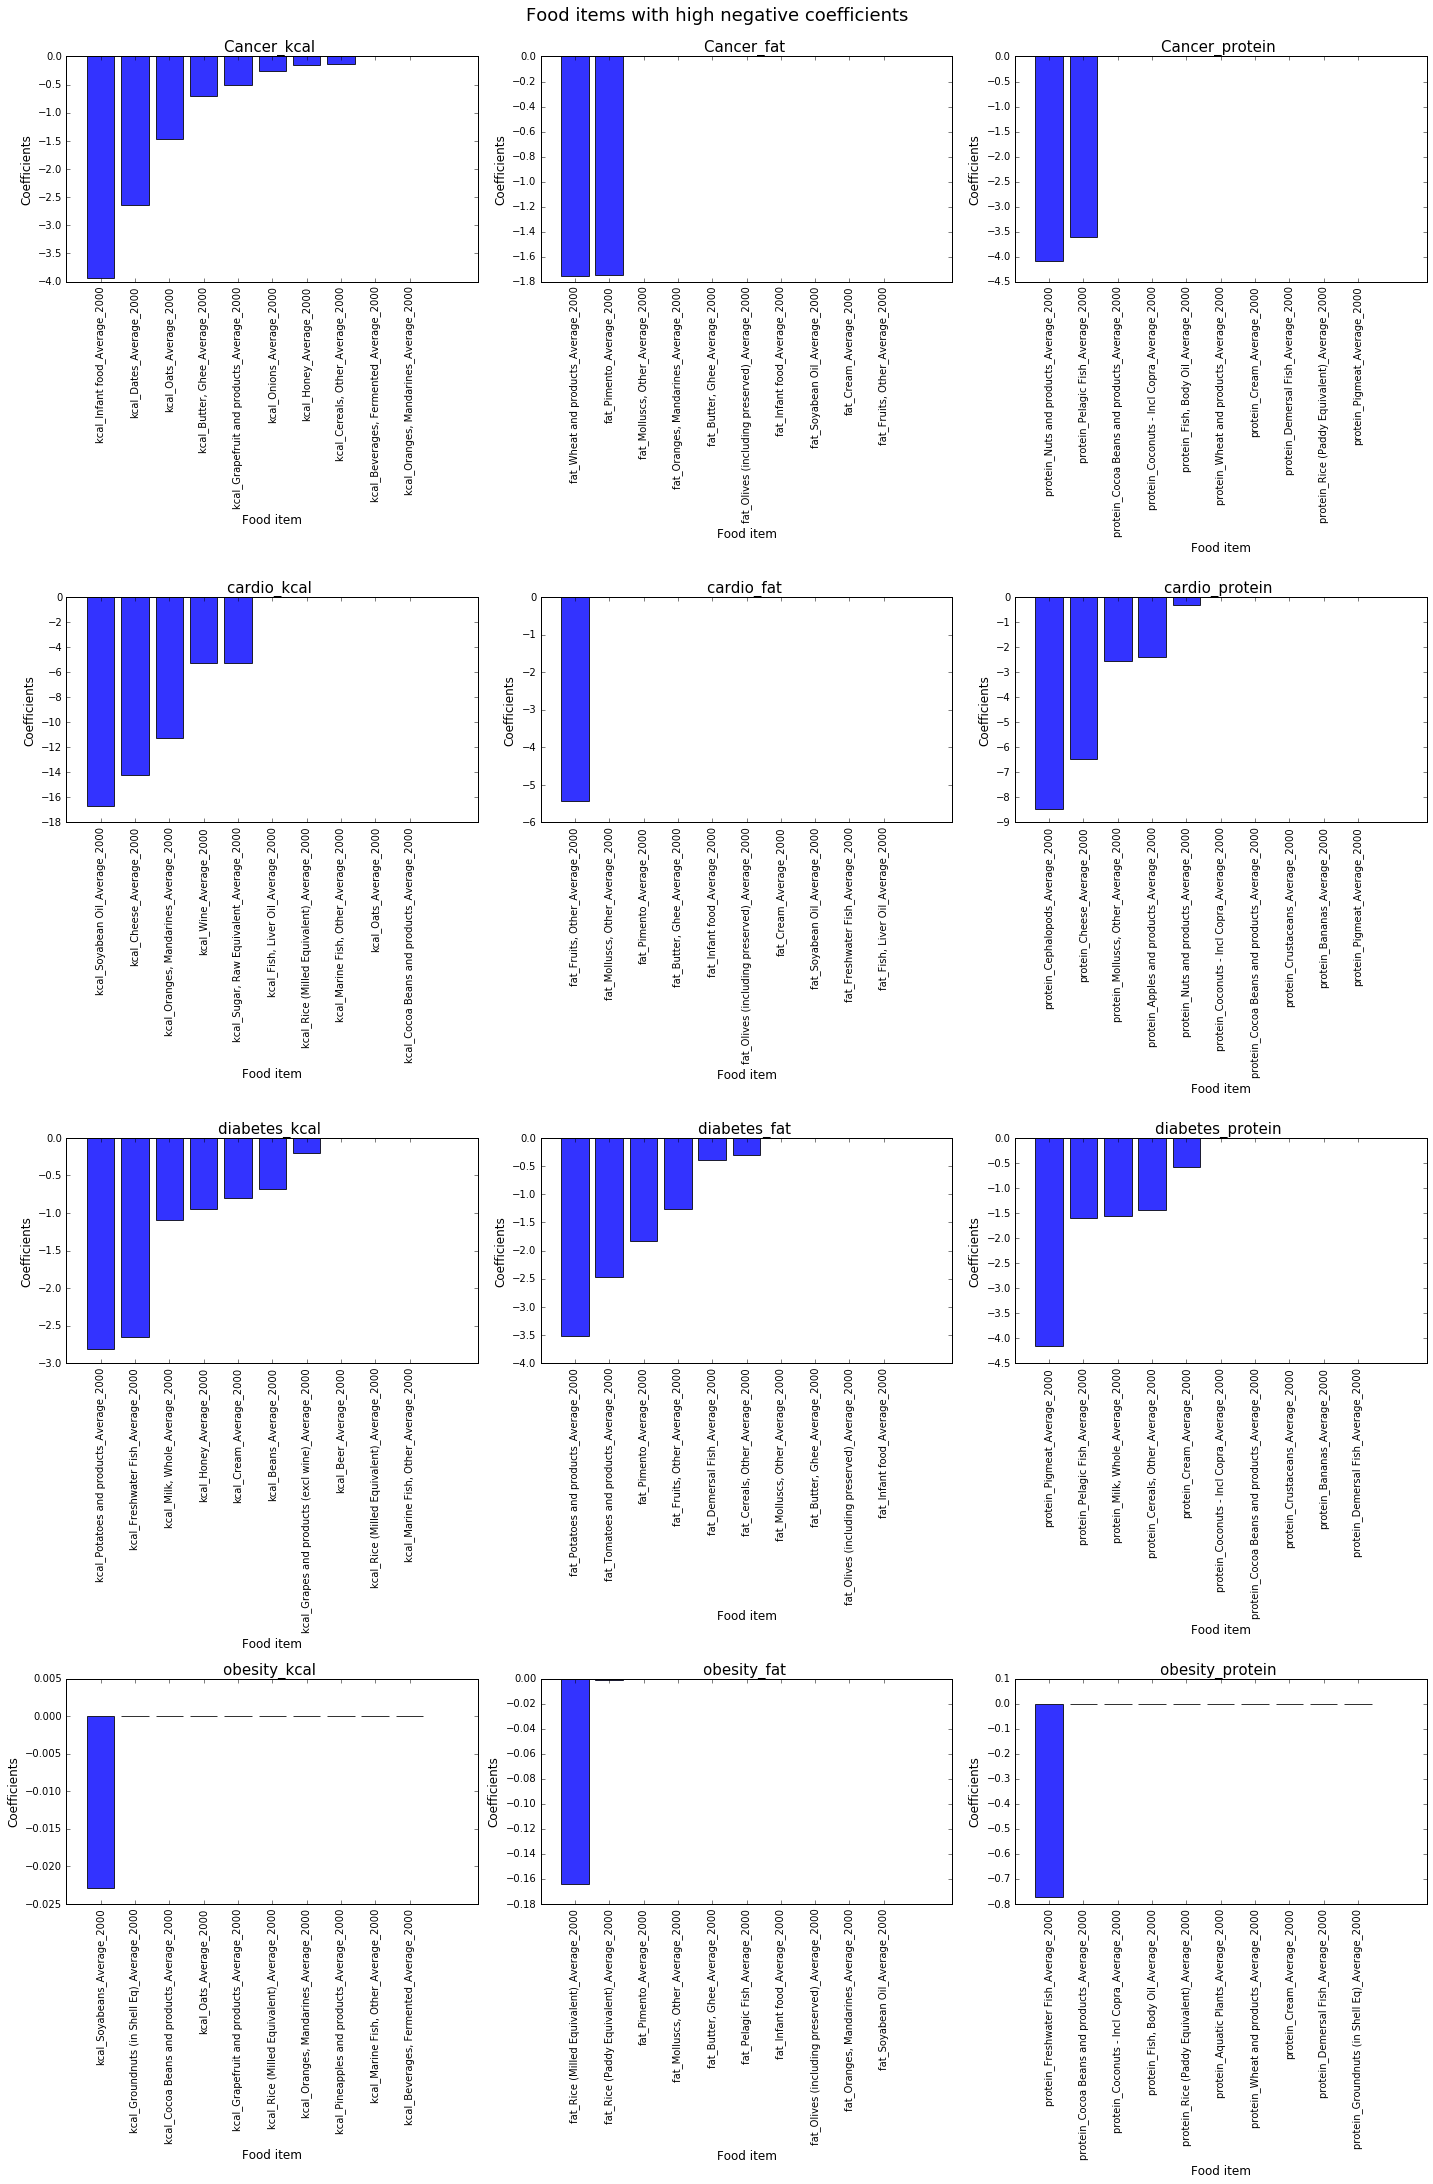

In [143]:
# Make a graphs for coeffients 
fig, ax = plt.subplots(4, 3, figsize = (20, 30))

# Cancer 
ax[0,0].bar(range(1, 11, 1), kcal_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,0].set_ylabel('Coefficients', size = 12)
ax[0,0].set_xlabel('Food item', size = 12)
ax[0,0].set_title("Cancer_kcal ", size = 15)
ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(kcal_coef_cancer_10["Predictor name"], rotation=90)

ax[0,1].bar(range(1, 11, 1), fat_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,1].set_ylabel('Coefficients', size = 12)
ax[0,1].set_xlabel('Food item', size = 12)
ax[0,1].set_title("Cancer_fat ", size = 15)
ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(fat_coef_cancer_10["Predictor name"], rotation=90)

ax[0,2].bar(range(1, 11, 1), protein_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,2].set_ylabel('Coefficients', size = 12)
ax[0,2].set_xlabel('Food item', size = 12)
ax[0,2].set_title("Cancer_protein ", size = 15)
ax[0,2].set_xticks(range(1, 11, 1))
ax[0,2].set_xticklabels(protein_coef_cancer_10["Predictor name"], rotation=90)

# Cardio
ax[1,0].bar(range(1, 11, 1), kcal_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,0].set_ylabel('Coefficients', size = 12)
ax[1,0].set_xlabel('Food item', size = 12)
ax[1,0].set_title("cardio_kcal ", size = 15)
ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(kcal_coef_cardio_10["Predictor name"], rotation=90)

ax[1,1].bar(range(1, 11, 1), fat_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,1].set_ylabel('Coefficients', size = 12)
ax[1,1].set_xlabel('Food item', size = 12)
ax[1,1].set_title("cardio_fat ", size = 15)
ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(fat_coef_cardio_10["Predictor name"], rotation=90)

ax[1,2].bar(range(1, 11, 1), protein_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,2].set_ylabel('Coefficients', size = 12)
ax[1,2].set_xlabel('Food item', size = 12)
ax[1,2].set_title("cardio_protein ", size = 15)
ax[1,2].set_xticks(range(1, 11, 1))
ax[1,2].set_xticklabels(protein_coef_cardio_10["Predictor name"], rotation=90)

# Diabetes 
ax[2,0].bar(range(1, 11, 1), kcal_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,0].set_ylabel('Coefficients', size = 12)
ax[2,0].set_xlabel('Food item', size = 12)
ax[2,0].set_title("diabetes_kcal ", size = 15)
ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(kcal_coef_diabetes_10["Predictor name"], rotation=90)

ax[2,1].bar(range(1, 11, 1), fat_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,1].set_ylabel('Coefficients', size = 12)
ax[2,1].set_xlabel('Food item', size = 12)
ax[2,1].set_title("diabetes_fat ", size = 15)
ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(fat_coef_diabetes_10["Predictor name"], rotation=90)

ax[2,2].bar(range(1, 11, 1), protein_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,2].set_ylabel('Coefficients', size = 12)
ax[2,2].set_xlabel('Food item', size = 12)
ax[2,2].set_title("diabetes_protein ", size = 15)
ax[2,2].set_xticks(range(1, 11, 1))
ax[2,2].set_xticklabels(protein_coef_diabetes_10["Predictor name"], rotation=90)

# Diabetes 
ax[3,0].bar(range(1, 11, 1), kcal_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,0].set_ylabel('Coefficients', size = 12)
ax[3,0].set_xlabel('Food item', size = 12)
ax[3,0].set_title("obesity_kcal ", size = 15)
ax[3,0].set_xticks(range(1, 11, 1))
ax[3,0].set_xticklabels(kcal_coef_obesity_10["Predictor name"], rotation=90)

ax[3,1].bar(range(1, 11, 1), fat_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,1].set_ylabel('Coefficients', size = 12)
ax[3,1].set_xlabel('Food item', size = 12)
ax[3,1].set_title("obesity_fat ", size = 15)
ax[3,1].set_xticks(range(1, 11, 1))
ax[3,1].set_xticklabels(fat_coef_obesity_10["Predictor name"], rotation=90)

ax[3,2].bar(range(1, 11, 1), protein_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,2].set_ylabel('Coefficients', size = 12)
ax[3,2].set_xlabel('Food item', size = 12)
ax[3,2].set_title("obesity_protein ", size = 15)
ax[3,2].set_xticks(range(1, 11, 1))
ax[3,2].set_xticklabels(protein_coef_obesity_10["Predictor name"], rotation=90)

plt.tight_layout()
plt.suptitle("Food items with high negative coefficients", y=1.01, fontsize=18)
plt.show

We listed high negative coefficients. Listed food items are negatively correlated with the disease prevalence or disease mortality rate. This means that the more a country consumes the food items listed, the less disease mortality or prevalence it would observe. For instance, more food consumption of soybean oil in a country is associated with less cardiovascular mortality rate.
Since Lasso selected only significant predictors, some of the diseases do not have many predictors (e.g., obesity). This solves the high dimensionalit yissue.

### 3.3.2 Lasso with  food groups 

In [145]:
std_scale = StandardScaler().fit(x_groups)
x_groups_st = std_scale.transform(x_groups)
x_groups = pd.DataFrame(x_groups_st, columns = [x_groups.columns])

In [146]:
### For cancer 
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x_groups, y_cancer_all_2012, 'cancer_all_2012', 0.00001)
lasso_df = pd.DataFrame(round(np.array(mse_1),4), columns =["cancer_all_2012"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x_groups, y_cancer_all_2012, 'cancer_all_2012', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["cancer_all_2012"], index = [str(c)])
    lasso_df_cancer = pd.concat([lasso_df_cancer, lasso_df_c], axis = 0)
    
c_opt_cancer = lasso_df_cancer.idxmin()
c_opt_mse_cancer = lasso_df_cancer.min()
c_opt_cancer_df_1 = pd.DataFrame(c_opt_cancer, columns = ["optimal c"], index = ["cancer_all_2012"])
c_opt_cancer_df_2 = pd.DataFrame(c_opt_mse_cancer, columns = ["mse_groups"], index = ["cancer_all_2012"])
c_opt_cancer_df = pd.concat([c_opt_cancer_df_1, c_opt_cancer_df_2], axis = 1)

c_opt_cancer_df

,optimal c,mse_groups
cancer_all_2012,1,569.8523


In [147]:
### For diabetes
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x_groups, y_diabetes_all_2012, 'diabetes_all_2012', 0.00001)
lasso_df_diabetes = pd.DataFrame(round(np.array(mse_1),4), columns =["diabetes_all_2012"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x_groups, y_diabetes_all_2012, 'diabetes_all_2012', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["diabetes_all_2012"], index = [str(c)])
    lasso_df_diabetes = pd.concat([lasso_df_diabetes, lasso_df_c], axis = 0)
    
c_opt_diabetes = lasso_df_diabetes.idxmin()
c_opt_mse_diabetes = lasso_df_diabetes.min()
c_opt_diabetes_df_1 = pd.DataFrame(c_opt_diabetes, columns = ["optimal c"], index = ["diabetes_all_2012"])
c_opt_diabetes_df_2 = pd.DataFrame(c_opt_mse_diabetes, columns = ["mse_groups"], index = ["diabetes_all_2012"])
c_opt_diabetes_df = pd.concat([c_opt_diabetes_df_1, c_opt_diabetes_df_2], axis = 1)

c_opt_diabetes_df

,optimal c,mse_groups
diabetes_all_2012,1,701.6028


In [148]:
### For obesity 
regularization = range(-4,5)

mse_1 = loo_mse_lasso(x_groups, y_obesity_all_2014, 'y_obesity_all_2014', 0.00001)
lasso_df_obesity = pd.DataFrame(round(np.array(mse_1),4), columns =["obesity_all_2014"] , index = ["0.00001"])

for i in regularization:
    c = 10**i
    mse_c = loo_mse_lasso(x_groups, y_obesity_all_2014, 'obesity_all_2014', c)
    lasso_df_c = pd.DataFrame(round(np.array(mse_c),4), columns = ["obesity_all_2014"], index = [str(c)])
    lasso_df_obesity = pd.concat([lasso_df_obesity, lasso_df_c], axis = 0)
    
c_opt_obesity = lasso_df_obesity.idxmin()
c_opt_mse_obesity = lasso_df_obesity.min()
c_opt_obesity_df_1 = pd.DataFrame(c_opt_obesity, columns = ["optimal c"], index = ["obesity_all_2014"])
c_opt_obesity_df_2 = pd.DataFrame(c_opt_mse_obesity, columns = ["mse_groups"], index = ["obesity_all_2014"])
c_opt_obesity_df = pd.concat([c_opt_obesity_df_1, c_opt_obesity_df_2], axis = 1)

c_opt_obesity_df

,optimal c,mse_groups
obesity_all_2014,0.1,48.4583


In [149]:
c_opt_df_groups = pd.concat([c_opt_cancer_df, c_opt_cardio_df, c_opt_diabetes_df, c_opt_obesity_df])
c_opt_df =  pd.concat([c_opt_df_items["mse_items"], c_opt_df_groups["mse_groups"]], axis = 1)

With the optimal tuning parameters c, Lasso model has significantly lower MSE than OLS and WLS. Comparing to Lasso model with food items, Lasso model with food groups is not necessarily hihger-performing. This is because with the Lasso model with individual food items already selects significant predictors, resovling high dimensionality issue

In [150]:
## Coefficients 
##Coefficients by disease and by food elements 
# Cancer 
coef_cancer = coef_comparison(x_groups, y_cancer_all_2012, 'cancer_all_2012', 1) 
kcal_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("kcal")]
kcal_coef_cancer_10 = kcal_coef_cancer [:10]

fat_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("fat")]
fat_coef_cancer_10 = fat_coef_cancer [:10]

protein_coef_cancer = coef_cancer[coef_cancer["Predictor name"].str.contains("protein")]
protein_coef_cancer_10 = protein_coef_cancer [:10]

# Cardio 
coef_cardio = coef_comparison(x_groups, y_cardio_all_2012, 'cardio_all_2012', 10) 
kcal_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("kcal")]
kcal_coef_cardio_10 = kcal_coef_cardio [:10]

fat_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("fat")]
fat_coef_cardio_10 = fat_coef_cardio [:10]

protein_coef_cardio = coef_cardio[coef_cardio["Predictor name"].str.contains("protein")]
protein_coef_cardio_10 = protein_coef_cardio [:10]

# Diabetes 
coef_diabetes = coef_comparison(x_groups, y_diabetes_all_2012, 'diabetes_all_2012', 1) 
kcal_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("kcal")]
kcal_coef_diabetes_10 = kcal_coef_diabetes [:10]

fat_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("fat")]
fat_coef_diabetes_10 = fat_coef_diabetes [:10]

protein_coef_diabetes = coef_diabetes[coef_diabetes["Predictor name"].str.contains("protein")]
protein_coef_diabetes_10 = protein_coef_diabetes[:10]

# Obetsity 
coef_obesity = coef_comparison(x_groups, y_obesity_all_2014, 'obesity_all_2014', 1) 
kcal_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("kcal")]
kcal_coef_obesity_10 = kcal_coef_obesity [:10]

fat_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("fat")]
fat_coef_obesity_10 = fat_coef_obesity [:10]

protein_coef_obesity = coef_obesity[coef_obesity["Predictor name"].str.contains("protein")]
protein_coef_obesity_10 = protein_coef_obesity [:10]

<function matplotlib.pyplot.show>

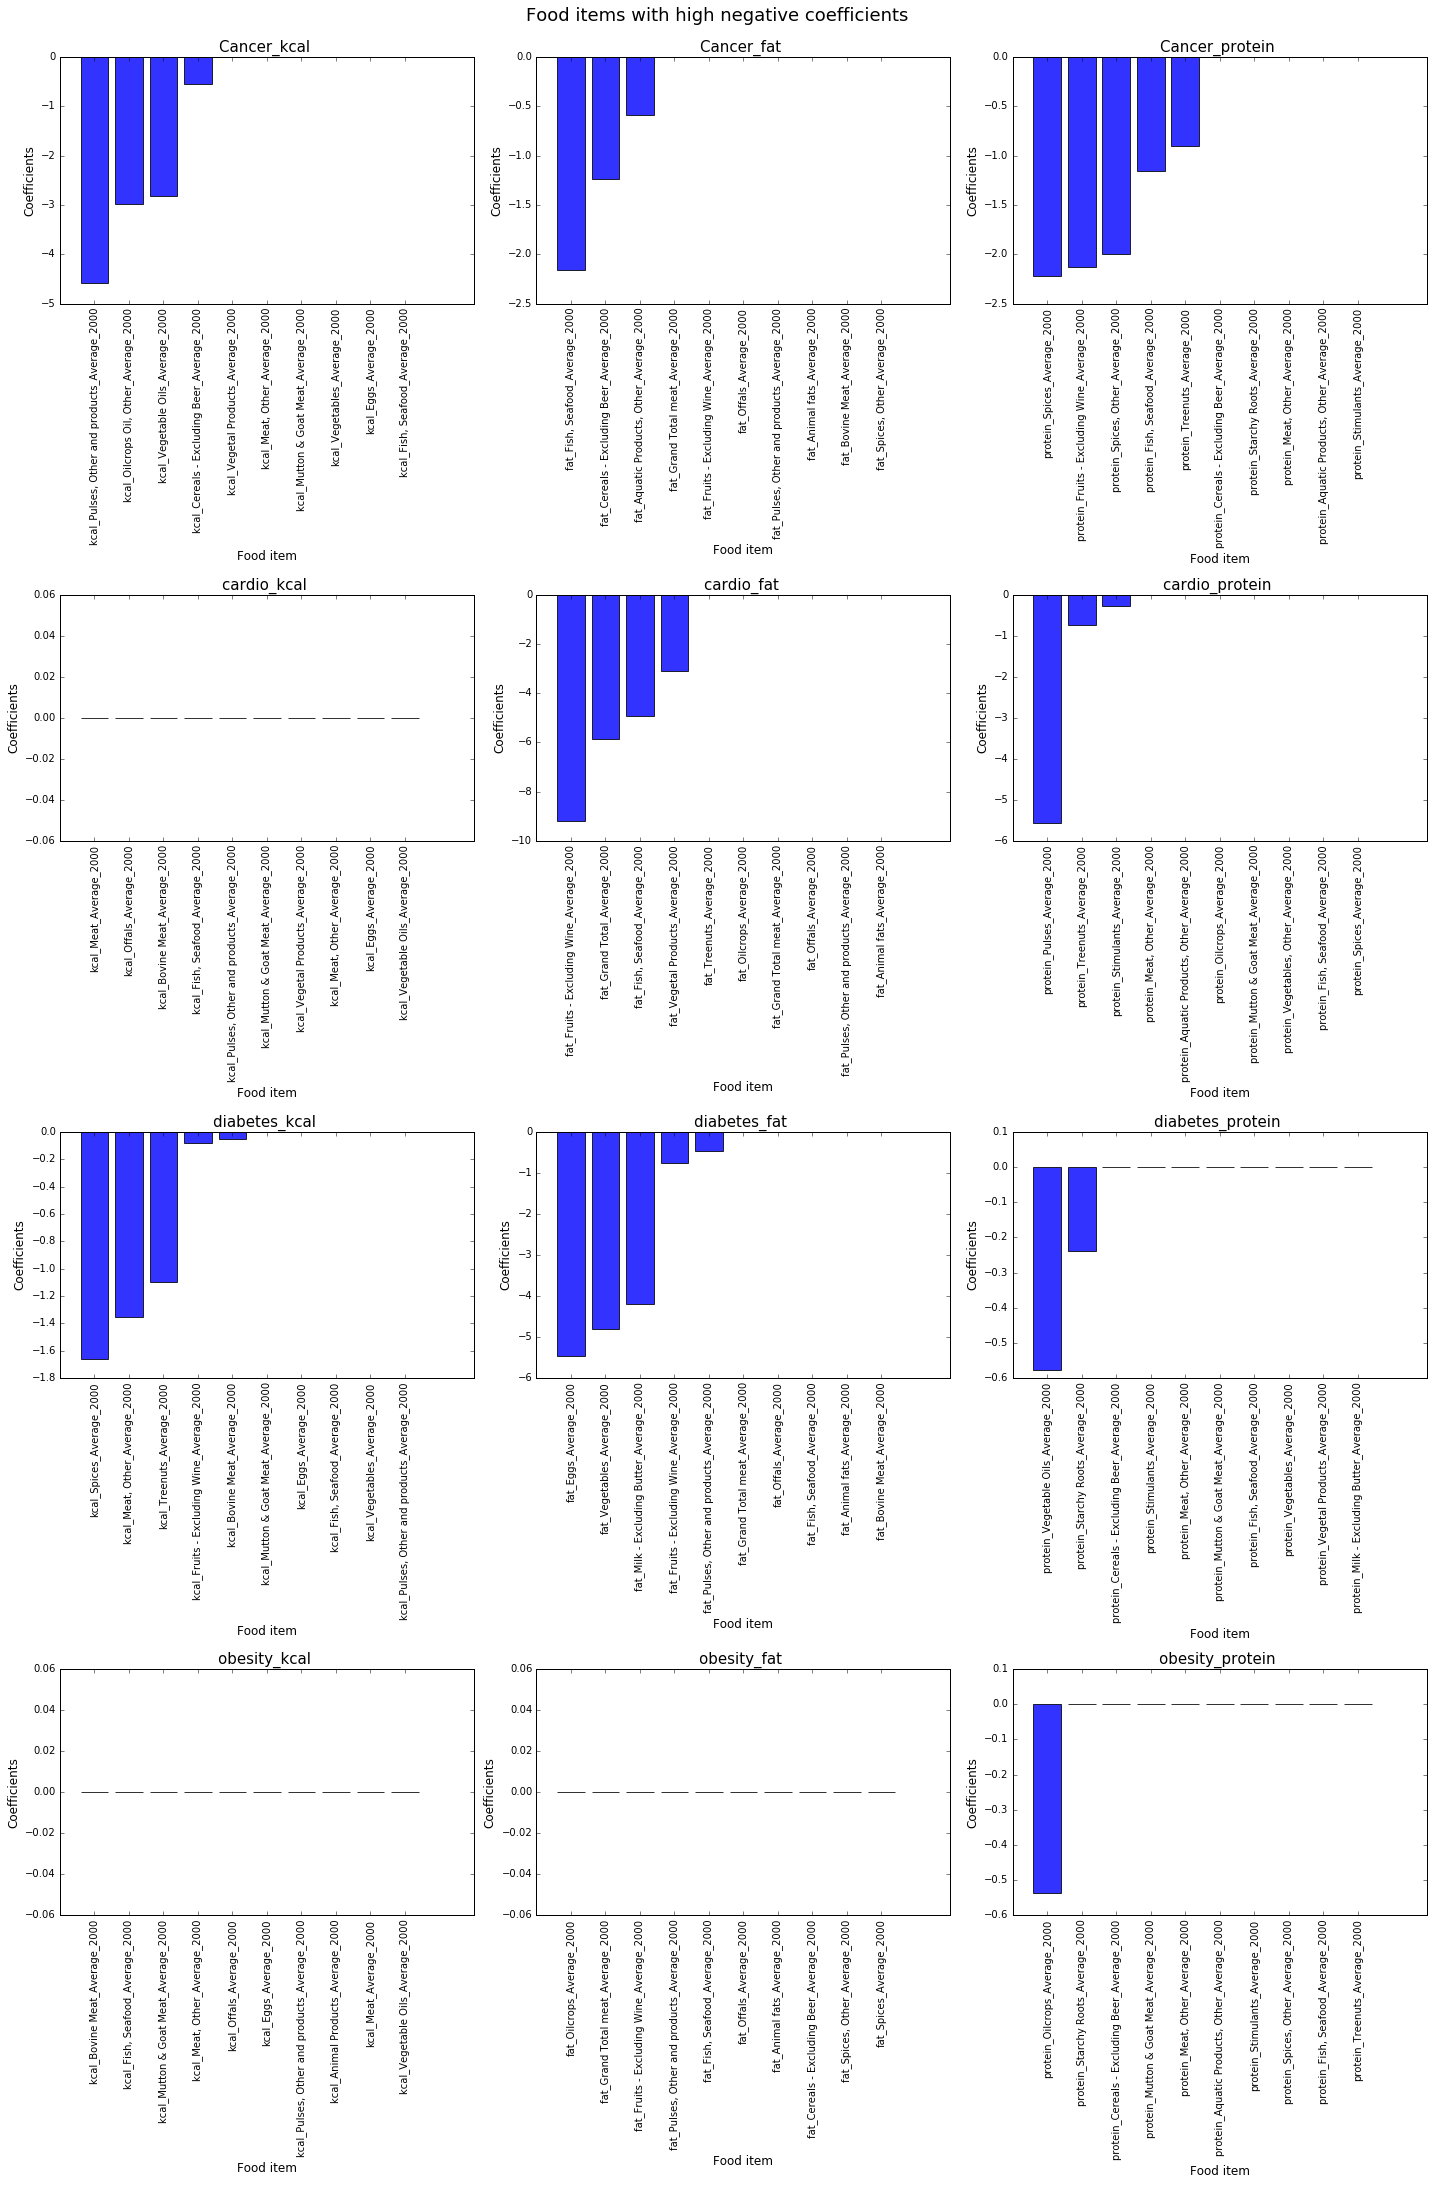

In [151]:
fig, ax = plt.subplots(4, 3, figsize = (20, 30))

# Cancer 
ax[0,0].bar(range(1, 11, 1), kcal_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,0].set_ylabel('Coefficients', size = 12)
ax[0,0].set_xlabel('Food item', size = 12)
ax[0,0].set_title("Cancer_kcal ", size = 15)
ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(kcal_coef_cancer_10["Predictor name"], rotation=90)

ax[0,1].bar(range(1, 11, 1), fat_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,1].set_ylabel('Coefficients', size = 12)
ax[0,1].set_xlabel('Food item', size = 12)
ax[0,1].set_title("Cancer_fat ", size = 15)
ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(fat_coef_cancer_10["Predictor name"], rotation=90)

ax[0,2].bar(range(1, 11, 1), protein_coef_cancer_10["Coefficient"], align='center', alpha=0.8)
ax[0,2].set_ylabel('Coefficients', size = 12)
ax[0,2].set_xlabel('Food item', size = 12)
ax[0,2].set_title("Cancer_protein ", size = 15)
ax[0,2].set_xticks(range(1, 11, 1))
ax[0,2].set_xticklabels(protein_coef_cancer_10["Predictor name"], rotation=90)

# Cardio
ax[1,0].bar(range(1, 11, 1), kcal_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,0].set_ylabel('Coefficients', size = 12)
ax[1,0].set_xlabel('Food item', size = 12)
ax[1,0].set_title("cardio_kcal ", size = 15)
ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(kcal_coef_cardio_10["Predictor name"], rotation=90)

ax[1,1].bar(range(1, 11, 1), fat_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,1].set_ylabel('Coefficients', size = 12)
ax[1,1].set_xlabel('Food item', size = 12)
ax[1,1].set_title("cardio_fat ", size = 15)
ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(fat_coef_cardio_10["Predictor name"], rotation=90)

ax[1,2].bar(range(1, 11, 1), protein_coef_cardio_10["Coefficient"], align='center', alpha=0.8)
ax[1,2].set_ylabel('Coefficients', size = 12)
ax[1,2].set_xlabel('Food item', size = 12)
ax[1,2].set_title("cardio_protein ", size = 15)
ax[1,2].set_xticks(range(1, 11, 1))
ax[1,2].set_xticklabels(protein_coef_cardio_10["Predictor name"], rotation=90)

# Diabetes 
ax[2,0].bar(range(1, 11, 1), kcal_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,0].set_ylabel('Coefficients', size = 12)
ax[2,0].set_xlabel('Food item', size = 12)
ax[2,0].set_title("diabetes_kcal ", size = 15)
ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(kcal_coef_diabetes_10["Predictor name"], rotation=90)

ax[2,1].bar(range(1, 11, 1), fat_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,1].set_ylabel('Coefficients', size = 12)
ax[2,1].set_xlabel('Food item', size = 12)
ax[2,1].set_title("diabetes_fat ", size = 15)
ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(fat_coef_diabetes_10["Predictor name"], rotation=90)

ax[2,2].bar(range(1, 11, 1), protein_coef_diabetes_10["Coefficient"], align='center', alpha=0.8)
ax[2,2].set_ylabel('Coefficients', size = 12)
ax[2,2].set_xlabel('Food item', size = 12)
ax[2,2].set_title("diabetes_protein ", size = 15)
ax[2,2].set_xticks(range(1, 11, 1))
ax[2,2].set_xticklabels(protein_coef_diabetes_10["Predictor name"], rotation=90)

# Diabetes 
ax[3,0].bar(range(1, 11, 1), kcal_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,0].set_ylabel('Coefficients', size = 12)
ax[3,0].set_xlabel('Food item', size = 12)
ax[3,0].set_title("obesity_kcal ", size = 15)
ax[3,0].set_xticks(range(1, 11, 1))
ax[3,0].set_xticklabels(kcal_coef_obesity_10["Predictor name"], rotation=90)

ax[3,1].bar(range(1, 11, 1), fat_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,1].set_ylabel('Coefficients', size = 12)
ax[3,1].set_xlabel('Food item', size = 12)
ax[3,1].set_title("obesity_fat ", size = 15)
ax[3,1].set_xticks(range(1, 11, 1))
ax[3,1].set_xticklabels(fat_coef_obesity_10["Predictor name"], rotation=90)

ax[3,2].bar(range(1, 11, 1), protein_coef_obesity_10["Coefficient"], align='center', alpha=0.8)
ax[3,2].set_ylabel('Coefficients', size = 12)
ax[3,2].set_xlabel('Food item', size = 12)
ax[3,2].set_title("obesity_protein ", size = 15)
ax[3,2].set_xticks(range(1, 11, 1))
ax[3,2].set_xticklabels(protein_coef_obesity_10["Predictor name"], rotation=90)

plt.tight_layout()
plt.suptitle("Food items with high negative coefficients", y=1.01, fontsize=18)
plt.show

Similar to the Lasso model coefficients with food item data, we listed food groups with high negative coefficients. While so-called healty foods are more related to reduction in disease prevalence and mortality, the food groups are listed a bit different from food items listed in the previous analysis. This is because food groups are sum of similar food items, and thus the effects of individual food items are averaged out.

## 3.4 PCA dimensionality reduction
### 3.4.1 PCA for food items

**Principal Components Analysis (PCA)** is a very popular technique to deal with one of the main issues our baseline model faces: **high dimensionality of the predictors**, specially in the case of food related explanatory variables.

Thus, we used PCA to reduce the dimensionality of the food data, making sure we were selecting the 'optimal' number of principal components such data most of the variability of the data was captured. Then, we used the principal components as predictors in a weighted linear regression, (instead of the food information), along the socio economic variables and the diversity index.

In [152]:
## Data Preparation ##

# Load consolidated data #
#data_items = pd.read_csv('food_items_dec2000s.csv')
data_items = pd.read_csv('food_items_dec2000s.csv')

# Define y (response variable) x_food (food related predictors) and x (all predictors)
diseases = ['cancer_all_2000', 'diabetes_all_2000', 'cardio_all_2000', 'obesity_all_2010',\
            'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014', \
            'cancer_male_2000', 'diabetes_male_2000', 'cardio_male_2000', \
            'cancer_male_2012', 'diabetes_male_2012', 'cardio_male_2012', \
            'cancer_female_2000', 'diabetes_female_2000', 'cardio_female_2000', \
            'cancer_female_2012', 'diabetes_female_2012', 'cardio_female_2012']

# Keep only three years for socio-econ data
econ = ['gdppc_2011', 'gdppc_2012', \
              'health expenditure_2010', 'health expenditure_2011', 'health expenditure_2012']

data_econ = data_items['gdppc_2010']
for e in econ: 
    econ_e = data_items[e]
    data_econ = pd.concat([data_econ, econ_e], axis=1)

# All predictors
x = data_items.drop(data_items[diseases], 1)
x = x.drop('country', 1)
x = x.drop('iso', 1)
x = x.drop('income level code', 1)
x = x.drop('diversity_2004_2013', 1)
x = x.drop(x.filter(regex='weight'), 1)
x = x.drop(x.filter(regex='population'), 1)
x = x.drop(x.filter(regex='total_'), 1)
x = x.drop(x.filter(regex='gdppc'), 1)
x = x.drop(x.filter(regex='health'), 1)
x = x.drop(x[[0]], 1)
x = pd.concat([x, data_econ], axis = 1)

# Food predictors
x_food = data_items.drop(data_items[diseases], 1)
x_food = x_food.drop('country', 1) 
x_food = x_food.drop('iso', 1)
x_food = x_food.drop('income level code', 1)
x_food = x_food.drop(x_food.filter(regex='gdppc'), 1)
x_food = x_food.drop(x_food.filter(regex='total_'), 1)
x_food = x_food.drop(x_food.filter(regex='weight'), 1)
x_food = x_food.drop(x_food.filter(regex='health'), 1)
x_food = x_food.drop(x_food.filter(regex='diversity'), 1)
x_food = x_food.drop(x_food.filter(regex='population'), 1)
x_food = x_food.drop(x_food[[0]], 1)

# Socio economic predictors and diversity
x_rest = x.drop(x[x_food.columns], 1)
x_rest = x_rest.drop(x_rest.filter(regex='total_'), 1)

# Weight (population share)
weight = data_items.filter(regex='weight')

Our criteria to select the optimal number of principal components was to consider the **minimum number of principal components that jointly explain at least 90% of the variation of the food data**.

In [155]:
## PCA analysis ###

# Calculating explain variance per component

components = 6
corr_food = x_food.corr()
pca = PCA(n_components = components)
pca.fit(x_food)
pca_comp = pca.components_ #Components
exp_var = pca.explained_variance_ratio_ #Explained variance (ratio)
cum_var = np.cumsum(exp_var) #Cumulative var.

<function matplotlib.pyplot.show>

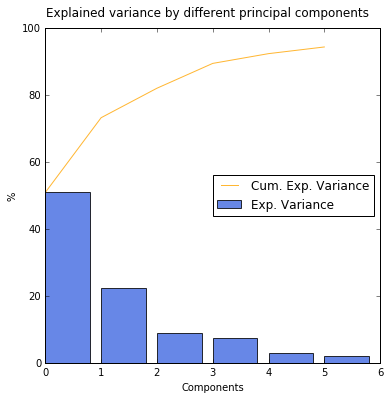

In [156]:
# Select number of principal components
n_rows = 1
n_cols = 1

fig, ax = plt.subplots (nrows=n_rows, ncols=n_cols, figsize = (6, 6))

ax.bar(range(0,len(exp_var)), exp_var*100, color='royalblue', alpha=0.8, \
            label='Exp. Variance')
ax.plot(range(0,len(cum_var)), cum_var*100, color='orange', alpha=0.8, \
            label='Cum. Exp. Variance')
ax.set_ylabel('%')
ax.set_xlabel('Components')
ax.set_ylim([0,100])
ax.legend(loc='best')

plt.suptitle('Explained variance by different principal components', y=0.95, size=12)
plt.show


As seen in the graph above, the first six principal components capture about 94% of the variation of the data. This is confirmed by calculating the cumulative explained varianced associated to the first six components (see table bellow).

In [157]:
# Explained variance first 5 principal components, per year

exp_variance_tot = sum(exp_var)

exp_variance_df = pd.DataFrame(round(exp_variance_tot*100, 3), columns = ['% Explained'], \
                            index = ['Components 1 to 6'])

print 'The first 6 principal components explain on average the following percentage of the \
variability of the data:'
exp_variance_df

The first 6 principal components explain on average the following percentage of the variability of the data:


,% Explained
Components 1 to 6,94.335


**Transforming the data with PCA. Using the transformed data in a WLS**

In [161]:
## Estimate weighted model with PCA dimensionality reduction ##

# Standarize the non-food related predictors
std_scale = StandardScaler().fit(x_rest)
x_rest_st = std_scale.transform(x_rest)
x_rest_st = pd.DataFrame(x_rest_st, columns = [x_rest.columns])

# Predictors for linear model with pca principal components per year
model = PCA(n_components = len(x_food.columns))
z = model.fit_transform(scale(x_food))
z = pd.DataFrame(z[:,:components], columns = ['z_1', 'z_2', 'z_3', 'z_4','z_5','z_6'])

# Final set of predictors
x_pca = pd.concat([x_rest_st, z], axis=1)

# Response variables
diseases_2012 = [ 'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', \
                 'obesity_all_2014']

# Model: All sample
x_pca_c = sm.add_constant(x_pca)

for disease in diseases_2012:
    model = sm.WLS(data_items[disease], x_pca_c, weight = weight, hasconst=True).fit()
    results = [model.rsquared, model.rsquared_adj, model.aic, model.bic]
    locals()["results_"+str(disease)] = pd.DataFrame(np.array(results).reshape(1,4), \
                   columns=['R2', 'R2-adj', 'AIC', 'BIC'], \
                  index = [str(disease)])

In [162]:
## Summary results weighted models - All Sample
diseases_2012_nc = ['diabetes_all_2012', 'cardio_all_2012', \
                 'obesity_all_2014']

summary_pca_allsample = results_cancer_all_2012
for disease in diseases_2012_nc:
    summary_pca_allsample = pd.concat([summary_pca_allsample, locals()["results_"+str(disease)]])

print "## Results for weighted model ##"    
summary_pca_allsample

## Results for weighted model ##


,R2,R2-adj,AIC,BIC
cancer_all_2012,0.287063,0.225685,1553.695273,1597.178510
diabetes_all_2012,0.338657,0.281720,1539.813789,1583.297026
cardio_all_2012,0.527679,0.487015,1961.597062,2005.080299
obesity_all_2014,0.548757,0.509908,1106.703232,1150.186469


This table depicts the goodness of adjustment of the estimated models for each of the diseases. However, the same fashion we did it in the case of our baseline models, weighted linear regression and lasso, we will be dealing with overfitting using Leave One Out cross validation, and **the metric we will use to compare PCA with the remaining models will be use be cross-validated MSE**.

In [163]:
## Cross-Validation: Leave One Out

#--------  loo_mse
# A function for leave one out cross validation with Weighted Linear Regression 
# and PCA regress.
# Input: 
#      x_train (n x d array of predictors in training data - all sample)
#      y_train (n x d array of predictors in training data - all sample)
#      disease (disease name)
# Return: 
#      MSE leave one out

def loo_mse(x_train, y_train, disease):
    mse_res = []
    for i in range(1, 165, 1):
        index = int(i-1)
        y_train = pd.DataFrame(y_train)
        # Define training and testing samples
        y_train_loo = y_train[y_train.index != index]
        y_test_loo = y_train[y_train.index == index]
        
        x_train_loo = x_train[x_train.index != index]
        x_test_loo = x_train[x_train.index == index]
        
        # Fit the model
        model = sm.WLS(y_train_loo, x_train_loo, weight = weight).fit()
        
        # Calculate MSE
        yhat =  model.predict(x_test_loo)
        mse_res_aux = (y_test_loo.values - yhat)**2
        mse_res.append(mse_res_aux)
        mse_res_df = pd.DataFrame(round(np.array(mse_res).mean(), 4), columns = ['MSE-CV'], \
                     index = [str(disease)])  
    return mse_res_df


In [164]:
## Summary results - Cross Validation LOO

summary_pca_crossval = loo_mse(x_pca_c, data_items['cancer_all_2012'], 'cancer_all_2012')
summary_pca_crossval

for disease in diseases_2012_nc:
    temp = loo_mse(x_pca_c, data_items[disease], disease)
    summary_pca_crossval = pd.concat([summary_pca_crossval, temp])

summary_pca_crossval

,MSE-CV
cancer_all_2012,634.1050
diabetes_all_2012,723.8781
cardio_all_2012,8559.8110
obesity_all_2014,60.4902


**Results**: As depicted in the table, **PCA does a significantly better job at reducing the Mean Squared Error when compared with the rest of the models**, as in all cases, the MSE-CV is remarkably lower than in the case of the linear model, the weighted linear regression, and Lasso.

### 3.4.5 PCA for food groups
We perform the same kind of analysis for group data, as shown:

In [165]:
## Data Preparation ##

# Load consolidated data #
data_groups = pd.read_csv('food_groups_dec2000s.csv')
       
# All predictors
diseases = ['cancer_all_2000', 'diabetes_all_2000', 'cardio_all_2000', 'obesity_all_2010', \
            'cancer_all_2012', 'diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014', \
            'cancer_male_2000', 'diabetes_male_2000', 'cardio_male_2000', \
            'cancer_male_2012', 'diabetes_male_2012', 'cardio_male_2012', \
            'cancer_female_2000', 'diabetes_female_2000', 'cardio_female_2000', \
            'cancer_female_2012', 'diabetes_female_2012', 'cardio_female_2012', 'country', \
            'iso', 'income level code', 'pop_weight_2012']

x_g = data_groups.drop(diseases, 1)
x_g = x_g.drop(x_g.filter(regex='weight'), 1)
x_g = x_g.drop(x_g.filter(regex='population'), 1)
x_g = x_g.drop(x_g.filter(regex='gdp'), 1)
x_g = x_g.drop(x_g.filter(regex='health'), 1)
x_g = x_g.drop(x_g.filter(regex='total_'), 1)
x_g = x_g.drop('diversity_2004_2013', 1)
x_g = x_g.drop(x_g[[0]], 1)
x_g = pd.concat([x_g, data_econ], axis = 1)

# Food predictors
x_g_food = data_groups.drop(diseases, 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='weight'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='population'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='total_'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='gdp'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='total_'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='health'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='diversity'), 1)
x_g_food = x_g_food.drop(x_g_food.filter(regex='population'), 1)
x_g_food = x_g_food.drop(x_g_food[[0]], 1)

Optimal number of principal components for group data:

In [167]:
## PCA analysis ###

# Calculating explain variance per component

components = 6
corr_food = x_g_food.corr()
pca_g = PCA(n_components = components)
pca_g.fit(x_g_food)
pca_g_comp = pca_g.components_ #Components
exp_var_g = pca_g.explained_variance_ratio_ #Explained variance (ratio)
cum_var_g = np.cumsum(exp_var_g) #Cumulative var.


<function matplotlib.pyplot.show>

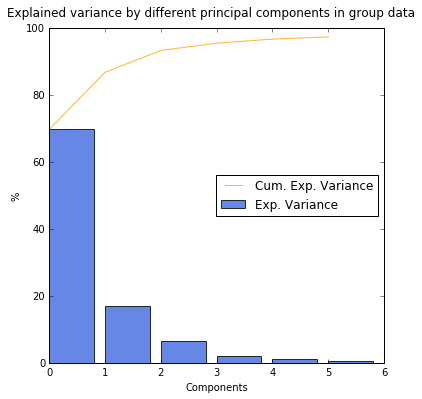

In [168]:
# Select number of principal components 

n_rows = 1
n_cols = 1

fig, ax = plt.subplots (nrows=n_rows, ncols=n_cols, figsize = (6, 6))

ax.bar(range(0,len(exp_var_g)), exp_var_g*100, color='royalblue', alpha=0.8, \
            label='Exp. Variance')
ax.plot(range(0,len(cum_var_g)), cum_var_g*100, color='orange', alpha=0.8, \
            label='Cum. Exp. Variance')
ax.set_ylabel('%')
ax.set_xlabel('Components')
ax.set_ylim([0,100])
ax.legend(loc='best')

plt.suptitle('Explained variance by different principal components in group data', \
             y=0.95, size=12)
plt.show

Both the graph and the table above shown that **the first six principal components capture together about 97% of the variability of the group food data**.

In [169]:
# Explained variance first 5 principal components, per year

exp_variance_tot_g = sum(exp_var_g)

exp_variance_df_g = pd.DataFrame(round(exp_variance_tot_g*100, 3), columns = ['% Explained'], \
                            index = ['Components 1 to 6'])

print 'The first 6 principal components explain on average the following percentage of the \
variability of the group data:'
exp_variance_df_g

The first 6 principal components explain on average the following percentage of the variability of the group data:


,% Explained
Components 1 to 6,97.337


As before, we used these first six principal components as predictors instead of the food data it self, along with the economic variables and the diversity index:

In [171]:
## Estimate model with PCA dimensionality reduction ##

# Predictors for linear model with pca principal components per year
model_g = PCA(n_components = len(x_g_food.columns))
z_g = model_g.fit_transform(scale(x_g_food))
z_g = pd.DataFrame(z_g[:,:components], columns = ['z_1', 'z_2', 'z_3', 'z_4','z_5','z_6'])

# Final set of predictors
x_g_pca = pd.concat([x_rest_st, z_g], axis=1)

# Model: All sample
x_g_pca_c = sm.add_constant(x_g_pca)

for disease in diseases_2012:
    model_g = sm.WLS(data_groups[disease], x_g_pca_c, weight = weight).fit()
    results_g = [model_g.rsquared, model_g.rsquared_adj, model_g.aic, model_g.bic]
    locals()["results_g_"+str(disease)] = pd.DataFrame(np.array(results_g).reshape(1,4), \
                   columns=['R2', 'R2-adj', 'AIC', 'BIC'], \
                  index = [str(disease)])

In [172]:
## Summary results - All Sample for groups
diseases_2012_nc = ['diabetes_all_2012', 'cardio_all_2012', 'obesity_all_2014']

summary_pca_groups = results_g_cancer_all_2012
for disease in diseases_2012_nc:
    summary_pca_groups = pd.concat([summary_pca_groups, locals()["results_g_"+str(disease)]])

summary_pca_groups 

,R2,R2-adj,AIC,BIC
cancer_all_2012,0.312505,0.253317,1547.699495,1591.182732
diabetes_all_2012,0.303679,0.243730,1548.317576,1591.800812
cardio_all_2012,0.487789,0.443691,1974.974957,2018.458194
obesity_all_2014,0.446614,0.398972,1140.371357,1183.854593


In [173]:
## Summary results - Cross Validation for food groups

group_pca_crossval_g = loo_mse(x_g_pca_c, data_items['cancer_all_2012'], 'cancer_all_2012')

for disease in diseases_2012_nc:
    temp = loo_mse(x_g_pca_c, data_items[disease], disease)
    group_pca_crossval_g = pd.concat([group_pca_crossval_g, temp])

group_pca_crossval_g

,MSE-CV
cancer_all_2012,656.9368
diabetes_all_2012,761.4439
cardio_all_2012,9618.0918
obesity_all_2014,69.0910


**Results**: In the same fashion than in the case of item data, **PCA-weighted linear model also yields significantly better results in terms of minimizing the MSE-CV across diseases** when compared with the remaining models for group data. 

## 3.5 PCA analysis (using weights as proxy for diet composition)
### 3.5.1. PCA weights analysis 
In this section we analized the principal components loadings (weights), which define the direction in which there is the greatest variability of the food data. This information could give us a sense of which of the considered food elements (i.e. protein, fat, kcal) for each the food item (i.e, banana, sugar, etc), are contributing the most (and the least) of such variability. For that, we analyzed the loadings in each of the six "optimal" principal components, as shown:

** Items data **

In [174]:
# Retrieving weights per principal component
pca.fit(x_food)
weights = pca.components_
weights = pd.DataFrame((weights*100).T.round(5), columns=['PC-1', 'PC-2', \
                                                          'PC-3', 'PC-4', \
                                                          'PC-5', 'PC-6'], \
             index=x_food.columns)

weights_pca_1 = weights['PC-1']
weights_pca_1 = weights_pca_1.sort_values()

weights_pca_2 = weights['PC-2']
weights_pca_2 = weights_pca_2.sort_values()

weights_pca_3 = weights['PC-3']
weights_pca_3 = weights_pca_3.sort_values()

weights_pca_4 = weights['PC-4']
weights_pca_4 = weights_pca_4.sort_values()

weights_pca_5 = weights['PC-5']
weights_pca_5 = weights_pca_5.sort_values()

weights_pca_6 = weights['PC-6']
weights_pca_6 = weights_pca_6.sort_values()

# Retrieving food elements with the max and min contribution, by principal component
pc1_min = pd.DataFrame(weights_pca_1[:10])
pc1_max = pd.DataFrame(weights_pca_1[-10:])

pc2_min = pd.DataFrame(weights_pca_2[:10])
pc2_max = pd.DataFrame(weights_pca_2[-10:])

pc3_min = pd.DataFrame(weights_pca_3[:10])
pc3_max = pd.DataFrame(weights_pca_3[-10:])

pc4_min = pd.DataFrame(weights_pca_4[:10])
pc4_max = pd.DataFrame(weights_pca_4[-10:])

pc5_min = pd.DataFrame(weights_pca_5[:10])
pc5_max = pd.DataFrame(weights_pca_5[-10:])

pc6_min = pd.DataFrame(weights_pca_6[:10])
pc6_max = pd.DataFrame(weights_pca_6[-10:])


<function matplotlib.pyplot.show>

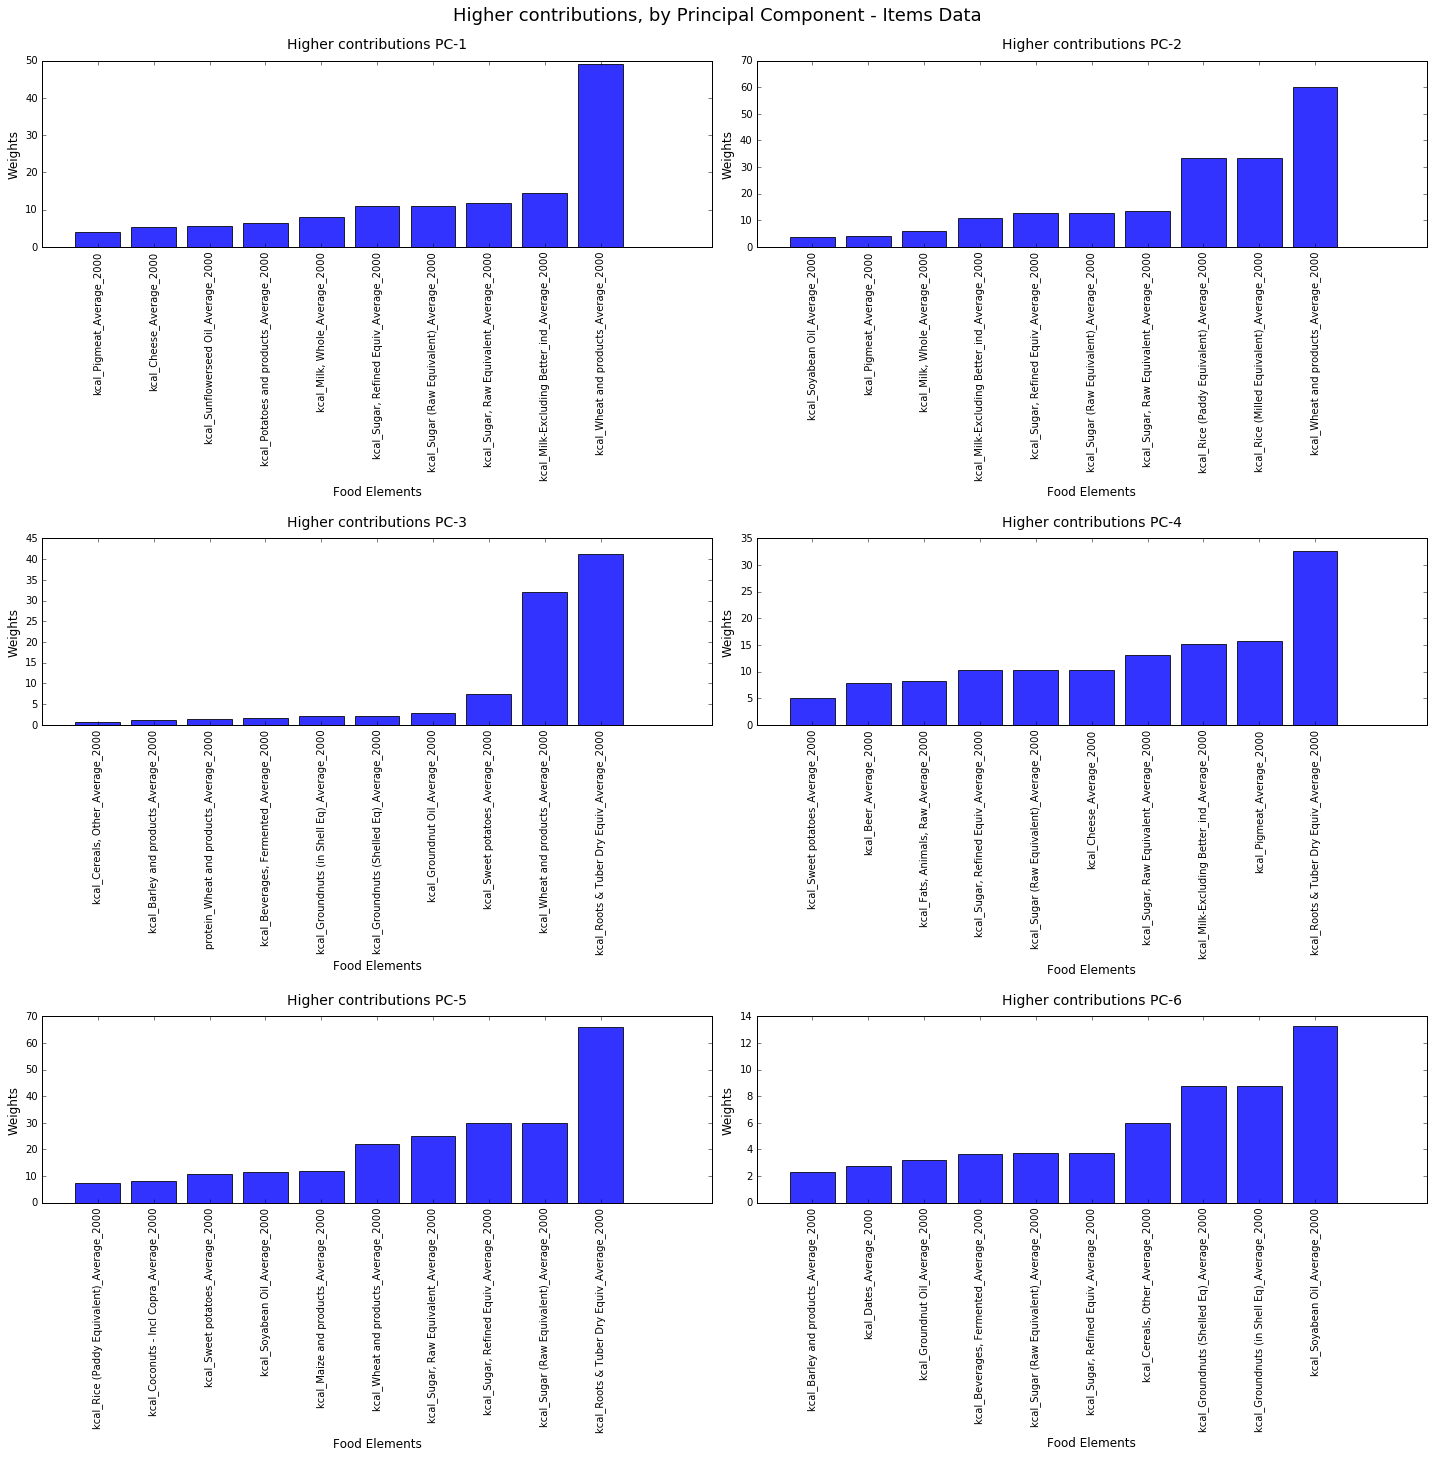

In [175]:
## Plot weights by components: Higher contributions by principal component

fig, ax = plt.subplots(3, 2, figsize = (20, 20))

labels = pc1_max.index
ax[0,0].bar(range(1, 11, 1), pc1_max.values, align='center', alpha=0.8)
ax[0,0].set_ylabel('Weights', size = 12)
ax[0,0].set_xlabel('Food Elements', size = 12)

ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(labels, rotation=90)
ax[0,0].set_title('Higher contributions PC-1', y=1.04, size=14)

labels = pc2_max.index
ax[0,1].bar(range(1, 11, 1), pc2_max.values, align='center', alpha=0.8)
ax[0,1].set_ylabel('Weights', size = 12)
ax[0,1].set_xlabel('Food Elements', size = 12)

ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(labels, rotation=90)
ax[0,1].set_title('Higher contributions PC-2', y=1.04, size=14)

labels = pc3_max.index
ax[1,0].bar(range(1, 11, 1), pc3_max.values, align='center', alpha=0.8)
ax[1,0].set_ylabel('Weights', size = 12)
ax[1,0].set_xlabel('Food Elements', size = 12)

ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(labels, rotation=90)
ax[1,0].set_title('Higher contributions PC-3', y=1.04, size=14)

labels = pc4_max.index
ax[1,1].bar(range(1, 11, 1), pc4_max.values, align='center', alpha=0.8)
ax[1,1].set_ylabel('Weights', size = 12)
ax[1,1].set_xlabel('Food Elements', size = 12)

ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(labels, rotation=90)
ax[1,1].set_title('Higher contributions PC-4', y=1.04, size=14)

labels = pc5_max.index
ax[2,0].bar(range(1, 11, 1), pc5_max.values, align='center', alpha=0.8)
ax[2,0].set_ylabel('Weights', size = 12)
ax[2,0].set_xlabel('Food Elements', size = 12)

ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(labels, rotation=90)
ax[2,0].set_title('Higher contributions PC-5', y=1.04, size=14)

labels = pc6_max.index
ax[2,1].bar(range(1, 11, 1), pc6_max.values, align='center', alpha=0.8)
ax[2,1].set_ylabel('Weights', size = 12)
ax[2,1].set_xlabel('Food Elements', size = 12)

ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(labels, rotation=90)
ax[2,1].set_title('Higher contributions PC-6', y=1.04, size=14)

plt.tight_layout()
plt.suptitle("Higher contributions, by Principal Component - Items Data", y=1.01, fontsize=18)
plt.show

As seen in the graph above, some of the food items and elements with the **highest** contributions, by component are: 
- **First PC**: Kcal for what, sugar, milk, potatos, sunflower seeds, cheese, pig meat.
- **Second PC**: Same as above, plus soybean (kcal).
- **Third PC**: Common elements with PC1 and PC2 plus cereals, wheit (protein) and grounds.
- **Fourth PC**: Common elements with P1-PC3 plus fermented beverages.
- **Fifth PC**: Common elements with P1-PC4 plus kcal in ground nuts, sweet potato, roots and tuber.
- **Sixth PC**: Common elements with P1-PC6 

<function matplotlib.pyplot.show>

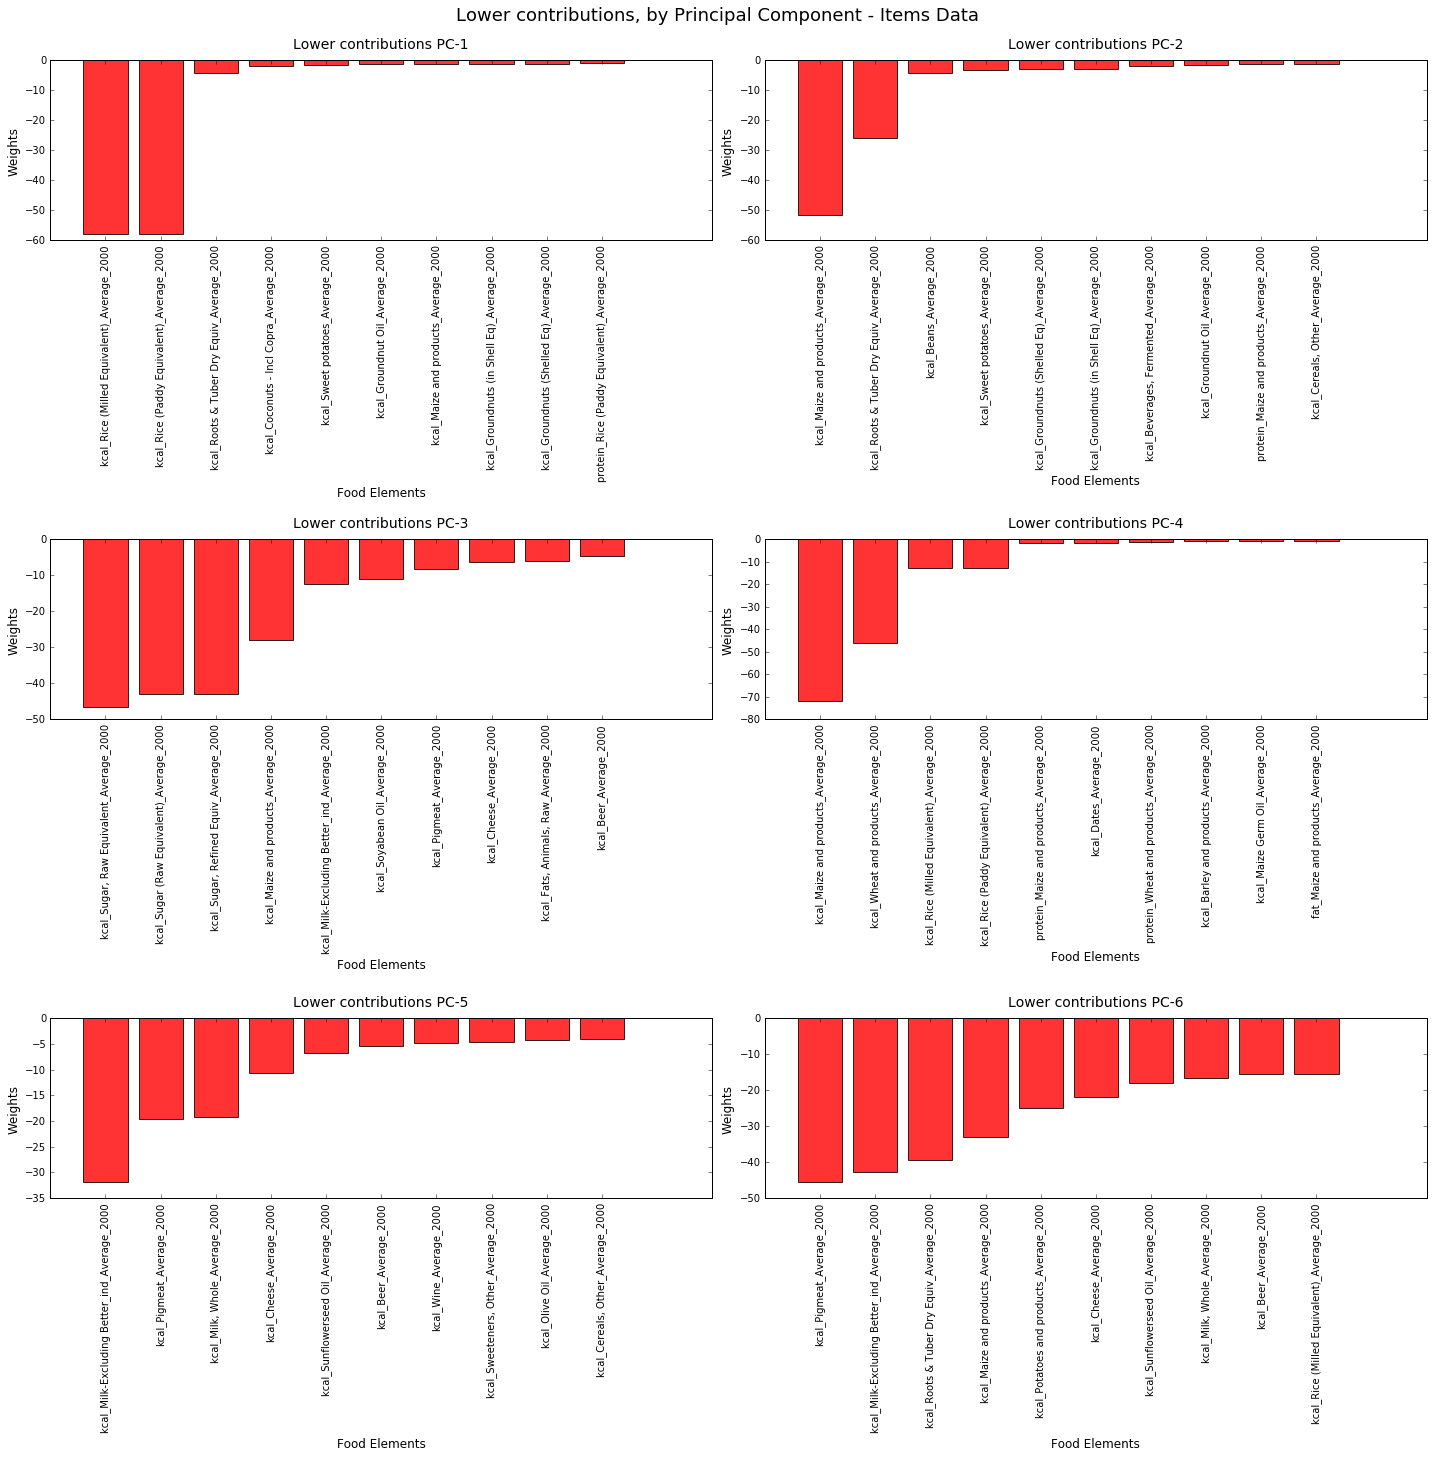

In [176]:
## Plot weights by components: Lower contributions by principal component

fig, ax = plt.subplots(3, 2, figsize = (20, 20))

labels = pc1_min.index
ax[0,0].bar(range(1, 11, 1), pc1_min.values, align='center', alpha=0.8, color='r')
ax[0,0].set_ylabel('Weights', size = 12)
ax[0,0].set_xlabel('Food Elements', size = 12)

ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(labels, rotation=90)
ax[0,0].set_title('Lower contributions PC-1', y=1.04, size=14)

labels = pc2_min.index
ax[0,1].bar(range(1, 11, 1), pc2_min.values, align='center', alpha=0.8, color='r')
ax[0,1].set_ylabel('Weights', size = 12)
ax[0,1].set_xlabel('Food Elements', size = 12)

ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(labels, rotation=90)
ax[0,1].set_title('Lower contributions PC-2', y=1.04, size=14)

labels = pc3_min.index
ax[1,0].bar(range(1, 11, 1), pc3_min.values, align='center', alpha=0.8, color='r')
ax[1,0].set_ylabel('Weights', size = 12)
ax[1,0].set_xlabel('Food Elements', size = 12)

ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(labels, rotation=90)
ax[1,0].set_title('Lower contributions PC-3', y=1.04, size=14)

labels = pc4_min.index
ax[1,1].bar(range(1, 11, 1), pc4_min.values, align='center', alpha=0.8, color='r')
ax[1,1].set_ylabel('Weights', size = 12)
ax[1,1].set_xlabel('Food Elements', size = 12)

ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(labels, rotation=90)
ax[1,1].set_title('Lower contributions PC-4', y=1.04, size=14)

labels = pc5_min.index
ax[2,0].bar(range(1, 11, 1), pc5_min.values, align='center', alpha=0.8, color='r')
ax[2,0].set_ylabel('Weights', size = 12)
ax[2,0].set_xlabel('Food Elements', size = 12)

ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(labels, rotation=90)
ax[2,0].set_title('Lower contributions PC-5', y=1.04, size=14)

labels = pc6_min.index
ax[2,1].bar(range(1, 11, 1), pc6_min.values, align='center', alpha=0.8, color='r')
ax[2,1].set_ylabel('Weights', size = 12)
ax[2,1].set_xlabel('Food Elements', size = 12)

ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(labels, rotation=90)
ax[2,1].set_title('Lower contributions PC-6', y=1.04, size=14)

plt.tight_layout()
plt.suptitle("Lower contributions, by Principal Component - Items Data", y=1.01, fontsize=18)
plt.show

As seen in the graph above, some of the food items and elements with the **lowest** contributions, by component are: 
- **First PC**: kcal for rice, roots and tubber, coconuts, sweet potatos, maize, and protein for rice.
- **Second PC**: Same as above, beans, fermented beverages and cereals (kcal).
- **Third PC**: Common elements with PC1 and PC2 plus cereals, sugar, milk, fat from animals, beer.
- **Fourth PC**: Common elements with P1-PC3 plus soybean and pig meat.
- **Fifth PC**: Common elements with P1-PC4 plus cheese.
- **Sixth PC**: Common elements with P1-PC6 

** Group data**

In [177]:
# Retrieving weights 
pca.fit(x_g_food)
weights_g = pca.components_
weights_g = pd.DataFrame((weights_g*100).T.round(5), columns=['PC-1', 'PC-2', \
                                                          'PC-3', 'PC-4', \
                                                          'PC-5', 'PC-6'], \
             index=x_g_food.columns)

weights_pca_g_1 = weights_g['PC-1']
weights_pca_g_1 = weights_pca_g_1.sort_values()

weights_pca_g_2 = weights_g['PC-2']
weights_pca_g_2 = weights_pca_g_2.sort_values()

weights_pca_g_3 = weights_g['PC-3']
weights_pca_g_3 = weights_pca_g_3.sort_values()

weights_pca_g_4 = weights_g['PC-4']
weights_pca_g_4 = weights_pca_g_4.sort_values()

weights_pca_g_5 = weights_g['PC-5']
weights_pca_g_5 = weights_pca_g_5.sort_values()

weights_pca_g_6 = weights_g['PC-6']
weights_pca_g_6 = weights_pca_g_6.sort_values()

# Retrieving food elements with the max and min contribution, by principal component
pc1_g_min = pd.DataFrame(weights_pca_g_1[:10])
pc1_g_max = pd.DataFrame(weights_pca_g_1[-10:])

pc2_g_min = pd.DataFrame(weights_pca_g_2[:10])
pc2_g_max = pd.DataFrame(weights_pca_g_2[-10:])

pc3_g_min = pd.DataFrame(weights_pca_g_3[:10])
pc3_g_max = pd.DataFrame(weights_pca_g_3[-10:])

pc4_g_min = pd.DataFrame(weights_pca_g_4[:10])
pc4_g_max = pd.DataFrame(weights_pca_g_4[-10:])

pc5_g_min = pd.DataFrame(weights_pca_g_5[:10])
pc5_g_max = pd.DataFrame(weights_pca_g_5[-10:])

pc6_g_min = pd.DataFrame(weights_pca_g_6[:10])
pc6_g_max = pd.DataFrame(weights_pca_g_6[-10:])


<function matplotlib.pyplot.show>

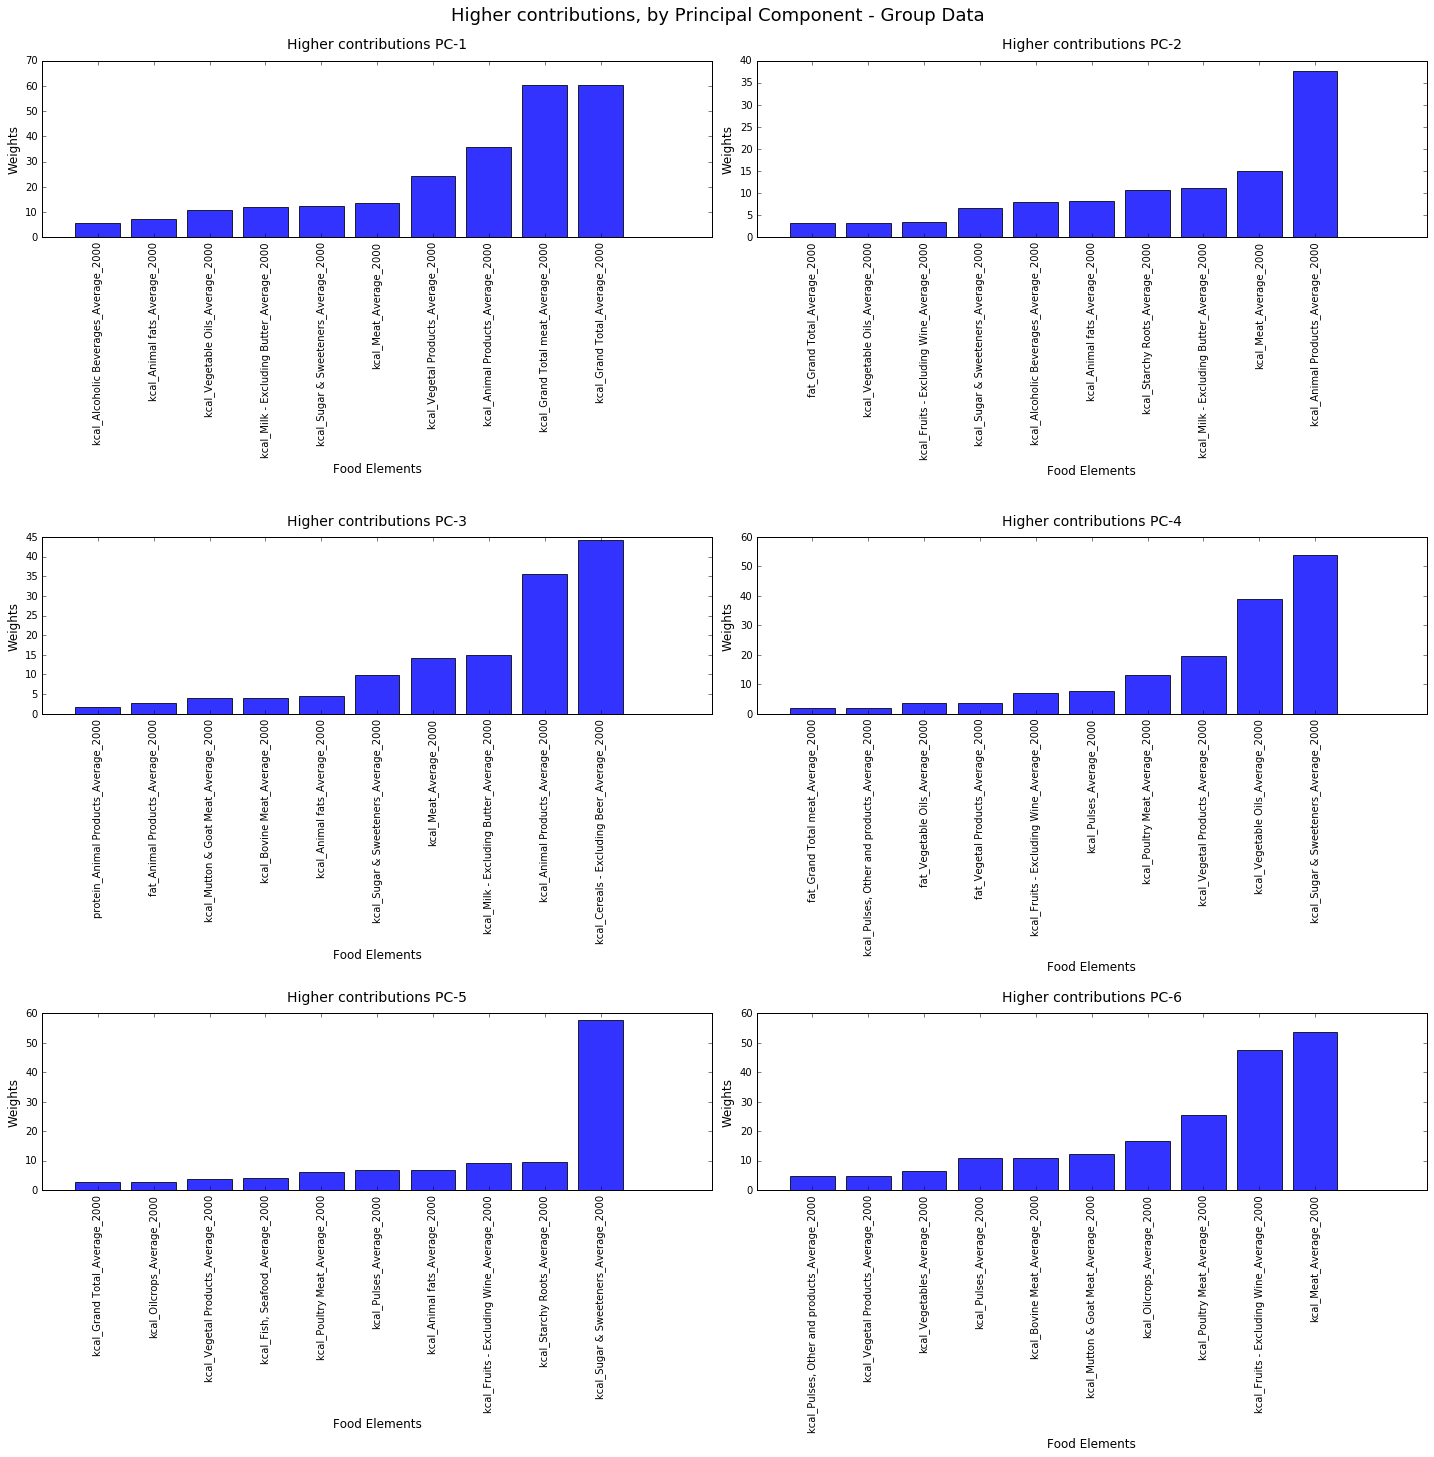

In [178]:
## Plot weights by components: Higher contributions by principal component

fig, ax = plt.subplots(3, 2, figsize = (20, 20))

labels = pc1_g_max.index
ax[0,0].bar(range(1, 11, 1), pc1_g_max.values, align='center', alpha=0.8)
ax[0,0].set_ylabel('Weights', size = 12)
ax[0,0].set_xlabel('Food Elements', size = 12)

ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(labels, rotation=90)
ax[0,0].set_title('Higher contributions PC-1', y=1.04, size=14)

labels = pc2_g_max.index
ax[0,1].bar(range(1, 11, 1), pc2_g_max.values, align='center', alpha=0.8)
ax[0,1].set_ylabel('Weights', size = 12)
ax[0,1].set_xlabel('Food Elements', size = 12)

ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(labels, rotation=90)
ax[0,1].set_title('Higher contributions PC-2', y=1.04, size=14)

labels = pc3_g_max.index
ax[1,0].bar(range(1, 11, 1), pc3_g_max.values, align='center', alpha=0.8)
ax[1,0].set_ylabel('Weights', size = 12)
ax[1,0].set_xlabel('Food Elements', size = 12)

ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(labels, rotation=90)
ax[1,0].set_title('Higher contributions PC-3', y=1.04, size=14)

labels = pc4_g_max.index
ax[1,1].bar(range(1, 11, 1), pc4_g_max.values, align='center', alpha=0.8)
ax[1,1].set_ylabel('Weights', size = 12)
ax[1,1].set_xlabel('Food Elements', size = 12)

ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(labels, rotation=90)
ax[1,1].set_title('Higher contributions PC-4', y=1.04, size=14)

labels = pc5_g_max.index
ax[2,0].bar(range(1, 11, 1), pc5_g_max.values, align='center', alpha=0.8)
ax[2,0].set_ylabel('Weights', size = 12)
ax[2,0].set_xlabel('Food Elements', size = 12)

ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(labels, rotation=90)
ax[2,0].set_title('Higher contributions PC-5', y=1.04, size=14)

labels = pc6_g_max.index
ax[2,1].bar(range(1, 11, 1), pc6_g_max.values, align='center', alpha=0.8)
ax[2,1].set_ylabel('Weights', size = 12)
ax[2,1].set_xlabel('Food Elements', size = 12)

ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(labels, rotation=90)
ax[2,1].set_title('Higher contributions PC-6', y=1.04, size=14)

plt.tight_layout()
plt.suptitle("Higher contributions, by Principal Component - Group Data", y=1.01, fontsize=18)
plt.show

As seen in the graph above, some of the food groups and elements with the **highest** contributions, by component are: 
- **First PC**: Kcal for what, meat (all), other animal products, vegetable products, sugars, vegetables and alcoholic beverages. 
- **Second PC**: Same as above, plus milk (kcal), animal fats, fruits (kcal).
- **Third PC**: Common elements with PC1 and PC2 plus goat meat,
- **Fourth PC**: Common elements with P1-PC3 plus pulses.
- **Fifth PC**: Common elements with P1-PC4 plus oil crops and seafood.
- **Sixth PC**: Common elements with P1-PC6.

<function matplotlib.pyplot.show>

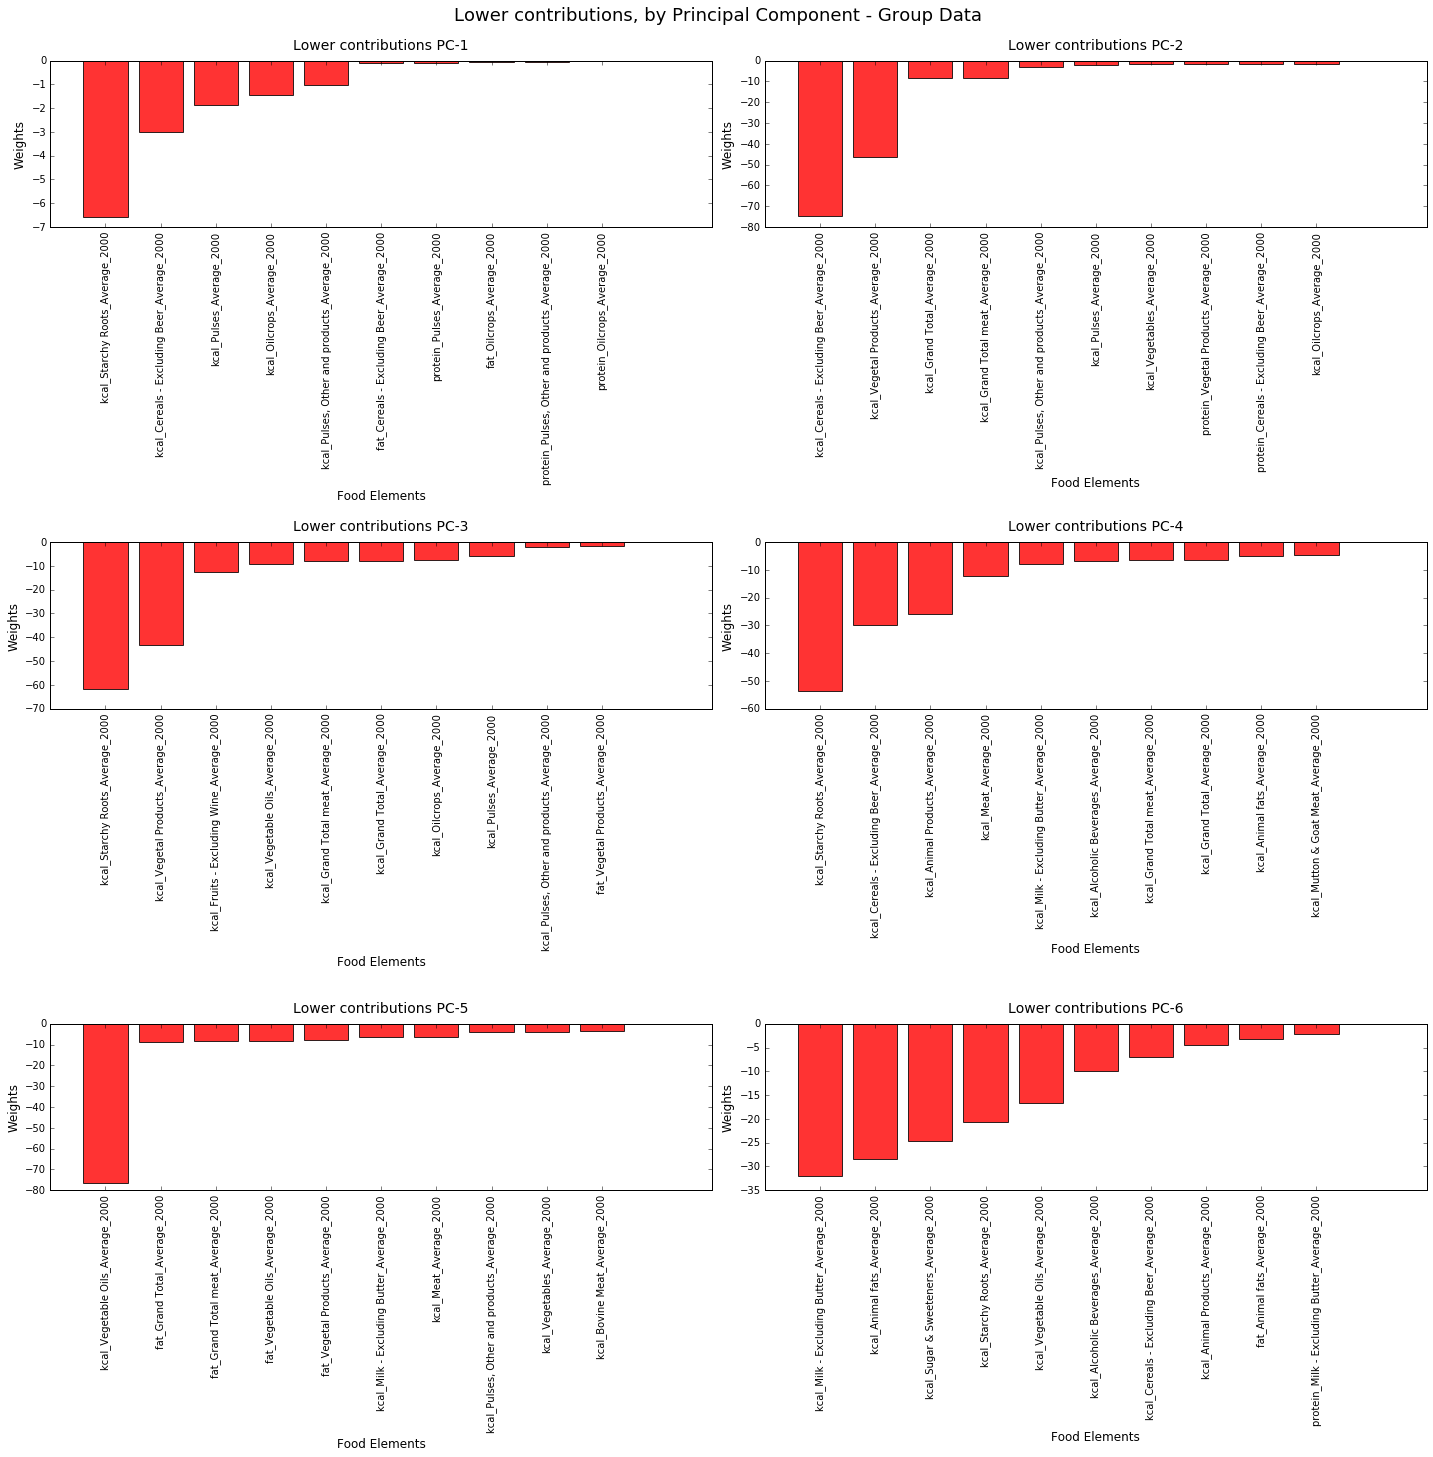

In [179]:
## Plot weights by components: Lower contributions by principal component

fig, ax = plt.subplots(3, 2, figsize = (20, 20))

labels = pc1_g_min.index
ax[0,0].bar(range(1, 11, 1), pc1_g_min.values, align='center', alpha=0.8, color='r')
ax[0,0].set_ylabel('Weights', size = 12)
ax[0,0].set_xlabel('Food Elements', size = 12)

ax[0,0].set_xticks(range(1, 11, 1))
ax[0,0].set_xticklabels(labels, rotation=90)
ax[0,0].set_title('Lower contributions PC-1', y=1.04, size=14)

labels = pc2_g_min.index
ax[0,1].bar(range(1, 11, 1), pc2_g_min.values, align='center', alpha=0.8, color='r')
ax[0,1].set_ylabel('Weights', size = 12)
ax[0,1].set_xlabel('Food Elements', size = 12)

ax[0,1].set_xticks(range(1, 11, 1))
ax[0,1].set_xticklabels(labels, rotation=90)
ax[0,1].set_title('Lower contributions PC-2', y=1.04, size=14)

labels = pc3_g_min.index
ax[1,0].bar(range(1, 11, 1), pc3_g_min.values, align='center', alpha=0.8, color='r')
ax[1,0].set_ylabel('Weights', size = 12)
ax[1,0].set_xlabel('Food Elements', size = 12)

ax[1,0].set_xticks(range(1, 11, 1))
ax[1,0].set_xticklabels(labels, rotation=90)
ax[1,0].set_title('Lower contributions PC-3', y=1.04, size=14)

labels = pc4_g_min.index
ax[1,1].bar(range(1, 11, 1), pc4_g_min.values, align='center', alpha=0.8, color='r')
ax[1,1].set_ylabel('Weights', size = 12)
ax[1,1].set_xlabel('Food Elements', size = 12)

ax[1,1].set_xticks(range(1, 11, 1))
ax[1,1].set_xticklabels(labels, rotation=90)
ax[1,1].set_title('Lower contributions PC-4', y=1.04, size=14)

labels = pc5_g_min.index
ax[2,0].bar(range(1, 11, 1), pc5_g_min.values, align='center', alpha=0.8, color='r')
ax[2,0].set_ylabel('Weights', size = 12)
ax[2,0].set_xlabel('Food Elements', size = 12)

ax[2,0].set_xticks(range(1, 11, 1))
ax[2,0].set_xticklabels(labels, rotation=90)
ax[2,0].set_title('Lower contributions PC-5', y=1.04, size=14)

labels = pc6_g_min.index
ax[2,1].bar(range(1, 11, 1), pc6_g_min.values, align='center', alpha=0.8, color='r')
ax[2,1].set_ylabel('Weights', size = 12)
ax[2,1].set_xlabel('Food Elements', size = 12)

ax[2,1].set_xticks(range(1, 11, 1))
ax[2,1].set_xticklabels(labels, rotation=90)
ax[2,1].set_title('Lower contributions PC-6', y=1.04, size=14)

plt.tight_layout()
plt.suptitle("Lower contributions, by Principal Component - Group Data", y=1.01, fontsize=18)
plt.show

As seen in the graph above, some of the food groups and elements with the **lowest** contributions, by component are: 
- **First PC**: Kcal for starchy roots, cereals, pulses, oil crops. 
- **Second PC**: Same as above, plus milk (kcal), vegetable products (protein).
- **Third PC**: Common elements with PC1 and PC2 plus fruits and vegetable oils.
- **Fourth PC**: Common elements with P1-PC3 plus fat from vegetables.
- **Fifth PC**: Common elements with P1-PC4 plus oil crops and seafood.
- **Sixth PC**: Common elements with P1-PC6.

### 3.5.2. Mapping PCA and countries

In general, the first principal component vector could also be interpreted as the line that is as close as possible to the data. Hence, in this section we wanted to explore which countries have the richest diets in the food items with the highest loadings in the first principal component and which countries were the ones with the lowest. We will do so by examing the first principal score (z_1) in our models.

In [180]:
### Mapping First PCA and countries - Data ###

## Items data
iso = data_items.filter(regex = 'iso')
country = data_items.filter(regex = 'country')
# Unweighted PCA
z_country = x_pca_c.filter(regex = 'z_')
# Weighted PCA
z_country_w = pd.DataFrame(z_country.values*(weight.apply(np.sqrt).values), \
                           columns = ['z_1_w', 'z_2_w', 'z_3_w', 'z_4_w', 'z_5_w', 'z_6_w'], \
                           index=z_country.index)
mapping_pca_all = pd.concat([iso, country, z_country, z_country_w], axis = 1)

var_map = ['iso', 'country', 'z_1', 'z_1_w']

# Country, First PCA, First PCA Weighted
mapping_pca_all[var_map].to_csv('mapping_pca.csv', index=False)

## Group data

# Unweighted PCA
z_g_country = x_g_pca_c.filter(regex = 'z_')
# Weighted PCA
z_g_country_w = pd.DataFrame(z_g_country.values*(weight.apply(np.sqrt).values), \
                           columns = ['z_1_w', 'z_2_w', 'z_3_w', 'z_4_w', 'z_5_w', \
                                      'z_6_w'], index=z_g_country.index)
mapping_pca_g_all = pd.concat([iso, country, z_g_country, z_g_country_w], axis = 1)

var_map_g = ['iso', 'country', 'z_1', 'z_1_w']

# Country, First PCA, First PCA Weighted - Group Data
mapping_pca_g_all[var_map_g].to_csv('mapping_pca_g.csv', index=False)


**Note:** To create the map for the pca index by country, we followed the same procedure than in section 2.1 (e.i. coding in plotly and then uploading the maps to thos note book). For details on the code, please refer to section 2.1.

<img src="PCA Weights weighted model map .png">

As seem above, most of the developed world (US, Europe, Russia) seems to have the richest diets in the items that contribute the most to explain the variation of the data captured by PC1 (i.e. this countriest have the highest first principal component score). In contrast, developing countries (with the exception of Lation America), specially the African countries and China, seem to have poorest diets in terms of the food items with the hightes loadings in PC1.

### 3.5.3. Analyzing Models Results
**Item Data - Analyzing PCA weights and its statistical significance**

In the the next section, we will link this information to the statistical significance of the principal component in each of the models. That, in turn, we allow us to stablish a correlation between food items/diets and mortality and prevalence of diseases.

In [181]:
### Cancer ###
model = sm.WLS(data_items['cancer_all_2012'], x_pca_c, weight = weight).fit()
p_values_cancer = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:        cancer_all_2012   R-squared:                       0.287
Model:                            WLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     4.677
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           9.46e-07
Time:                        23:13:09   Log-Likelihood:                -762.85
No. Observations:                 165   AIC:                             1554.
Df Residuals:                     151   BIC:                             1597.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

In [182]:
### Diabetes ###
model = sm.WLS(data_items['diabetes_all_2012'], x_pca_c, weight = weight).fit()
p_values_diabetes = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:      diabetes_all_2012   R-squared:                       0.339
Model:                            WLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     5.948
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           7.75e-09
Time:                        23:13:46   Log-Likelihood:                -755.91
No. Observations:                 165   AIC:                             1540.
Df Residuals:                     151   BIC:                             1583.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

#### Diabetes ####

- In this case, both the first and the fifth principal component are the most statistically significant predictors (at a level of confidence of 99%). Both of them are negative correlated with diabetes. This means that the food items with the lowest loads are positive correlated with diabetes mortality rate. 

In [183]:
### Cardio ###
model = sm.WLS(data_items['cardio_all_2012'], x_pca_c, weight = weight).fit()
p_values_cardio = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:        cardio_all_2012   R-squared:                       0.528
Model:                            WLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     12.98
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           7.52e-19
Time:                        23:14:31   Log-Likelihood:                -966.80
No. Observations:                 165   AIC:                             1962.
Df Residuals:                     151   BIC:                             2005.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

#### Cardio ####

- Interestingly, the first component score is not statistically significant. The second and the fifth PC, in contrast, are not only is highly significant (at a level of 2%) but the magnitud of their estimated coefficients is large. Since the sign of of the coefficient is negative, there is a positive association with those food items that contribute the least to explain the variability capture for this PC. Among the food items with the lower contribution in both components are calories from meats, speciall those in bovine meat. 
- An additional finding is that diversity index is also highly significant, and is negative associated with cardio mortality rate. This implies that a more diverse diet its negative correlated with this mortality rate.


In [184]:
### Obesity ###
model = sm.WLS(data_items['obesity_all_2014'], x_pca_c, weight = weight).fit()
p_values_obesity = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:       obesity_all_2014   R-squared:                       0.549
Model:                            WLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     14.13
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.95e-20
Time:                        23:14:57   Log-Likelihood:                -539.35
No. Observations:                 165   AIC:                             1107.
Df Residuals:                     151   BIC:                             1150.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

#### Obesity ####

- In this case, diversity is highly significant and positive associated with the prevalence of obesity across countries. This corresponds with what it is usually found in relevant literature.

- In terms of the significance of the principal components scores, we found that all of them are highly significant (at a level of confidence of 99% in most of the cases). 

### Group Data - Analyzing PCA weights and its statistical significance

In [185]:
### Cancer ###
model = sm.WLS(data_items['cancer_all_2012'], x_g_pca_c, weight = weight).fit()
p_values_g_cancer = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:        cancer_all_2012   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     5.280
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           9.49e-08
Time:                        23:15:46   Log-Likelihood:                -759.85
No. Observations:                 165   AIC:                             1548.
Df Residuals:                     151   BIC:                             1591.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

In [186]:
### Diabetes ###
model = sm.WLS(data_items['diabetes_all_2012'], x_g_pca_c, weight = weight).fit()
p_values_g_diabetes = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:      diabetes_all_2012   R-squared:                       0.304
Model:                            WLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     5.066
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.14e-07
Time:                        23:15:59   Log-Likelihood:                -760.16
No. Observations:                 165   AIC:                             1548.
Df Residuals:                     151   BIC:                             1592.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

In [187]:
### Cardio ###
model = sm.WLS(data_items['cardio_all_2012'], x_g_pca_c, weight = weight).fit()
p_values_g_cardio = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:        cardio_all_2012   R-squared:                       0.488
Model:                            WLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     11.06
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.25e-16
Time:                        23:16:13   Log-Likelihood:                -973.49
No. Observations:                 165   AIC:                             1975.
Df Residuals:                     151   BIC:                             2018.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     

In [188]:
### Obesity ###
model = sm.WLS(data_items['obesity_all_2014'], x_g_pca_c, weight = weight).fit()
p_values_g_obesity = pd.DataFrame(model.pvalues, columns = ['P-Value'])
print (model.summary())

                            WLS Regression Results                            
Dep. Variable:       obesity_all_2014   R-squared:                       0.447
Model:                            WLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     9.374
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           4.82e-14
Time:                        23:16:23   Log-Likelihood:                -556.19
No. Observations:                 165   AIC:                             1140.
Df Residuals:                     151   BIC:                             1184.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     